### 舊程式(營收還沒更新用的)

In [2]:
import requests
import numpy as np
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from random import randint
import pandas as pd
import openpyxl
from tqdm import trange
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設置字體為微軟正黑體
plt.rcParams['axes.unicode_minus'] = False  # 解決負號'-'顯示為方塊的問題
# 字體顏色
class bcolors:
    OK = '\033[92m' #GREEN
    WARNING = '\033[93m' #YELLOW
    FAIL = '\033[91m' #RED
    RESET = '\033[0m' #RESET COLOR
    

service = ChromeService(executable_path=ChromeDriverManager().install())
# 關閉通知提醒
chrome_options = webdriver.ChromeOptions()
prefs = {"profile.default_content_setting_values.notifications" : 2}
chrome_options.add_experimental_option("prefs",prefs)
# 開啟瀏覽器
driver = webdriver.Chrome(service=service, options=chrome_options)



# 月營收
class StockFundamental():
    def __init__(self, stockID, fig_num = 2, fig_index = 4, latest_quarter_num = -1):
        self.stockID = stockID
        self.fig_index = fig_index
        self.fig_num = fig_num
        self.subfig_num = -1
        self.fsize = 16
        self.fsize2 = 16
        self.latest_quarter_num = latest_quarter_num
        self.fundamental_info = {'EPS': '季每股稅後盈餘(元)', 'GPR': '季毛利率', 'OPR': '季營業利益率', 'Post_TaxPR': '季稅後淨利率', 'Revenue': '季營業收入淨額'}
        self.green_gradient = ['#e0f2f1', '#d0e9e3', '#c0e0d5', '#b0d7c7', '#a0ceb9', '#90c5ab',  
        '#80bc9d', '#70b38f', '#60aa81', '#50a173', '#409865', '#308f57']
        self.latest_quarter = ''
        self.latest_month = ''
        self.score = 0

        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設置字體為微軟正黑體
        plt.rcParams['axes.unicode_minus'] = False  # 解決負號'-'顯示為方塊的問題
        plt.rcParams['font.size'] = self.fsize
    def get_fundamental_table(self):
        quarterly_report_url = f'https://www.cmoney.tw/finance/{self.stockID}/f00041'
        monthly_report_url = f'https://www.cmoney.tw/finance/{self.stockID}/f00029?o=1'
        driver.get(quarterly_report_url)
        self.quarterly_report_table = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="MainContent"]/ul/li/article/div[2]/div/table'))).text
        print('get quarterly report table', end='  |  ')
        # self.quarterly_report_table = driver.find_element(by = By.XPATH, value = '//*[@id="MainContent"]/ul/li/article/div[2]/div/table').text

        self.quarterly_report_table = pd.DataFrame([line.split(' ') for line in self.quarterly_report_table.split('\n')])
        self.quarterly_report_table.set_index(0, inplace=True)
        self.quarterly_report_table = self.quarterly_report_table.replace(',', '', regex=True).transpose().set_index('年季', drop=True).astype(float)
        self.quarterly_report_table['毛利率'] = 100*self.quarterly_report_table['營業毛利']/self.quarterly_report_table['營業收入淨額']
        self.quarterly_report_table['營業利益率'] = 100*self.quarterly_report_table['營業利益']/self.quarterly_report_table['營業收入淨額']
        self.quarterly_report_table['稅後淨利率'] = 100*self.quarterly_report_table['稅後純益']/self.quarterly_report_table['營業收入淨額']

        

        self.name = driver.find_element(by=By.XPATH, value='//*[@id="HeaderContent"]/h2').text
        driver.get(monthly_report_url)
        self.monthly_report_table = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="MainContent"]/ul/li[4]/article/div/div/div/table'))).text
        print('get monthly report table')
        # self.monthly_report_table = driver.find_element(by = By.XPATH, value = '//*[@id="MainContent"]/ul/li[4]/article/div/div/div/table').text
        self.monthly_report_table = pd.DataFrame([line.split(' ') for line in self.monthly_report_table.split('\n')]).transpose()
        self.monthly_report_table.set_index(0, inplace=True)
        self.monthly_report_table = self.monthly_report_table.replace(',', '', regex=True).replace('--', '0', regex=True).transpose().set_index('年月', drop=True).astype(float)
        # print(name)
        # display(self.quarterly_report_table)
        # print(self.monthly_report_table)
    def plot_quarterly_Post_TaxPR(self, n_quarters = 8):
        self.subfig_num+=1
        Post_TaxPR_df = self.quarterly_report_table.loc[:, ['營業收入淨額', '稅後淨利率']]
        Post_TaxPR_df['稅後淨利率yoy'] = [round(100*(Post_TaxPR_df.iloc[i, 1]-Post_TaxPR_df.iloc[i+4, 1])/abs(Post_TaxPR_df.iloc[i+4, 1]), 2) if i<4 else 0 for i in range(8)]
        Post_TaxPR_df['稅後淨利率yoy2季平均'] = [round(((Post_TaxPR_df.iloc[i,2] + Post_TaxPR_df.iloc[i+1, 2])/2), 2) if i<3 else Post_TaxPR_df.iloc[i, 2] for i in range(8)]
        Post_TaxPR_df['稅後淨利率yoy2季平均的成長率'] = [round((Post_TaxPR_df.iloc[i, 3] - Post_TaxPR_df.iloc[i+1, 3]), 2) if i<3 else Post_TaxPR_df.iloc[i, 3] for i in range(8)]

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = Post_TaxPR_df.index.values[:8][::-1], Post_TaxPR_df['稅後淨利率'].values[:8][::-1]
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(3, y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(2, y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=0)
        plt.title(f'稅後淨利率({latest_quarter})')
        

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = Post_TaxPR_df.index.values[:4][::-1], Post_TaxPR_df['稅後淨利率yoy'].values[:4][::-1]
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('稅後淨利率yoy')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = Post_TaxPR_df.index.values[:4][::-1], Post_TaxPR_df['稅後淨利率yoy2季平均'].values[:4][::-1]
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('稅後淨利率yoy2季平均')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = Post_TaxPR_df.index.values[:4][::-1], Post_TaxPR_df['稅後淨利率yoy2季平均的成長率'].values[:4][::-1]
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('稅後淨利率yoy2季平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        
        # 紀錄資料
        self.latest_quarter = latest_quarter
        self.fundamental_info['Post_TaxPR'] = round(latest_quarter_value, 2)
    def plot_quarterly_GPR(self, n_quarters = 8):
        self.subfig_num+=1
        GPR_df = self.quarterly_report_table.loc[:, ['營業收入淨額', '毛利率']]
        GPR_df['毛利率yoy'] = [round(100*(GPR_df.iloc[i, 1]-GPR_df.iloc[i+4, 1])/abs(GPR_df.iloc[i+4, 1]), 2) if i<4 else 0 for i in range(8)]
        GPR_df['毛利率yoy2季平均'] = [round(((GPR_df.iloc[i, 2] + GPR_df.iloc[i+1, 2])/2), 2) if i<3 else GPR_df.iloc[i, 2] for i in range(8)]
        GPR_df['毛利率yoy2季平均的成長率'] = [round((GPR_df.iloc[i, 3] - GPR_df.iloc[i+1, 3]), 2) if i<3 else GPR_df.iloc[i, 3] for i in range(8)]
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = GPR_df.index.values[:8][::-1], GPR_df['毛利率'].values[:8][::-1]
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(3, y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(2, y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=0)
        plt.title('毛利率')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = GPR_df.index.values[:4][::-1], GPR_df['毛利率yoy'].values[:4][::-1]
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title(f'毛利率yoy({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = GPR_df.index.values[:4][::-1], GPR_df['毛利率yoy2季平均'].values[:4][::-1]
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('毛利率yoy2季平均')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = GPR_df.index.values[:4][::-1], GPR_df['毛利率yoy2季平均的成長率'].values[:4][::-1]
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('毛利率yoy2季平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        # 紀錄資料
        self.latest_quarter = latest_quarter
        self.fundamental_info['GPR'] = round(latest_quarter_value, 2)
    def plot_quarterly_OPR(self, n_quarters = 8):
        self.subfig_num+=1
        OPR_df = self.quarterly_report_table.loc[:, ['營業收入淨額', '營業利益率']]
        OPR_df['營業利益率yoy'] = [round(100*(OPR_df.iloc[i, 1]-OPR_df.iloc[i+4, 1])/abs(OPR_df.iloc[i+4, 1]), 2) if i<4 else 0 for i in range(8)]
        OPR_df['營業利益率yoy2季平均'] = [round(((OPR_df.iloc[i, 2] + OPR_df.iloc[i+1, 2])/2), 2) if i<3 else OPR_df.iloc[i, 2] for i in range(8)]
        OPR_df['營業利益率yoy2季平均的成長率'] = [round((OPR_df.iloc[i, 3] - OPR_df.iloc[i+1, 3]), 2) if i<3 else OPR_df.iloc[i, 3] for i in range(8)]

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = OPR_df.index.values[:8][::-1], OPR_df['營業利益率'].values[:8][::-1]
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(3, y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(2, y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=0)
        plt.title(f'營業利益率({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = OPR_df.index.values[:4][::-1], OPR_df['營業利益率yoy'].values[:4][::-1]
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營業利益率yoy')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = OPR_df.index.values[:4][::-1], OPR_df['營業利益率yoy2季平均'].values[:4][::-1]
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營業利益率yoy2季平均')


        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = OPR_df.index.values[:4][::-1], OPR_df['營業利益率yoy2季平均的成長率'].values[:4][::-1]
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營業利益率yoy2季平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        # 紀錄資料
        self.latest_quarter = latest_quarter
        self.fundamental_info['OPR'] = round(latest_quarter_value, 2)
    def plot_quarterly_EPS(self, n_quarters = 8):
        self.subfig_num+=1
        EPS_df = self.quarterly_report_table.loc[:, ['營業收入淨額', '每股稅後盈餘(元)']]
        EPS_df['每股稅後盈餘(元)yoy'] = [round(100*(EPS_df.iloc[i, 1]-EPS_df.iloc[i+4, 1])/abs(EPS_df.iloc[i+4, 1]), 2) if i<4 else 0 for i in range(8)]
        EPS_df['每股稅後盈餘(元)yoy2季平均'] = [round(((EPS_df.iloc[i, 2] + EPS_df.iloc[i+1, 2])/2), 2) if i<3 else EPS_df.iloc[i, 2] for i in range(8)]
        EPS_df['每股稅後盈餘(元)yoy2季平均的成長率'] = [round((EPS_df.iloc[i, 3] - EPS_df.iloc[i+1, 3]), 2) if i<3 else EPS_df.iloc[i, 3] for i in range(8)]

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = EPS_df.index.values[:8][::-1], EPS_df['每股稅後盈餘(元)'].values[:8][::-1]
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.2f' % b}", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(3, y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(2, y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=0)
        plt.title(f'每股稅後盈餘(元)({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = EPS_df.index.values[:4][::-1], EPS_df['每股稅後盈餘(元)yoy'].values[:4][::-1]
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90) 
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('每股稅後盈餘(元)yoy')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = EPS_df.index.values[:4][::-1], EPS_df['每股稅後盈餘(元)yoy2季平均'].values[:4][::-1]
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('每股稅後盈餘(元)yoy2季平均')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = EPS_df.index.values[:4][::-1], EPS_df['每股稅後盈餘(元)yoy2季平均的成長率'].values[:4][::-1]
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('每股稅後盈餘(元)yoy2季平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        # 紀錄資料
        self.latest_quarter = latest_quarter
        self.fundamental_info['EPS'] = round(latest_quarter_value, 2)
    def plot_quarterly_revenue(self, n_quarters = 8):
        self.subfig_num+=1
        quarterly_df = self.quarterly_report_table.loc[:, ['每股稅後盈餘(元)', '營業收入淨額']]
        quarterly_df['單季年增率'] = [round(100*(quarterly_df.iloc[i, 1]-quarterly_df.iloc[i+4, 1])/abs(quarterly_df.iloc[i+4, 1]), 2) if i<4 else 0 for i in range(len(quarterly_df.index.values))]
        quarterly_df['營收yoy2季平均'] = [round(((quarterly_df.iloc[i, 2] + quarterly_df.iloc[i+1, 2])/2), 2) if i<3 else quarterly_df.iloc[i, 2] for i in range(len(quarterly_df.index.values))]
        quarterly_df['營收yoy2季平均的成長率'] = [round((quarterly_df.iloc[i, 3] - quarterly_df.iloc[i+1, 3]), 2) if i<3 else quarterly_df.iloc[i, 3] for i in range(len(quarterly_df.index.values))]
        
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = quarterly_df.index.values[:8][::-1], quarterly_df['營業收入淨額'].values[:8][::-1]
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.1f' % b}k", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(3, y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(2, y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=0)
        plt.title(f'單季營收({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = quarterly_df.index.values[:4][::-1], quarterly_df['單季年增率'].values[:4][::-1]
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('單季年增率')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = quarterly_df.index.values[:4][::-1], quarterly_df['營收yoy2季平均'].values[:4][::-1]
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營收yoy2季平均')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = quarterly_df.index.values[:4][::-1], quarterly_df['營收yoy2季平均的成長率'].values[:4][::-1]
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營收yoy2季平均的成長率')  

        # 紀錄資料
        self.latest_quarter = latest_quarter
        self.fundamental_info['Revenue'] = round(latest_quarter_value, 2)
    def month_revenue(self, n_months = 8):
        self.subfig_num+=1
        monthly_df = self.monthly_report_table
        monthly_df['營收yoy2月平均'] = [round(((monthly_df.iloc[i, 2] + monthly_df.iloc[i+1, 2])/2), 2) if i<15 else monthly_df.iloc[i, 2] for i in range(len(monthly_df.index.values))]
        monthly_df['營收yoy2月平均的成長率'] = [round((monthly_df.iloc[i, 7] - monthly_df.iloc[i+1, 7]), 2) if i<15 else monthly_df.iloc[i, 7] for i in range(len(monthly_df.index.values))]
        
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = monthly_df.index.values[:20][::-1], monthly_df['單月營收'].values[:20][::-1]
        latest_month = x1[-1]
        latest_month_value = y1[-1]
        x1 = [d[3:4]+'-'+d[-2:] for d in x1]
        color_sequence = [self.green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.1f' % b}k", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(7, y1[-13]*1.05, color='red', s=100, marker='*')
        plt.scatter(6, y1[-14]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-13], color='red', linestyle='--')
        plt.axhline(y=y1[-14], color='red', linestyle='--')
        plt.xticks(rotation=35, fontsize=self.fsize2-2)
        plt.title(f'月營收({latest_month})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = monthly_df.index.values[:4][::-1], monthly_df['單月年增率'].values[:4][::-1]
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('單月年增率')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = monthly_df.index.values[:4][::-1], monthly_df['營收yoy2月平均'].values[:4][::-1]
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營收yoy2月平均')
        
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = monthly_df.index.values[:4][::-1], monthly_df['營收yoy2月平均的成長率'].values[:4][::-1]
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營收yoy2月平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        # 紀錄資料
        self.latest_month = latest_month
    def get_score(self):
        text = f'{self.name}的分數({self.latest_quarter}M{self.latest_month[-2:]}): {self.score}/15'
        print(text)
        return text

get quarterly report table  |  get monthly report table
迅得(6438)的分數(2024Q3M01): 3/15
get quarterly report table  |  get monthly report table
祥碩(5269)的分數(2024Q3M01): 10/15
get quarterly report table  |  get monthly report table
華星光(4979)的分數(2024Q3M01): 5/15
get quarterly report table  |  get monthly report table
台灣精銳(4583)的分數(2024Q3M01): 4/15
get quarterly report table  |  get monthly report table
世芯-KY(3661)的分數(2024Q3M01): 6/15
get quarterly report table  |  get monthly report table
達邁(3645)的分數(2024Q3M01): 7/15
get quarterly report table  |  get monthly report table
欣銓(3264)的分數(2024Q3M01): 1/15
get quarterly report table  |  get monthly report table
零壹(3029)的分數(2024Q3M01): 8/15
get quarterly report table  |  get monthly report table
立隆電(2472)的分數(2024Q3M01): 10/15
get quarterly report table  |  get monthly report table
研華(2395)的分數(2024Q3M01): 9/15
get quarterly report table  |  get monthly report table
佳能(2374)的分數(2024Q3M01): 8/15
get quarterly report table  |  get monthly report table


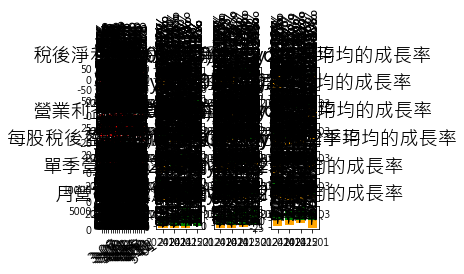

In [3]:
ids = '6438 5269 4979 4583 3661 3645 3264 3029 2472 2395 2374 1815'.split(' ')
for id in ids:
    SF = StockFundamental(id, fig_index = 8, fig_num = 6)
    SF.get_fundamental_table()
    SF.plot_quarterly_Post_TaxPR()
    SF.plot_quarterly_GPR()
    SF.plot_quarterly_OPR()
    SF.plot_quarterly_EPS()
    SF.plot_quarterly_revenue()
    SF.month_revenue()
    SF.get_score()

### 修改用

In [ ]:
# 月營收
class StockFundamental():
    def __init__(self, stockID, fig_num = 2, fig_index = 4, latest_quarter_num = -1):
        self.stockID = stockID
        self.fig_index = fig_index
        self.fig_num = fig_num
        self.subfig_num = -1
        self.fsize = 16
        self.fsize2 = 16
        self.latest_quarter_num = latest_quarter_num
        self.fundamental_info = {'EPS': '季每股稅後盈餘(元)', 'GPR': '季毛利率', 'OPR': '季營業利益率', 'Post_TaxPR': '季稅後淨利率', 'Revenue': '季營業收入淨額'}
        self.green_gradient = ['#e0f2f1', '#d0e9e3', '#c0e0d5', '#b0d7c7', '#a0ceb9', '#90c5ab',  
        '#80bc9d', '#70b38f', '#60aa81', '#50a173', '#409865', '#308f57']

        self.score = 0

        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設置字體為微軟正黑體
        plt.rcParams['axes.unicode_minus'] = False  # 解決負號'-'顯示為方塊的問題
        plt.rcParams['font.size'] = self.fsize
    def get_fundamental_table(self):
        quarterly_report_url = f'https://www.cmoney.tw/finance/{self.stockID}/f00041'
        monthly_report_url = f'https://www.cmoney.tw/finance/{self.stockID}/f00029?o=1'
        driver.get(quarterly_report_url)
        self.quarterly_report_table = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="MainContent"]/ul/li/article/div[2]/div/table'))).text
        print('get quarterly report table', end='  |  ')
        # self.quarterly_report_table = driver.find_element(by = By.XPATH, value = '//*[@id="MainContent"]/ul/li/article/div[2]/div/table').text

        self.quarterly_report_table = pd.DataFrame([line.split(' ') for line in self.quarterly_report_table.split('\n')])
        self.quarterly_report_table.set_index(0, inplace=True)
        self.quarterly_report_table = self.quarterly_report_table.replace(',', '', regex=True).transpose().set_index('年季', drop=True).astype(float)
        self.quarterly_report_table['毛利率'] = 100*self.quarterly_report_table['營業毛利']/self.quarterly_report_table['營業收入淨額']
        self.quarterly_report_table['營業利益率'] = 100*self.quarterly_report_table['營業利益']/self.quarterly_report_table['營業收入淨額']
        self.quarterly_report_table['稅後淨利率'] = 100*self.quarterly_report_table['稅後純益']/self.quarterly_report_table['營業收入淨額']

        

        self.name = driver.find_element(by=By.XPATH, value='//*[@id="HeaderContent"]/h2').text
        driver.get(monthly_report_url)
        self.monthly_report_table = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="MainContent"]/ul/li[4]/article/div/div/div/table'))).text
        print('get monthly report table')
        # self.monthly_report_table = driver.find_element(by = By.XPATH, value = '//*[@id="MainContent"]/ul/li[4]/article/div/div/div/table').text
        self.monthly_report_table = pd.DataFrame([line.split(' ') for line in self.monthly_report_table.split('\n')]).transpose()
        self.monthly_report_table.set_index(0, inplace=True)
        self.monthly_report_table = self.monthly_report_table.replace(',', '', regex=True).replace('--', '0', regex=True).transpose().set_index('年月', drop=True).astype(float)
        # print(name)
        # display(self.quarterly_report_table)
        # print(self.monthly_report_table)
    def plot_quarterly_Post_TaxPR(self, n_quarters = 8):
        self.subfig_num+=1
        Post_TaxPR_df = self.quarterly_report_table.loc[:, ['營業收入淨額', '稅後淨利率']]
        Post_TaxPR_df['稅後淨利率yoy'] = [round(100*(Post_TaxPR_df.iloc[i, 1]-Post_TaxPR_df.iloc[i+4, 1])/abs(Post_TaxPR_df.iloc[i+4, 1]), 2) if i<4 else 0 for i in range(8)]
        Post_TaxPR_df['稅後淨利率yoy2季平均'] = [round(((Post_TaxPR_df.iloc[i,2] + Post_TaxPR_df.iloc[i+1, 2])/2), 2) if i<3 else Post_TaxPR_df.iloc[i, 2] for i in range(8)]
        Post_TaxPR_df['稅後淨利率yoy2季平均的成長率'] = [round((Post_TaxPR_df.iloc[i, 3] - Post_TaxPR_df.iloc[i+1, 3]), 2) if i<3 else Post_TaxPR_df.iloc[i, 3] for i in range(8)]

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = Post_TaxPR_df.index.values[:8][::-1], Post_TaxPR_df['稅後淨利率'].values[:8][::-1]
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(3, y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(2, y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=0)
        plt.title(f'稅後淨利率({latest_quarter})')
        

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = Post_TaxPR_df.index.values[:4][::-1], Post_TaxPR_df['稅後淨利率yoy'].values[:4][::-1]
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('稅後淨利率yoy')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = Post_TaxPR_df.index.values[:4][::-1], Post_TaxPR_df['稅後淨利率yoy2季平均'].values[:4][::-1]
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('稅後淨利率yoy2季平均')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = Post_TaxPR_df.index.values[:4][::-1], Post_TaxPR_df['稅後淨利率yoy2季平均的成長率'].values[:4][::-1]
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('稅後淨利率yoy2季平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        # 紀錄資料
        self.fundamental_info['Post_TaxPR'] = round(latest_quarter_value, 2)
    def plot_quarterly_GPR(self, n_quarters = 8):
        self.subfig_num+=1
        GPR_df = self.quarterly_report_table.loc[:, ['營業收入淨額', '毛利率']]
        GPR_df['毛利率yoy'] = [round(100*(GPR_df.iloc[i, 1]-GPR_df.iloc[i+4, 1])/abs(GPR_df.iloc[i+4, 1]), 2) if i<4 else 0 for i in range(8)]
        GPR_df['毛利率yoy2季平均'] = [round(((GPR_df.iloc[i, 2] + GPR_df.iloc[i+1, 2])/2), 2) if i<3 else GPR_df.iloc[i, 2] for i in range(8)]
        GPR_df['毛利率yoy2季平均的成長率'] = [round((GPR_df.iloc[i, 3] - GPR_df.iloc[i+1, 3]), 2) if i<3 else GPR_df.iloc[i, 3] for i in range(8)]
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = GPR_df.index.values[:8][::-1], GPR_df['毛利率'].values[:8][::-1]
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(3, y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(2, y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=0)
        plt.title('毛利率')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = GPR_df.index.values[:4][::-1], GPR_df['毛利率yoy'].values[:4][::-1]
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title(f'毛利率yoy({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = GPR_df.index.values[:4][::-1], GPR_df['毛利率yoy2季平均'].values[:4][::-1]
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('毛利率yoy2季平均')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = GPR_df.index.values[:4][::-1], GPR_df['毛利率yoy2季平均的成長率'].values[:4][::-1]
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('毛利率yoy2季平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        # 紀錄資料
        self.fundamental_info['GPR'] = round(latest_quarter_value, 2)
    def plot_quarterly_OPR(self, n_quarters = 8):
        self.subfig_num+=1
        OPR_df = self.quarterly_report_table.loc[:, ['營業收入淨額', '營業利益率']]
        OPR_df['營業利益率yoy'] = [round(100*(OPR_df.iloc[i, 1]-OPR_df.iloc[i+4, 1])/abs(OPR_df.iloc[i+4, 1]), 2) if i<4 else 0 for i in range(8)]
        OPR_df['營業利益率yoy2季平均'] = [round(((OPR_df.iloc[i, 2] + OPR_df.iloc[i+1, 2])/2), 2) if i<3 else OPR_df.iloc[i, 2] for i in range(8)]
        OPR_df['營業利益率yoy2季平均的成長率'] = [round((OPR_df.iloc[i, 3] - OPR_df.iloc[i+1, 3]), 2) if i<3 else OPR_df.iloc[i, 3] for i in range(8)]

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = OPR_df.index.values[:8][::-1], OPR_df['營業利益率'].values[:8][::-1]
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(3, y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(2, y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=0)
        plt.title(f'營業利益率({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = OPR_df.index.values[:4][::-1], OPR_df['營業利益率yoy'].values[:4][::-1]
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營業利益率yoy')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = OPR_df.index.values[:4][::-1], OPR_df['營業利益率yoy2季平均'].values[:4][::-1]
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營業利益率yoy2季平均')


        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = OPR_df.index.values[:4][::-1], OPR_df['營業利益率yoy2季平均的成長率'].values[:4][::-1]
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營業利益率yoy2季平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        # 紀錄資料
        self.fundamental_info['OPR'] = round(latest_quarter_value, 2)
    def plot_quarterly_EPS(self, n_quarters = 8):
        self.subfig_num+=1
        EPS_df = self.quarterly_report_table.loc[:, ['營業收入淨額', '每股稅後盈餘(元)']]
        EPS_df['每股稅後盈餘(元)yoy'] = [round(100*(EPS_df.iloc[i, 1]-EPS_df.iloc[i+4, 1])/abs(EPS_df.iloc[i+4, 1]), 2) if i<4 else 0 for i in range(8)]
        EPS_df['每股稅後盈餘(元)yoy2季平均'] = [round(((EPS_df.iloc[i, 2] + EPS_df.iloc[i+1, 2])/2), 2) if i<3 else EPS_df.iloc[i, 2] for i in range(8)]
        EPS_df['每股稅後盈餘(元)yoy2季平均的成長率'] = [round((EPS_df.iloc[i, 3] - EPS_df.iloc[i+1, 3]), 2) if i<3 else EPS_df.iloc[i, 3] for i in range(8)]

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = EPS_df.index.values[:8][::-1], EPS_df['每股稅後盈餘(元)'].values[:8][::-1]
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.2f' % b}", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(3, y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(2, y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=0)
        plt.title(f'每股稅後盈餘(元)({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = EPS_df.index.values[:4][::-1], EPS_df['每股稅後盈餘(元)yoy'].values[:4][::-1]
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90) 
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('每股稅後盈餘(元)yoy')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = EPS_df.index.values[:4][::-1], EPS_df['每股稅後盈餘(元)yoy2季平均'].values[:4][::-1]
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('每股稅後盈餘(元)yoy2季平均')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = EPS_df.index.values[:4][::-1], EPS_df['每股稅後盈餘(元)yoy2季平均的成長率'].values[:4][::-1]
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('每股稅後盈餘(元)yoy2季平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        # 紀錄資料
        self.fundamental_info['EPS'] = round(latest_quarter_value, 2)
    def plot_quarterly_revenue(self, n_quarters = 8):
        self.subfig_num+=1
        quarterly_df = self.quarterly_report_table.loc[:, ['每股稅後盈餘(元)', '營業收入淨額']]
        quarterly_df['單季年增率'] = [round(100*(quarterly_df.iloc[i, 1]-quarterly_df.iloc[i+4, 1])/abs(quarterly_df.iloc[i+4, 1]), 2) if i<4 else 0 for i in range(len(quarterly_df.index.values))]
        quarterly_df['營收yoy2季平均'] = [round(((quarterly_df.iloc[i, 2] + quarterly_df.iloc[i+1, 2])/2), 2) if i<3 else quarterly_df.iloc[i, 2] for i in range(len(quarterly_df.index.values))]
        quarterly_df['營收yoy2季平均的成長率'] = [round((quarterly_df.iloc[i, 3] - quarterly_df.iloc[i+1, 3]), 2) if i<3 else quarterly_df.iloc[i, 3] for i in range(len(quarterly_df.index.values))]
        
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = quarterly_df.index.values[:8][::-1], quarterly_df['營業收入淨額'].values[:8][::-1]
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.1f' % b}k", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(3, y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(2, y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=0)
        plt.title(f'單季營收({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = quarterly_df.index.values[:4][::-1], quarterly_df['單季年增率'].values[:4][::-1]
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('單季年增率')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = quarterly_df.index.values[:4][::-1], quarterly_df['營收yoy2季平均'].values[:4][::-1]
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營收yoy2季平均')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = quarterly_df.index.values[:4][::-1], quarterly_df['營收yoy2季平均的成長率'].values[:4][::-1]
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營收yoy2季平均的成長率')  

        # 紀錄資料
        self.fundamental_info['Revenue'] = round(latest_quarter_value, 2)
    def month_revenue(self, n_months = 8):
        self.subfig_num+=1
        monthly_df = self.monthly_report_table
        monthly_df['營收yoy2月平均'] = [round(((monthly_df.iloc[i, 2] + monthly_df.iloc[i+1, 2])/2), 2) if i<15 else monthly_df.iloc[i, 2] for i in range(len(monthly_df.index.values))]
        monthly_df['營收yoy2月平均的成長率'] = [round((monthly_df.iloc[i, 7] - monthly_df.iloc[i+1, 7]), 2) if i<15 else monthly_df.iloc[i, 7] for i in range(len(monthly_df.index.values))]
        
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = monthly_df.index.values[:20][::-1], monthly_df['單月營收'].values[:20][::-1]
        latest_month = x1[-1]
        latest_month_value = y1[-1]
        x1 = [d[3:4]+'-'+d[-2:] for d in x1]
        color_sequence = [self.green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.1f' % b}k", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(7, y1[-13]*1.05, color='red', s=100, marker='*')
        plt.scatter(6, y1[-14]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-13], color='red', linestyle='--')
        plt.axhline(y=y1[-14], color='red', linestyle='--')
        plt.xticks(rotation=35, fontsize=self.fsize2-2)
        plt.title(f'月營收({latest_month})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = monthly_df.index.values[:4][::-1], monthly_df['單月年增率'].values[:4][::-1]
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('單月年增率')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = monthly_df.index.values[:4][::-1], monthly_df['營收yoy2月平均'].values[:4][::-1]
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營收yoy2月平均')
        
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = monthly_df.index.values[:4][::-1], monthly_df['營收yoy2月平均的成長率'].values[:4][::-1]
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=0)
        plt.title('營收yoy2月平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1
    def get_score(self):
        print(f'{self.name}的分數: {self.score}/15')
        return self.score

## 新程式(不用爬蟲)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
class bcolors:
    OK = '\033[92m' #GREEN
    WARNING = '\033[93m' #YELLOW
    FAIL = '\033[91m' #RED
    RESET = '\033[0m' #RESET COLOR
financial_statement_path = r'C:\Users\User\Desktop\stockchoose\history_financial_statement_data\financial_statement_data.xlsx'
financial_statement_df = pd.read_excel(financial_statement_path)
print('OK')
monthly_revenue_path = r'C:\Users\User\Desktop\stockchoose\history_month_revenue_data\monthly_revenue_data.xlsx'
monthly_revenue_df = pd.read_excel(monthly_revenue_path)
print('OK')

OK
OK


In [2]:
class StockFundamental():
    def __init__(self, stockID, fig_num = 4, fig_index = 6, latest_quarter_num = -1, initial_time = '2023-01-01', end_time = '2025-01-31', financial_statement_df:pd.DataFrame = None, monthly_revenue_df:pd.DataFrame = None):
        
        self.initial_time = initial_time
        self.end_time = end_time
        self.stockID = stockID

        self.financial_statement_df = financial_statement_df
        # print(self.financial_statement_df)
        self.financial_statement_df['ID'] = financial_statement_df['ID'].astype(str)
        self.financial_statement_df = financial_statement_df.loc[financial_statement_df['ID']==stockID]
        self.financial_statement_df['update_date'] = pd.to_datetime(self.financial_statement_df['update_date'])
        self.financial_statement_df = self.financial_statement_df[self.financial_statement_df['update_date']>=self.initial_time]
        # print(self.financial_statement_df)
        self.financial_statement_df = self.financial_statement_df[self.financial_statement_df['update_date']<=self.end_time]
        # print(self.financial_statement_df)
        self.financial_statement_df['Rev_Q_Y'] = self.financial_statement_df['Rev_Q'].astype(str).apply(lambda x:x+'Q')+self.financial_statement_df['Rev_Y'].astype(str).apply(lambda x:x[-2:])
        # print(self.financial_statement_df)
        self.IAT_df = self.financial_statement_df[['ID','Rev_Q','Rev_Y','Rev_Q_Y','update_date','Y','M','D','IAT','IAT_R','IAT_R_YoY','IAT_R_QoQ','IAT_R_YoY_AVG_2Q','IAT_R_YoY_AVG_2Q_Diff']]
        self.IAT_df = self.IAT_df.set_index('ID')
        self.Q_Rev_df = self.financial_statement_df[['ID','Rev_Q','Rev_Y','Rev_Q_Y','update_date','Y','M','D','Q_Rev','Q_Rev_YoY','Q_Rev_QoQ','Q_Rev_YoY_AVG_2Q','Q_Rev_YoY_AVG_2Q_Diff']]
        self.Q_Rev_df = self.Q_Rev_df.set_index('ID')
        self.EPS_df = self.financial_statement_df[['ID','Rev_Q','Rev_Y','Rev_Q_Y','update_date','Y','M','D','EPS','EPS_YoY','EPS_QoQ','EPS_YoY_AVG_2Q','EPS_YoY_AVG_2Q_Diff']]
        self.EPS_df = self.EPS_df.set_index('ID')
        self.OI_df = self.financial_statement_df[['ID','Rev_Q','Rev_Y','Rev_Q_Y','update_date','Y','M','D','OI','OI_R','OI_R_YoY','OI_R_QoQ','OI_R_YoY_AVG_2Q','OI_R_YoY_AVG_2Q_Diff']]
        self.OI_df = self.OI_df.set_index('ID')
        self.GP_df = self.financial_statement_df[['ID','Rev_Q','Rev_Y','Rev_Q_Y','update_date','Y','M','D','GP','GP_R','GP_R_YoY','GP_R_QoQ','GP_R_YoY_AVG_2Q','GP_R_YoY_AVG_2Q_Diff']]
        self.GP_df = self.GP_df.set_index('ID')
    
        self.monthly_revenue_df = monthly_revenue_df
        self.monthly_revenue_df['ID'] = monthly_revenue_df['ID'].astype(str)
        self.monthly_revenue_df = monthly_revenue_df.loc[monthly_revenue_df['ID']==stockID]
        self.monthly_revenue_df['update_date'] = pd.to_datetime(self.monthly_revenue_df['update_date'])
        self.five_year_monthly_revenue_df = self.monthly_revenue_df[self.monthly_revenue_df['update_date']<=self.end_time]
        self.five_year_monthly_revenue_df = self.five_year_monthly_revenue_df.iloc[-60:]
        self.monthly_revenue_df = self.monthly_revenue_df[self.monthly_revenue_df['update_date']>=self.initial_time]
        self.monthly_revenue_df = self.monthly_revenue_df[self.monthly_revenue_df['update_date']<=self.end_time]
        self.monthly_revenue_df['Rev_M_Y'] = self.monthly_revenue_df['Rev_M'].astype(str).apply(lambda x:x+'M')+self.monthly_revenue_df['Rev_Y'].astype(str).apply(lambda x:x[-2:])
        self.monthly_revenue_df = self.monthly_revenue_df.set_index('ID')
        # print(self.monthly_revenue_df)


        self.fig_index = fig_index
        self.fig_num = fig_num
        self.subfig_num = -1
        self.fsize = 16
        self.fsize2 = 16
        self.latest_quarter_num = latest_quarter_num

        self.fundamental_info = {'EPS': '季每股稅後盈餘(元)', 'GPR': '季毛利率', 'OPR': '季營業利益率', 'Post_TaxPR': '季稅後淨利率', 'Revenue': '季營業收入淨額'}
        self.monthly_green_gradient = ['#e0f2f1', '#d0e9e3', '#c0e0d5', '#b0d7c7', '#a0ceb9', '#90c5ab',  
        '#80bc9d', '#70b38f', '#60aa81', '#50a173', '#409865', '#308f57']
        self.quarterly_green_gradient = ['#e0f2f1', '#a0ceb9', '#60aa81', '#308f57']
        self.latest_Rev_year = self.financial_statement_df['Rev_Y'].values[-1]
        self.latest_Rev_quarter = self.financial_statement_df['Rev_Q'].values[-1]
        self.latest_Rev_year_for_month = self.monthly_revenue_df['Rev_Y'].values[-1]
        self.latest_Rev_month = self.monthly_revenue_df['Rev_M'].values[-1]
        self.score = 0

        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設置字體為微軟正黑體
        plt.rcParams['axes.unicode_minus'] = False  # 解決負號'-'顯示為方塊的問題
        plt.rcParams['font.size'] = self.fsize
    def plot_quarterly_Post_TaxPR(self, n_quarters = 8):
        self.subfig_num+=1
        
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = self.IAT_df['Rev_Q_Y'], self.IAT_df['IAT_R']
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.quarterly_green_gradient[i % 4] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(x1[-5], y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(x1[-6], y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=35)
        plt.title(f'稅後淨利率({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = self.IAT_df['Rev_Q_Y'], self.IAT_df['IAT_R_YoY']
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('稅後淨利率yoy')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = self.IAT_df['Rev_Q_Y'], self.IAT_df['IAT_R_YoY_AVG_2Q']
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('稅後淨利率yoy2季平均')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = self.IAT_df['Rev_Q_Y'], self.IAT_df['IAT_R_YoY_AVG_2Q_Diff']
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('稅後淨利率yoy2季平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        
        # 紀錄資料
        self.latest_quarter = latest_quarter
        self.fundamental_info['Post_TaxPR'] = round(latest_quarter_value, 2)
    def plot_quarterly_GPR(self, n_quarters = 8):
        self.subfig_num+=1
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = self.GP_df['Rev_Q_Y'], self.GP_df['GP_R']
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.quarterly_green_gradient[i % 4] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(x1[-5], y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(x1[-6], y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=35)
        plt.title('毛利率')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = self.GP_df['Rev_Q_Y'], self.GP_df['GP_R_YoY']
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title(f'毛利率yoy({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = self.GP_df['Rev_Q_Y'], self.GP_df['GP_R_YoY_AVG_2Q']
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('毛利率yoy2季平均')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = self.GP_df['Rev_Q_Y'], self.GP_df['GP_R_YoY_AVG_2Q_Diff']
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('毛利率yoy2季平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        # 紀錄資料
        self.latest_quarter = latest_quarter
        self.fundamental_info['GPR'] = round(latest_quarter_value, 2)
    def plot_quarterly_OPR(self, n_quarters = 8):
        self.subfig_num+=1
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = self.OI_df['Rev_Q_Y'], self.OI_df['OI_R']
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.quarterly_green_gradient[i % 4] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(x1[-5], y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(x1[-6], y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=35)
        plt.title(f'營業利益率({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = self.OI_df['Rev_Q_Y'], self.OI_df['OI_R_YoY']
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('營業利益率yoy')
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = self.OI_df['Rev_Q_Y'], self.OI_df['OI_R_YoY_AVG_2Q']
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('營業利益率yoy2季平均')


        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = self.OI_df['Rev_Q_Y'], self.OI_df['OI_R_YoY_AVG_2Q_Diff']
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('營業利益率yoy2季平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        # 紀錄資料
        self.latest_quarter = latest_quarter
        self.fundamental_info['OPR'] = round(latest_quarter_value, 2)
    def plot_quarterly_EPS(self, n_quarters = 8):
        self.subfig_num+=1
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = self.EPS_df['Rev_Q_Y'], self.EPS_df['EPS']
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.quarterly_green_gradient[i % 4] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.2f' % b}", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(x1[-5], y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(x1[-6], y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=35)
        plt.title(f'每股稅後盈餘(元)({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = self.EPS_df['Rev_Q_Y'], self.EPS_df['EPS_YoY']
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90) 
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('每股稅後盈餘(元)yoy')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = self.EPS_df['Rev_Q_Y'], self.EPS_df['EPS_YoY_AVG_2Q']
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('每股稅後盈餘(元)yoy2季平均')
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = self.EPS_df['Rev_Q_Y'], self.EPS_df['EPS_YoY_AVG_2Q_Diff']
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.2f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('每股稅後盈餘(元)yoy2季平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        # 紀錄資料
        self.latest_quarter = latest_quarter
        self.fundamental_info['EPS'] = round(latest_quarter_value, 2)
    def plot_quarterly_revenue(self, n_quarters = 8):
        self.subfig_num+=1
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = self.Q_Rev_df['Rev_Q_Y'], self.Q_Rev_df['Q_Rev']/1000
        latest_quarter = x1[-1]
        latest_quarter_value = y1[self.latest_quarter_num]
        color_sequence = [self.quarterly_green_gradient[i % 4] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.1f' % b}k", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(x1[-5], y1[-5]*1.05, color='red', s=100, marker='*')
        plt.scatter(x1[-6], y1[-6]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-5], color='red', linestyle='--')
        plt.axhline(y=y1[-6], color='red', linestyle='--')
        plt.xticks(rotation=35)
        plt.title(f'單季營收({latest_quarter})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = self.Q_Rev_df['Rev_Q_Y'], self.Q_Rev_df['Q_Rev_YoY']
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('單季年增率')
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = self.Q_Rev_df['Rev_Q_Y'], self.Q_Rev_df['Q_Rev_YoY_AVG_2Q']
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('營收yoy2季平均')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = self.Q_Rev_df['Rev_Q_Y'], self.Q_Rev_df['Q_Rev_YoY_AVG_2Q_Diff']
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('營收yoy2季平均的成長率')  

        # 紀錄資料
        self.latest_quarter = latest_quarter
        self.fundamental_info['Revenue'] = round(latest_quarter_value, 2)
    def month_revenue(self, n_months = 8):
        self.subfig_num+=1
        if self.monthly_revenue_df.shape[0] > 24:
            self.monthly_revenue_df = self.monthly_revenue_df.iloc[-24:]

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+1)
        x1, y1 = self.monthly_revenue_df['Rev_M_Y'], self.monthly_revenue_df['M_Rev']/1000000
        latest_month = x1[-1]
        color_sequence = [self.monthly_green_gradient[i % 12] for i in range(len(y1))]
        for a,b in zip(x1,y1):
            plt.text(a, b/2, f"{'%.1f' % b}M", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x1, y1, color=color_sequence)
        # plot a star on the last month
        plt.scatter(x1[-13], y1[-13]*1.05, color='red', s=100, marker='*')
        plt.scatter(x1[-14], y1[-14]*1.05, color='red', s=100, marker='*')
        # plot a horizontal line on the last month
        plt.axhline(y=y1[-13], color='red', linestyle='--')
        plt.axhline(y=y1[-14], color='red', linestyle='--')
        plt.xticks(rotation=35, fontsize=self.fsize2-2)
        plt.title(f'月營收({latest_month})')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+2)
        x2, y2 = self.monthly_revenue_df['Rev_M_Y'], self.monthly_revenue_df['M_Rev_YoY']*100
        color_sequence = np.where(y2 >= 0, 'g', 'orange')
        for a,b in zip(x2,y2):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x2, y2, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('單月年增率')

        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+3)
        x3, y3 = self.monthly_revenue_df['Rev_M_Y'], self.monthly_revenue_df['M_Rev_YoY_AVG_2M']*100
        color_sequence = np.where(y3 >= 0, 'g', 'orange')
        for a,b in zip(x3,y3):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x3, y3, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('營收yoy2月平均')
        
        plt.subplot(self.fig_index,self.fig_num,self.fig_num*self.subfig_num+4)
        x4, y4 = self.monthly_revenue_df['Rev_M_Y'], self.monthly_revenue_df['M_Rev_YoY_AVG_2M_Diff']*100
        color_sequence = np.where(y4 >= 0, 'g', 'orange')
        for a,b in zip(x4,y4):
            plt.text(a, b/2, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=self.fsize2, rotation=90)
        plt.bar(x4, y4, color=color_sequence)
        plt.xticks(rotation=35)
        plt.title('營收yoy2月平均的成長率')

        if y2[-1] > 0:
            self.score+=1
        if y3[-1] > 0:
            self.score+=1
        if y4[-1] > 0:
            self.score+=1

        # 紀錄資料
        self.latest_month = latest_month
    def get_revenue_score(self):
        revenue_score = 0
        Is_five_years_highest_revenue = self.five_year_monthly_revenue_df['M_Rev'].max() == self.five_year_monthly_revenue_df['M_Rev'].values[-1]
        specific_month_revenue = self.five_year_monthly_revenue_df.loc[self.five_year_monthly_revenue_df['Rev_M'] == self.latest_Rev_month]
        Is_five_years_highest_revenue_month = specific_month_revenue['M_Rev'].max() == specific_month_revenue['M_Rev'].values[-1]
        M_Rev_yoy_higher_than_20 = self.monthly_revenue_df['M_Rev_YoY'].values[-1] > 0.2
        M_Rev_yoy_higher_than_25 = self.monthly_revenue_df['M_Rev_YoY'].values[-1] > 0.25
        M_Rev_yoy_higher_than_100 = self.monthly_revenue_df['M_Rev_YoY'].values[-1] > 1
        M_Rev_from_negative_to_positive = self.monthly_revenue_df['M_Rev'].values[-2] < 0 and self.monthly_revenue_df['M_Rev'].values[-1] > 0
        M_Rev_yoy_from_3M_negative_to_positive = all(self.monthly_revenue_df['M_Rev_YoY'].values[-4:-1] < 0) and self.monthly_revenue_df['M_Rev_YoY'].values[-1] > 0
        
        if any([Is_five_years_highest_revenue, M_Rev_yoy_higher_than_100, M_Rev_from_negative_to_positive]):
            revenue_score = 3
        elif Is_five_years_highest_revenue_month:
            revenue_score = 2
        elif any([M_Rev_yoy_higher_than_25, M_Rev_yoy_from_3M_negative_to_positive]):
            revenue_score = 1
        elif M_Rev_yoy_higher_than_20:
            revenue_score = 0.5

        return revenue_score
    def get_score(self):
        text = f'{self.stockID}的分數({self.latest_Rev_year}Q{self.latest_Rev_quarter} | {self.latest_Rev_year_for_month}M{self.latest_Rev_month}): {self.score}/15'
        print(text)
        return text
    

# plt.figure(figsize=(60, 40))
# stock2330 = StockFundamental(stockID='2330', financial_statement_df=financial_statement_df, monthly_revenue_df=monthly_revenue_df, initial_time = '2022-1-1', end_time = '2025-1-31')
# stock2330.plot_quarterly_Post_TaxPR()
# stock2330.plot_quarterly_GPR()
# stock2330.plot_quarterly_OPR()
# stock2330.plot_quarterly_EPS()
# stock2330.plot_quarterly_revenue()
# stock2330.month_revenue()
# stock2330.get_score()
# plt.show()

### 單一個股基本面

In [ ]:
SF = StockFundamental(stockID='3661', financial_statement_df=financial_statement_df, monthly_revenue_df=monthly_revenue_df, initial_time = '2023-05-20', end_time = '2025-02-28')
print(f'{SF.stockID}基本面分析')
plt.figure(figsize=(60, 40))
SF.plot_quarterly_Post_TaxPR()
SF.plot_quarterly_GPR()
SF.plot_quarterly_OPR()
SF.plot_quarterly_EPS()
SF.plot_quarterly_revenue()
SF.month_revenue()
SF.get_score()
plt.show()

### 族群基本面

C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.financial_statement_df['update_date'] = pd.to_datetime(self.financial_statement_df['update_date'])
C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.monthly_revenue_df['update_date'] = pd.to_datetime(self.monthly_revenue_df['update_date'])


2049基本面分析
2049營收分數: 0
2049的分數(2024Q3 | 2025M1): 8/15


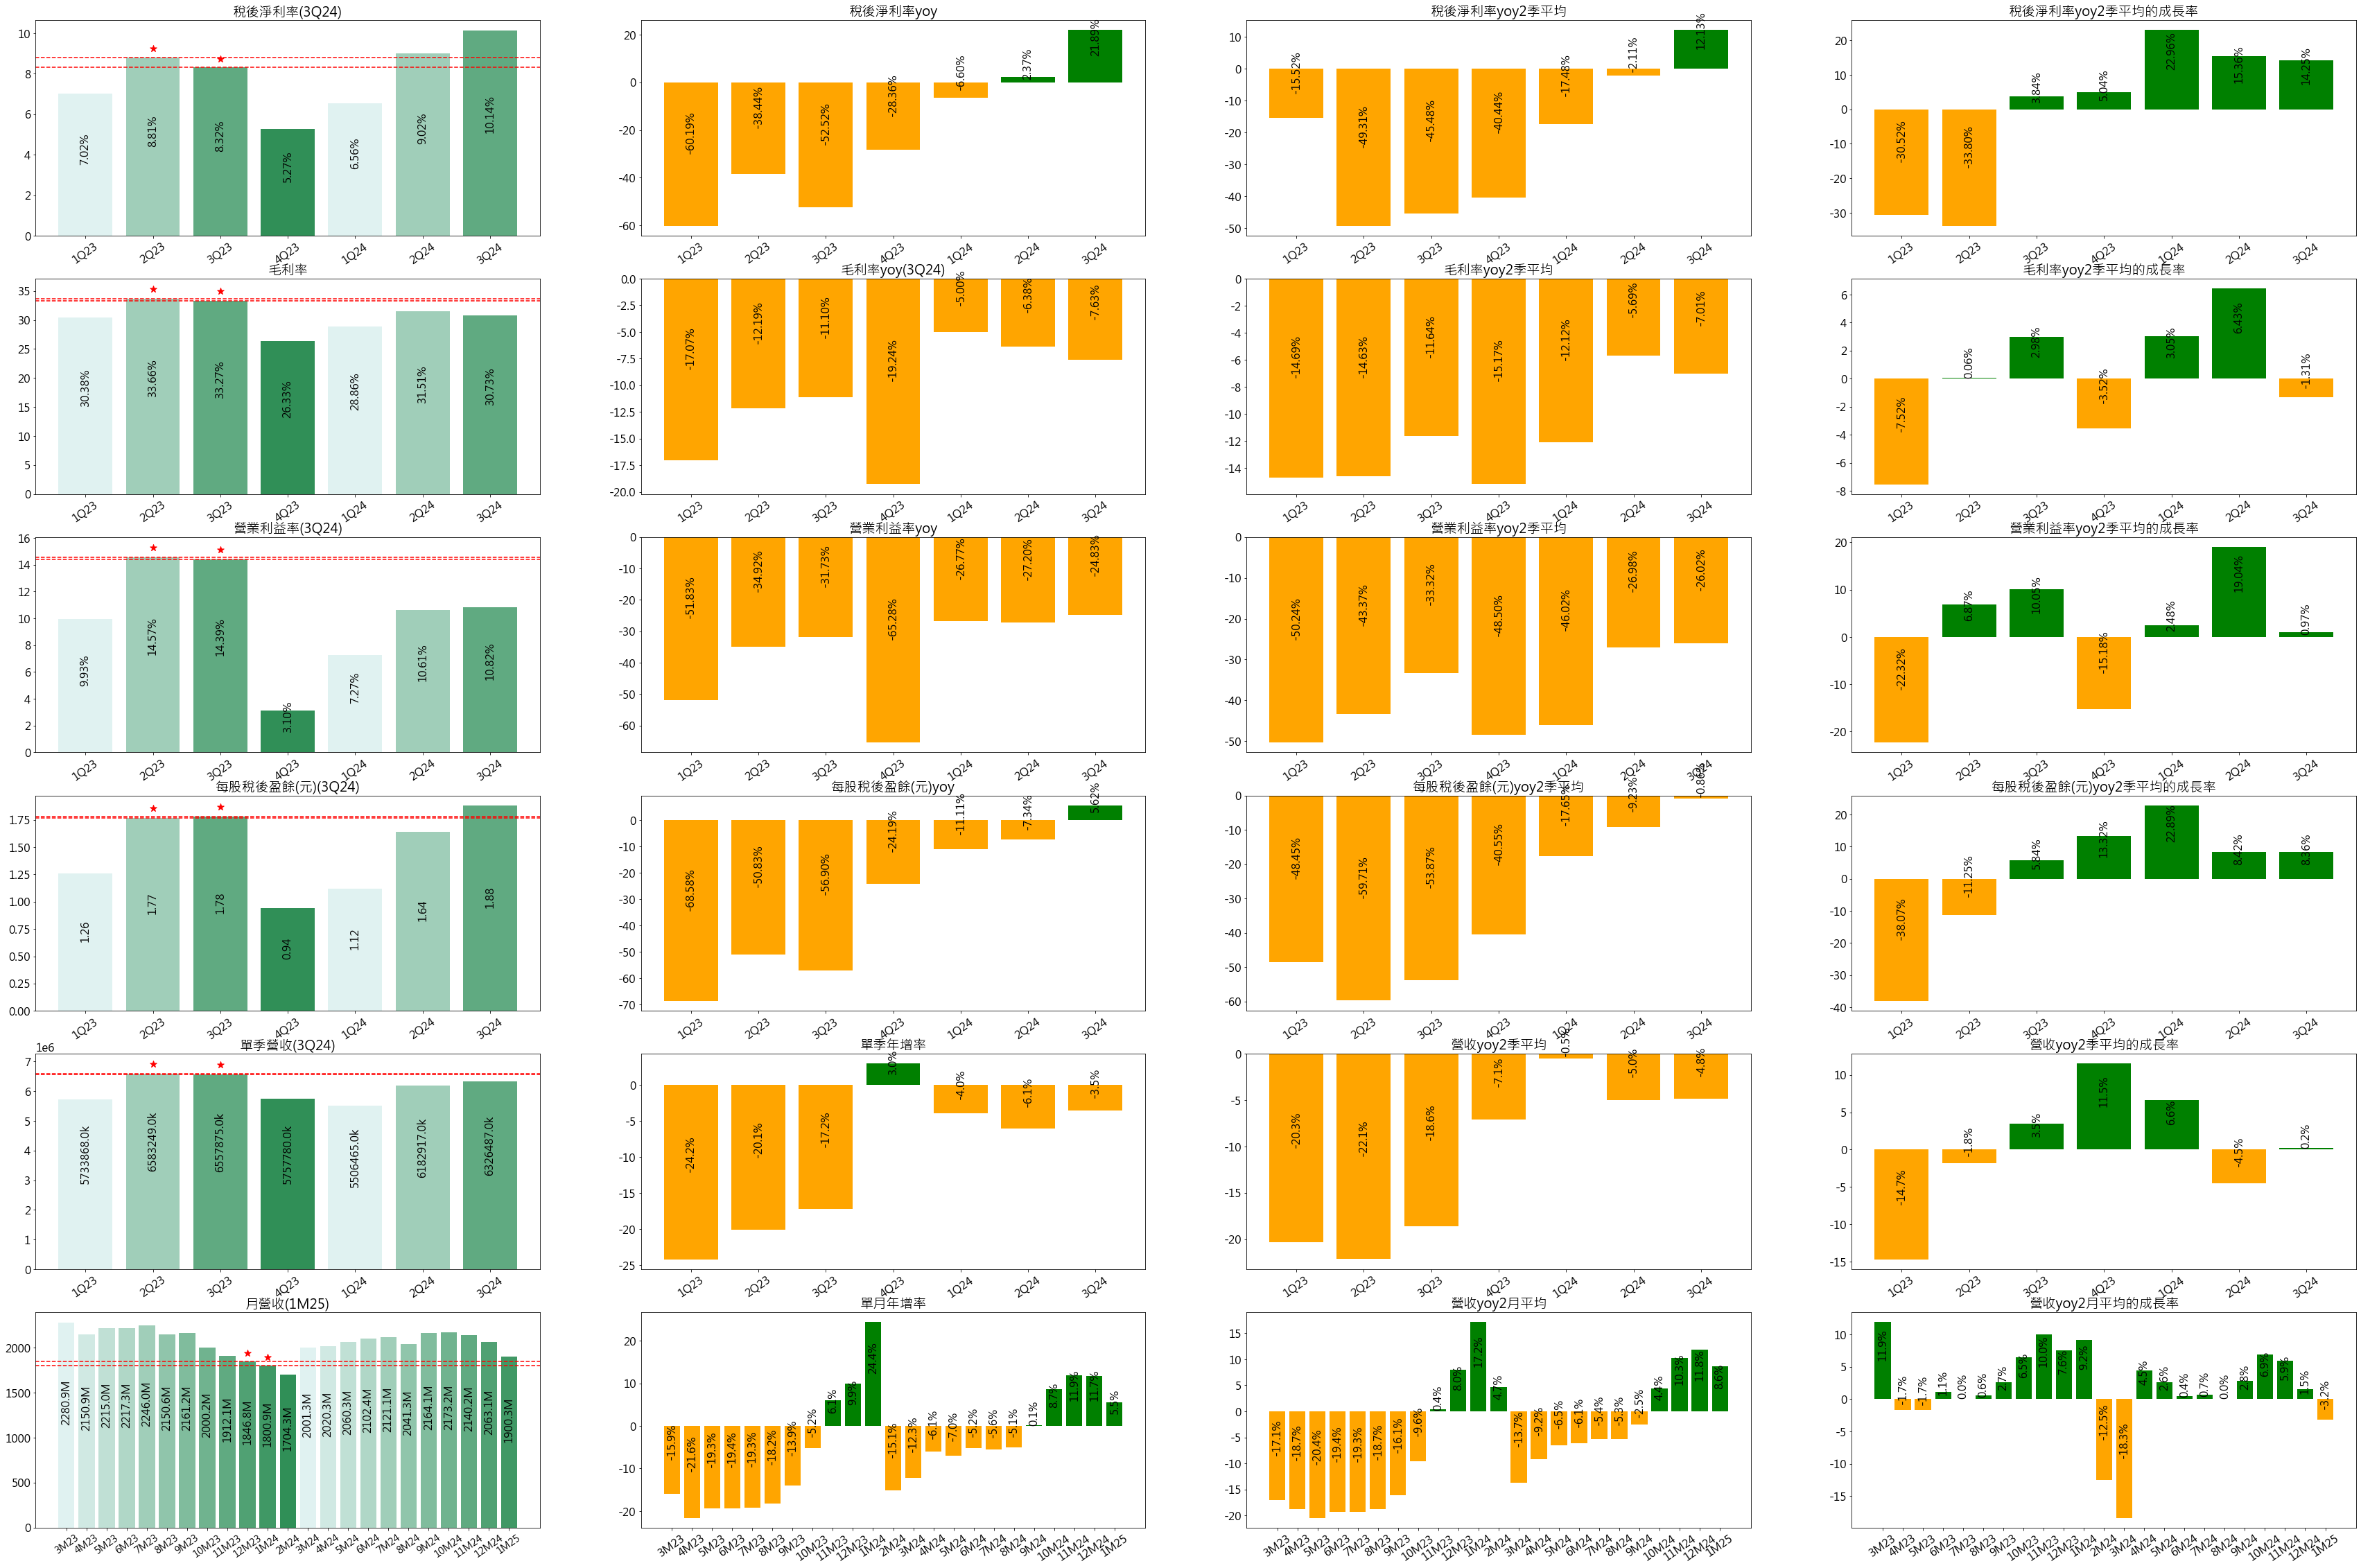

C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.financial_statement_df['update_date'] = pd.to_datetime(self.financial_statement_df['update_date'])
C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.monthly_revenue_df['update_date'] = pd.to_datetime(self.monthly_revenue_df['update_date'])


2374基本面分析
2374營收分數: 2
2374的分數(2024Q3 | 2025M1): 8/15


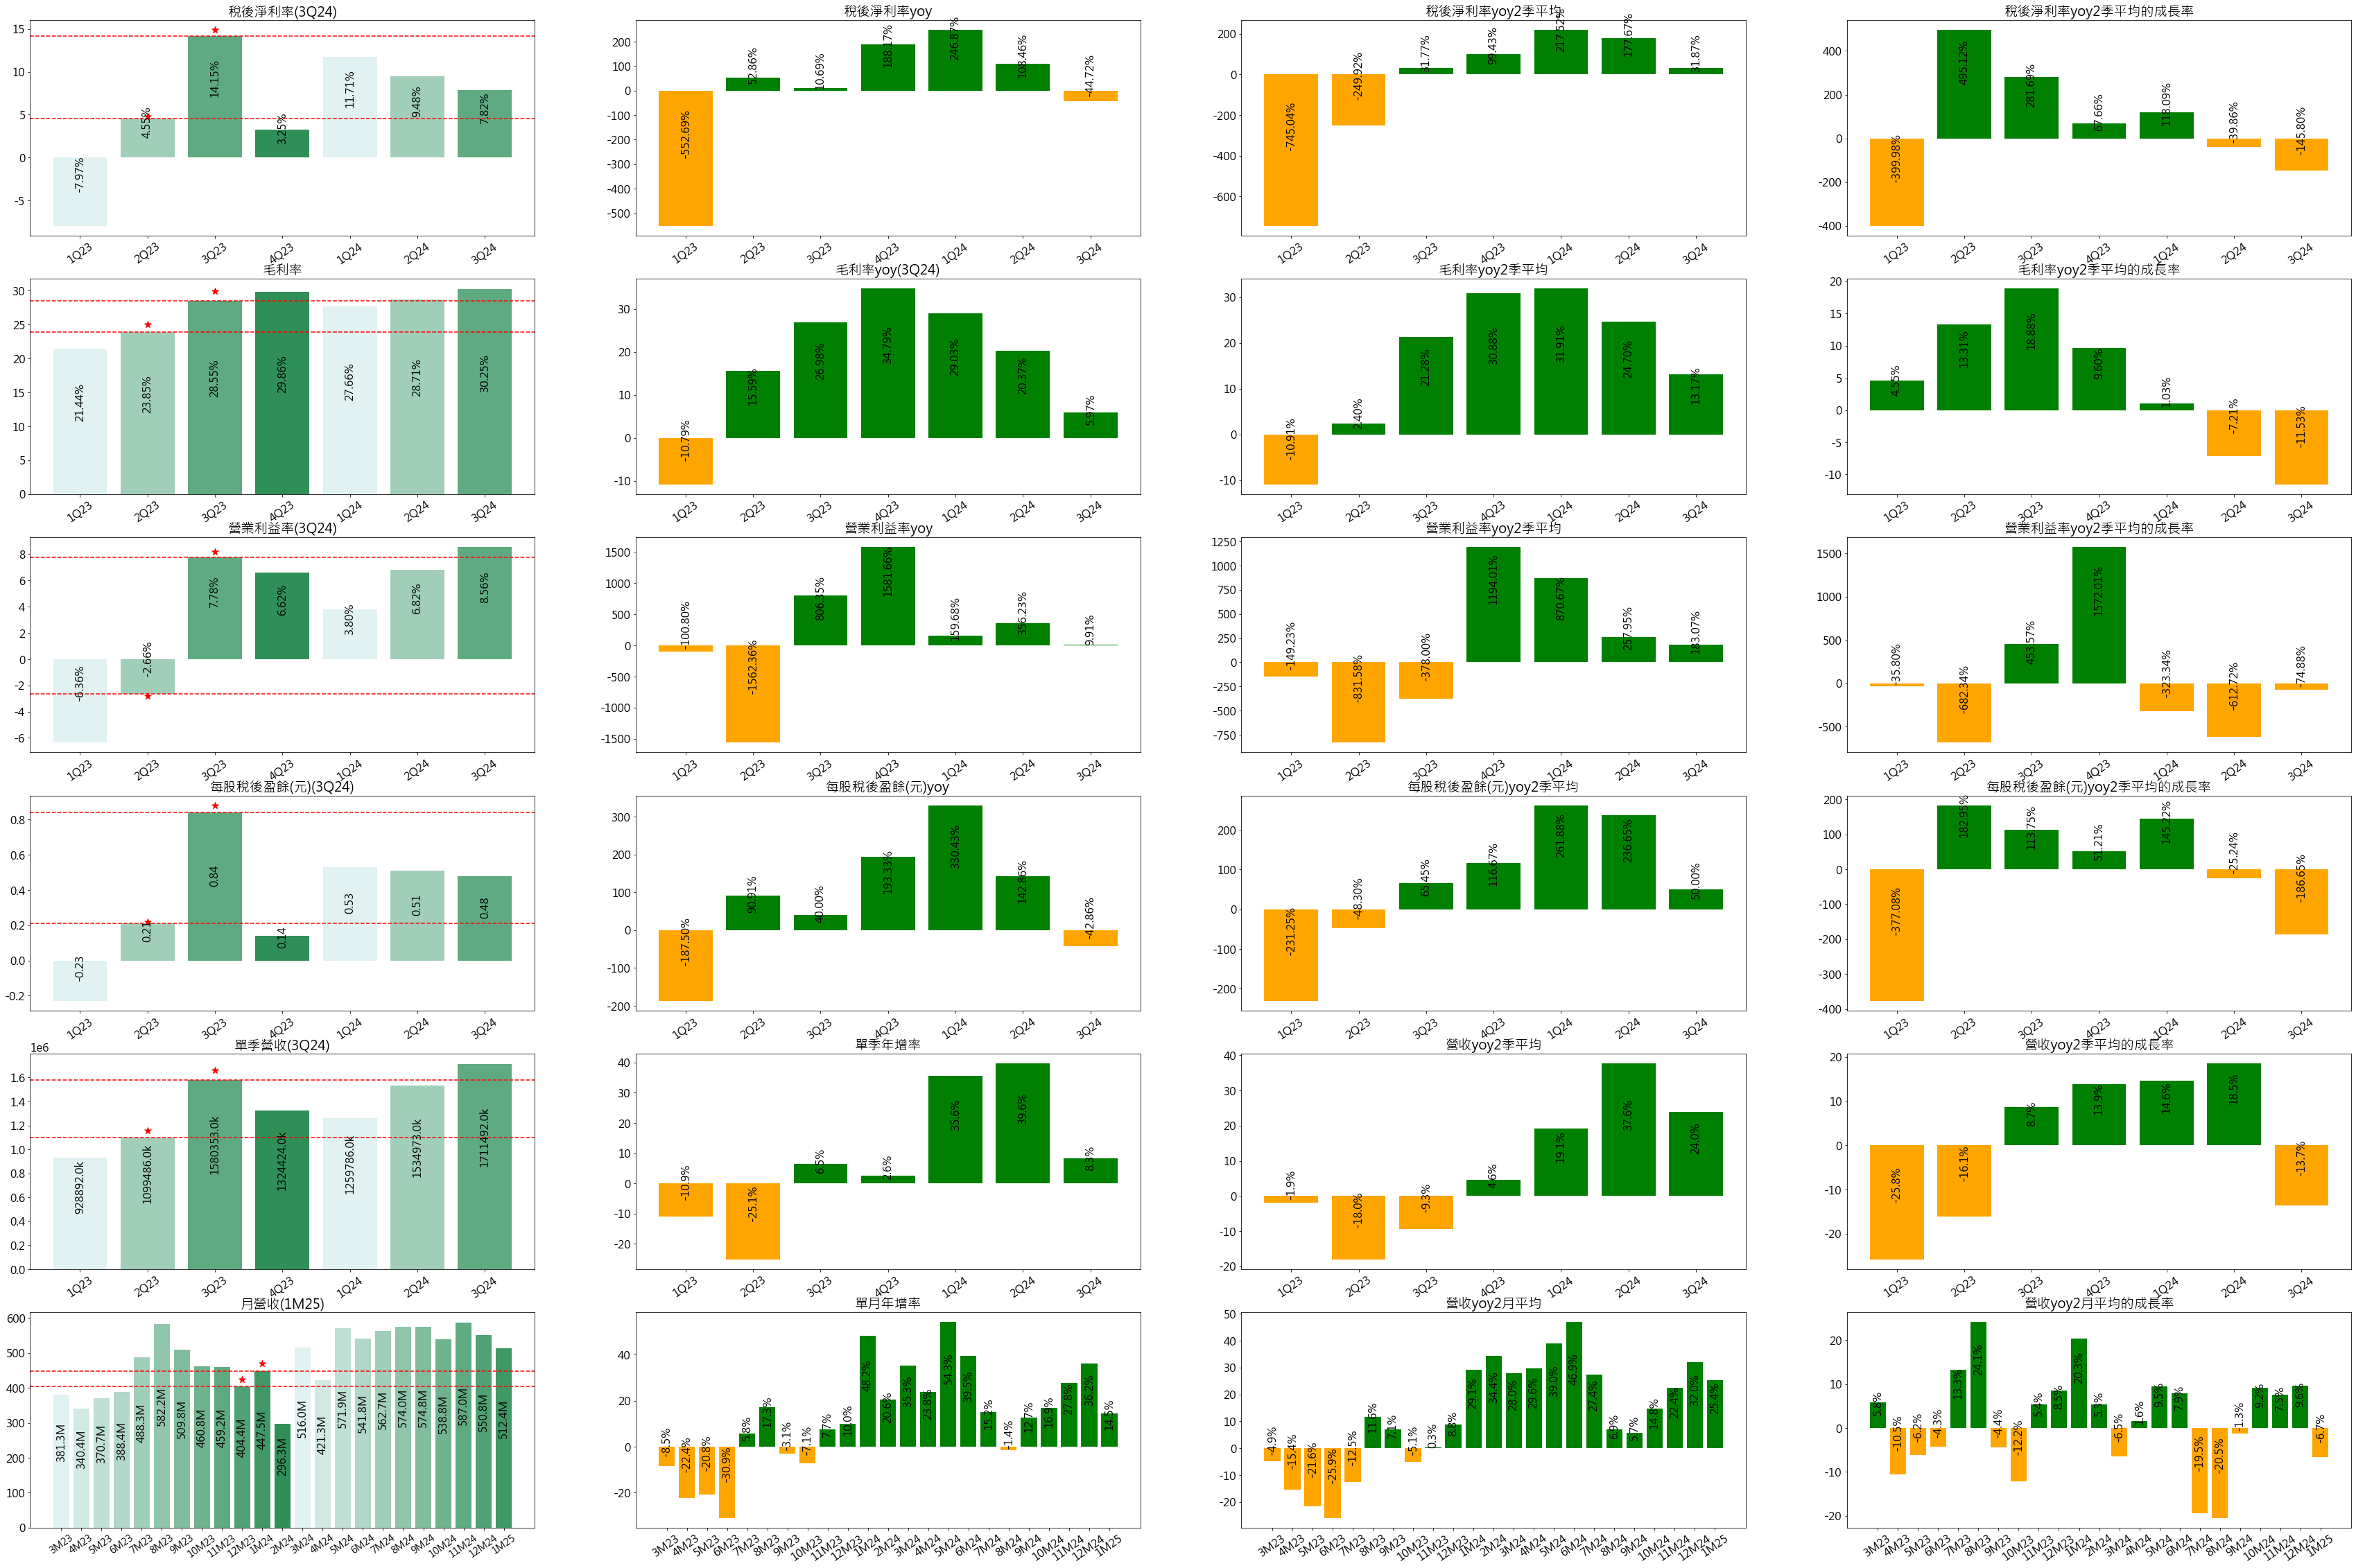

C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.financial_statement_df['update_date'] = pd.to_datetime(self.financial_statement_df['update_date'])
C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.monthly_revenue_df['update_date'] = pd.to_datetime(self.monthly_revenue_df['update_date'])


6215基本面分析
6215營收分數: 1
6215的分數(2024Q3 | 2025M1): 14/15


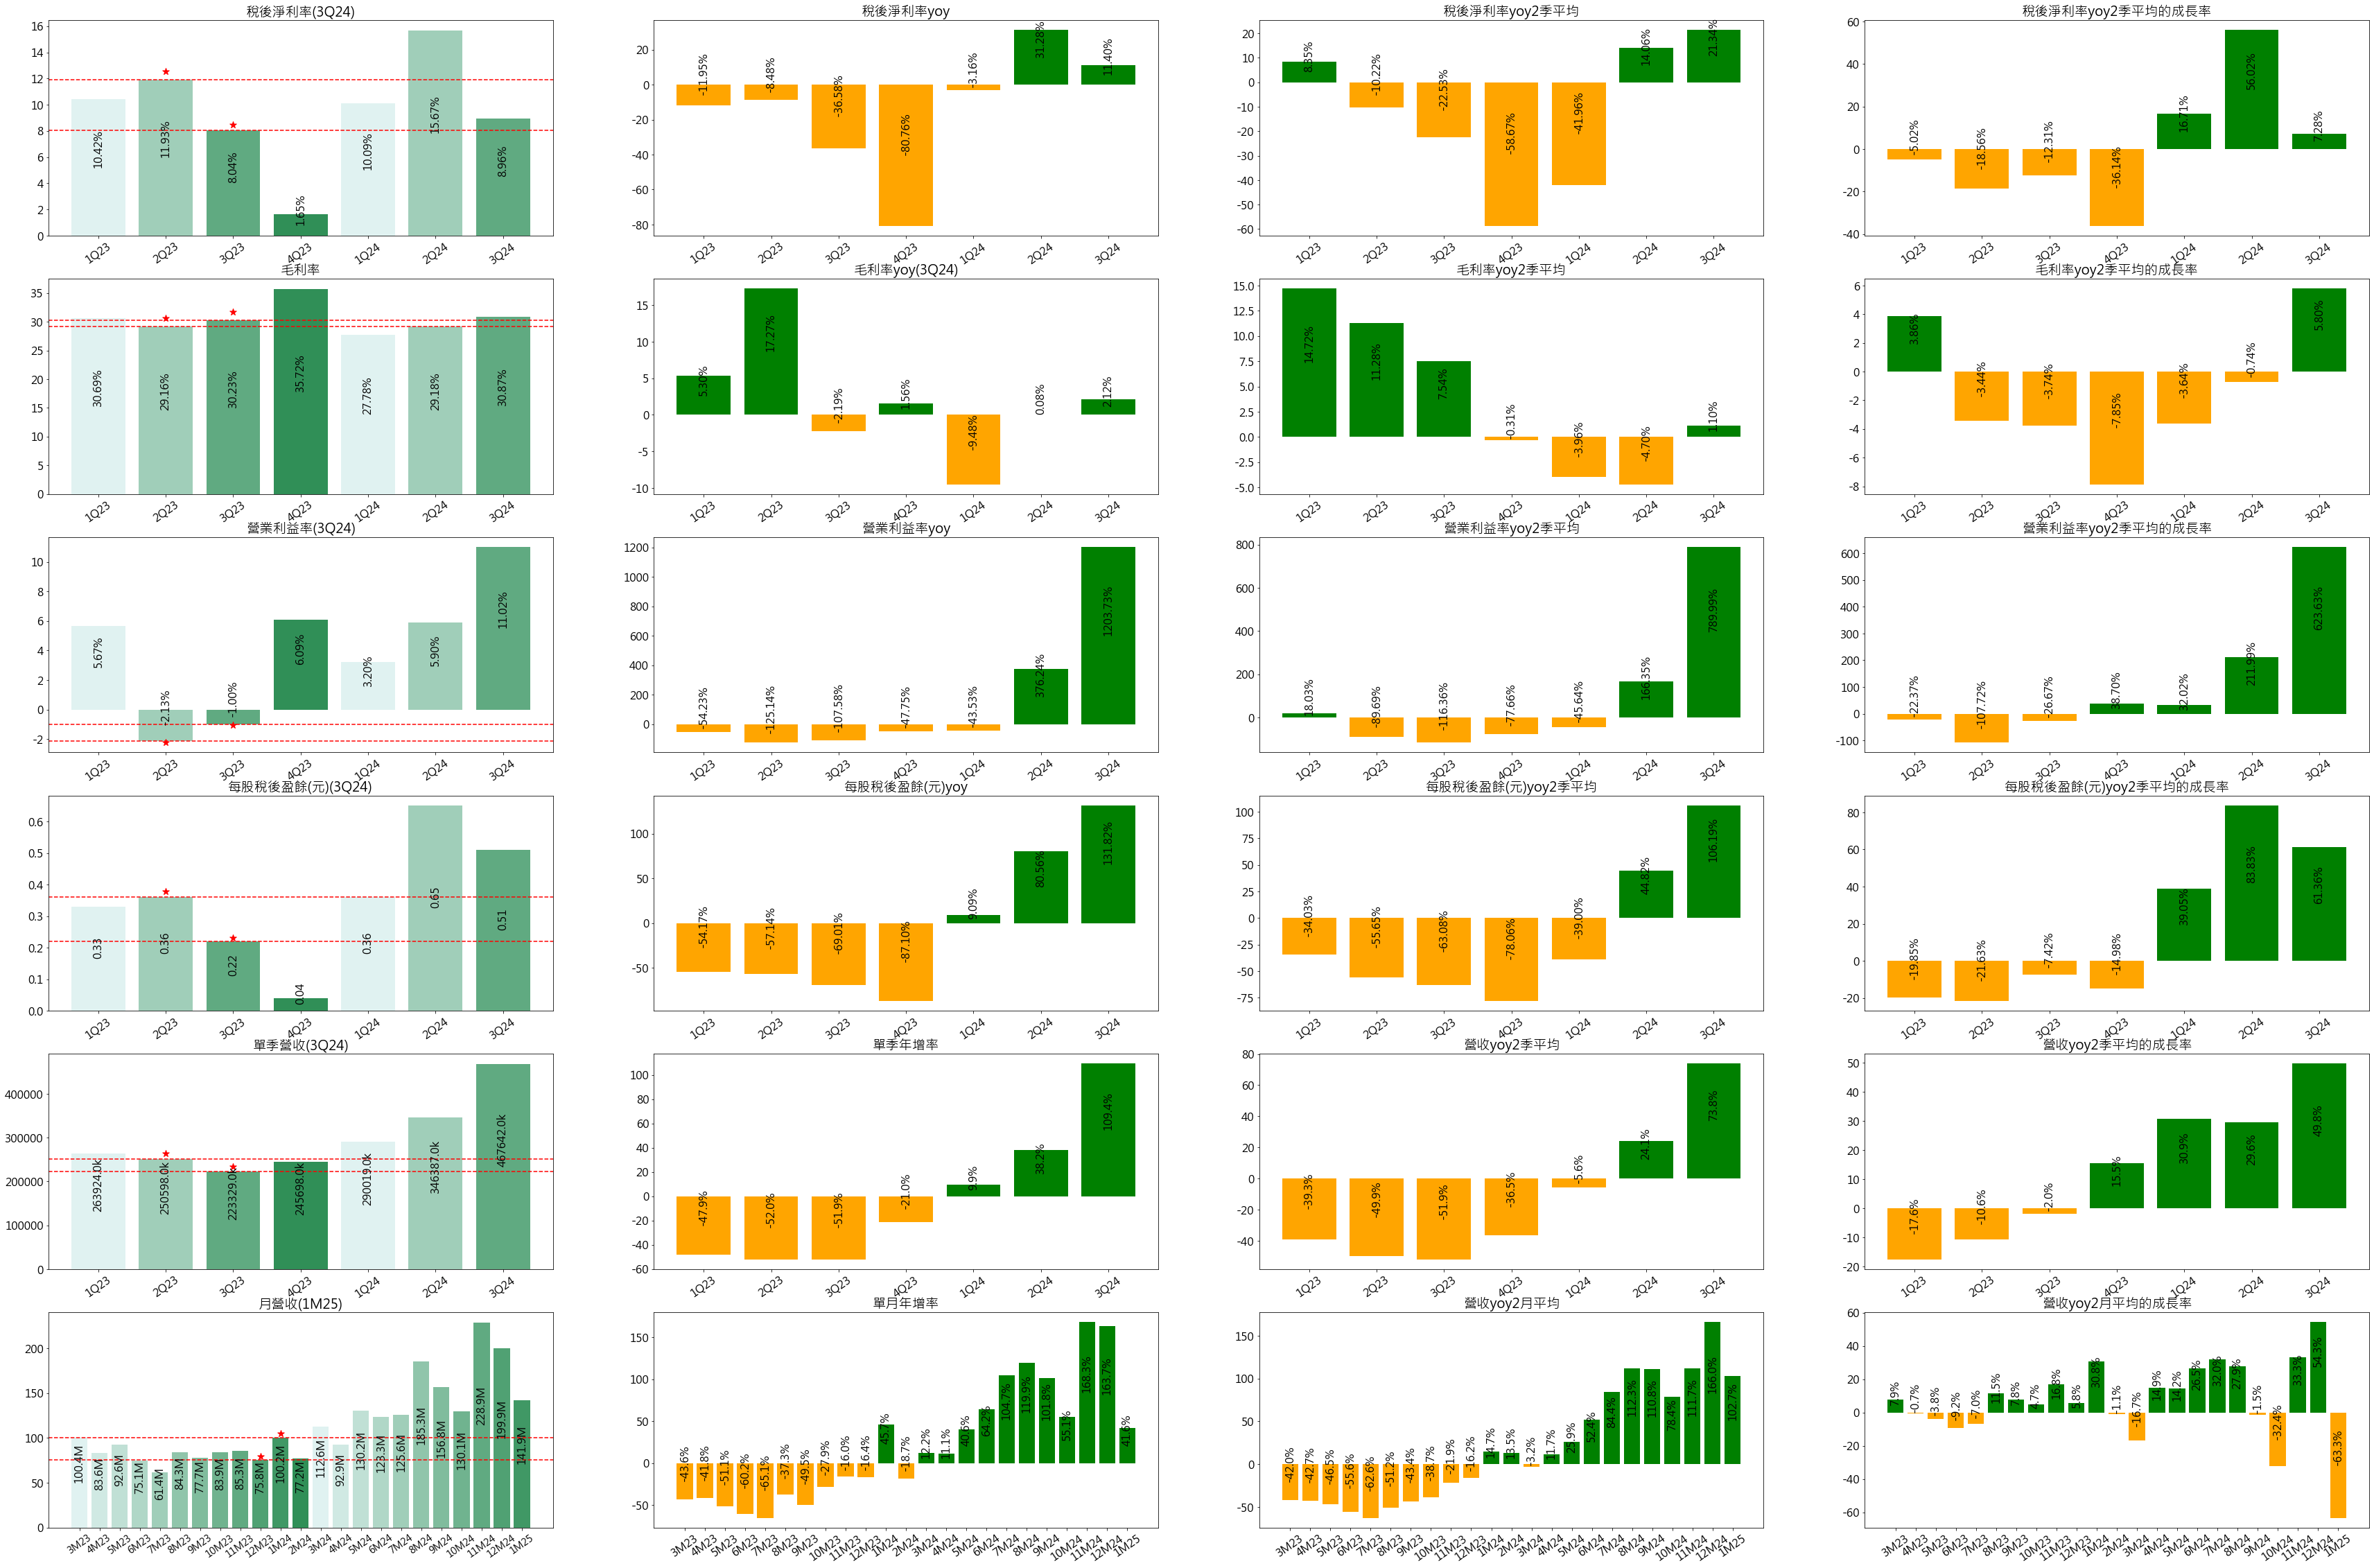

C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.financial_statement_df['update_date'] = pd.to_datetime(self.financial_statement_df['update_date'])
C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.monthly_revenue_df['update_date'] = pd.to_datetime(self.monthly_revenue_df['update_date'])


6789基本面分析
6789營收分數: 2
6789的分數(2024Q3 | 2025M1): 14/15


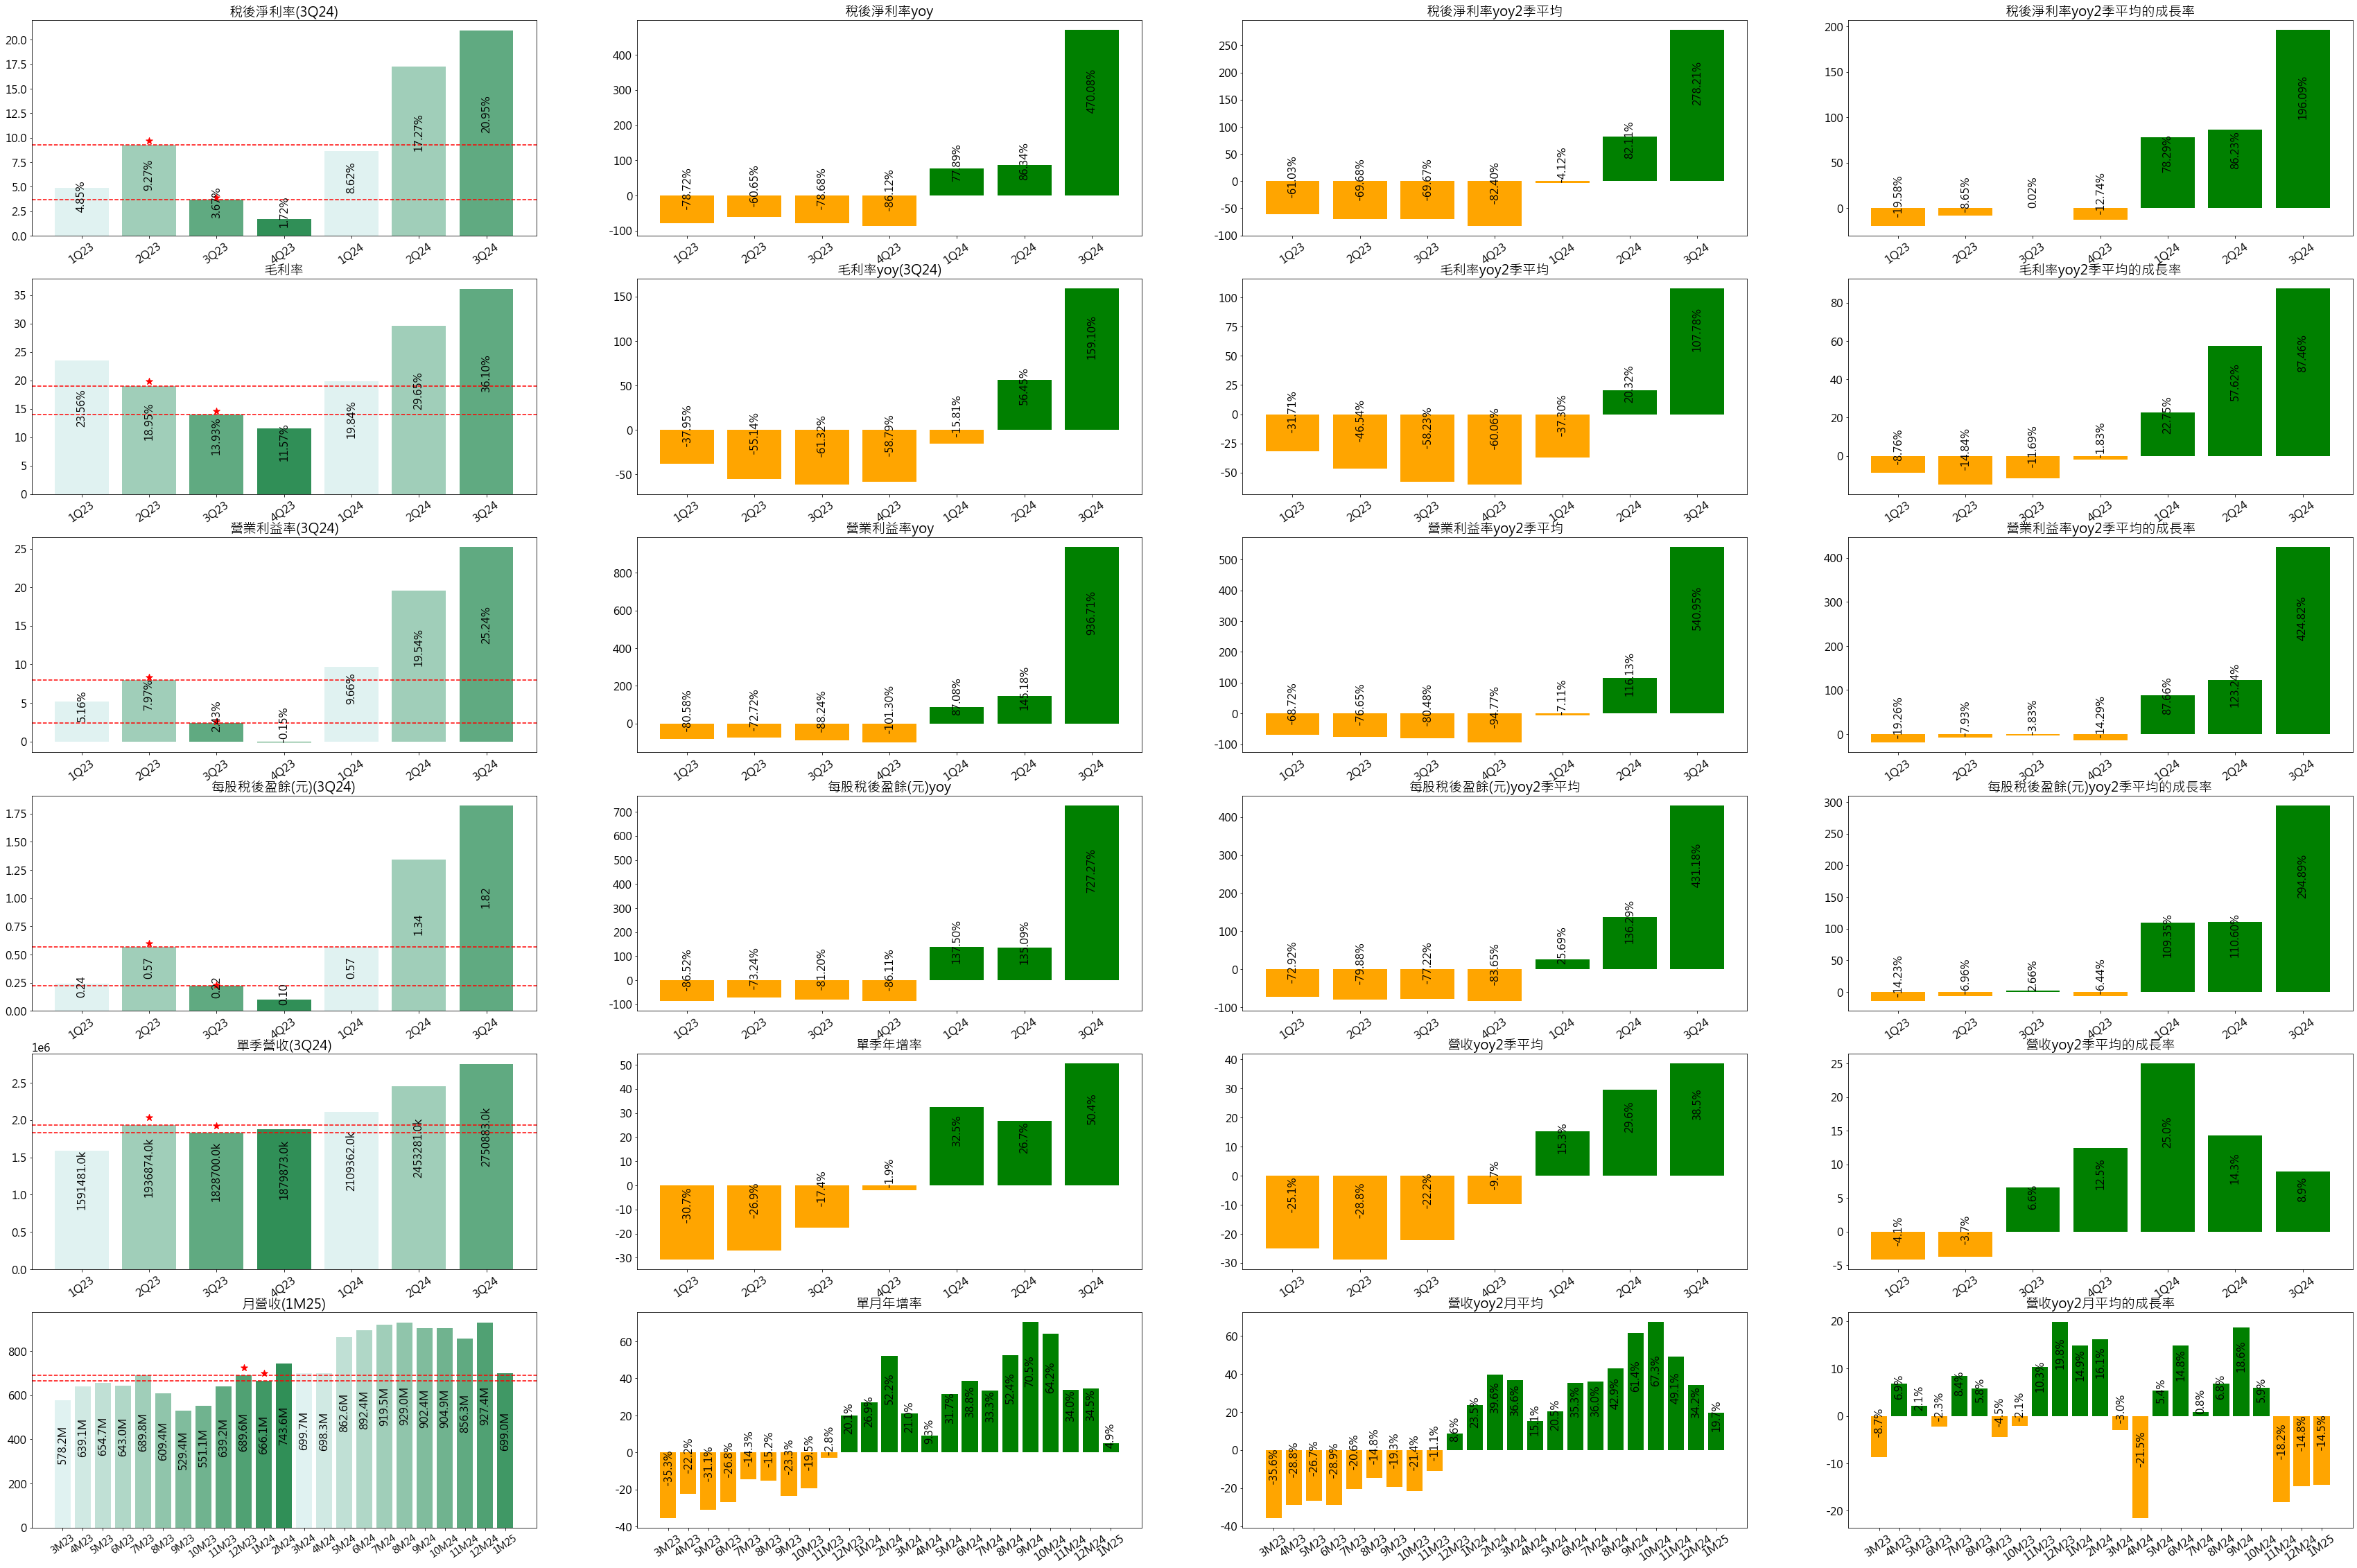

C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.financial_statement_df['update_date'] = pd.to_datetime(self.financial_statement_df['update_date'])
C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.monthly_revenue_df['update_date'] = pd.to_datetime(self.monthly_revenue_df['update_date'])


3029基本面分析
3029營收分數: 3
3029的分數(2024Q3 | 2025M1): 8/15


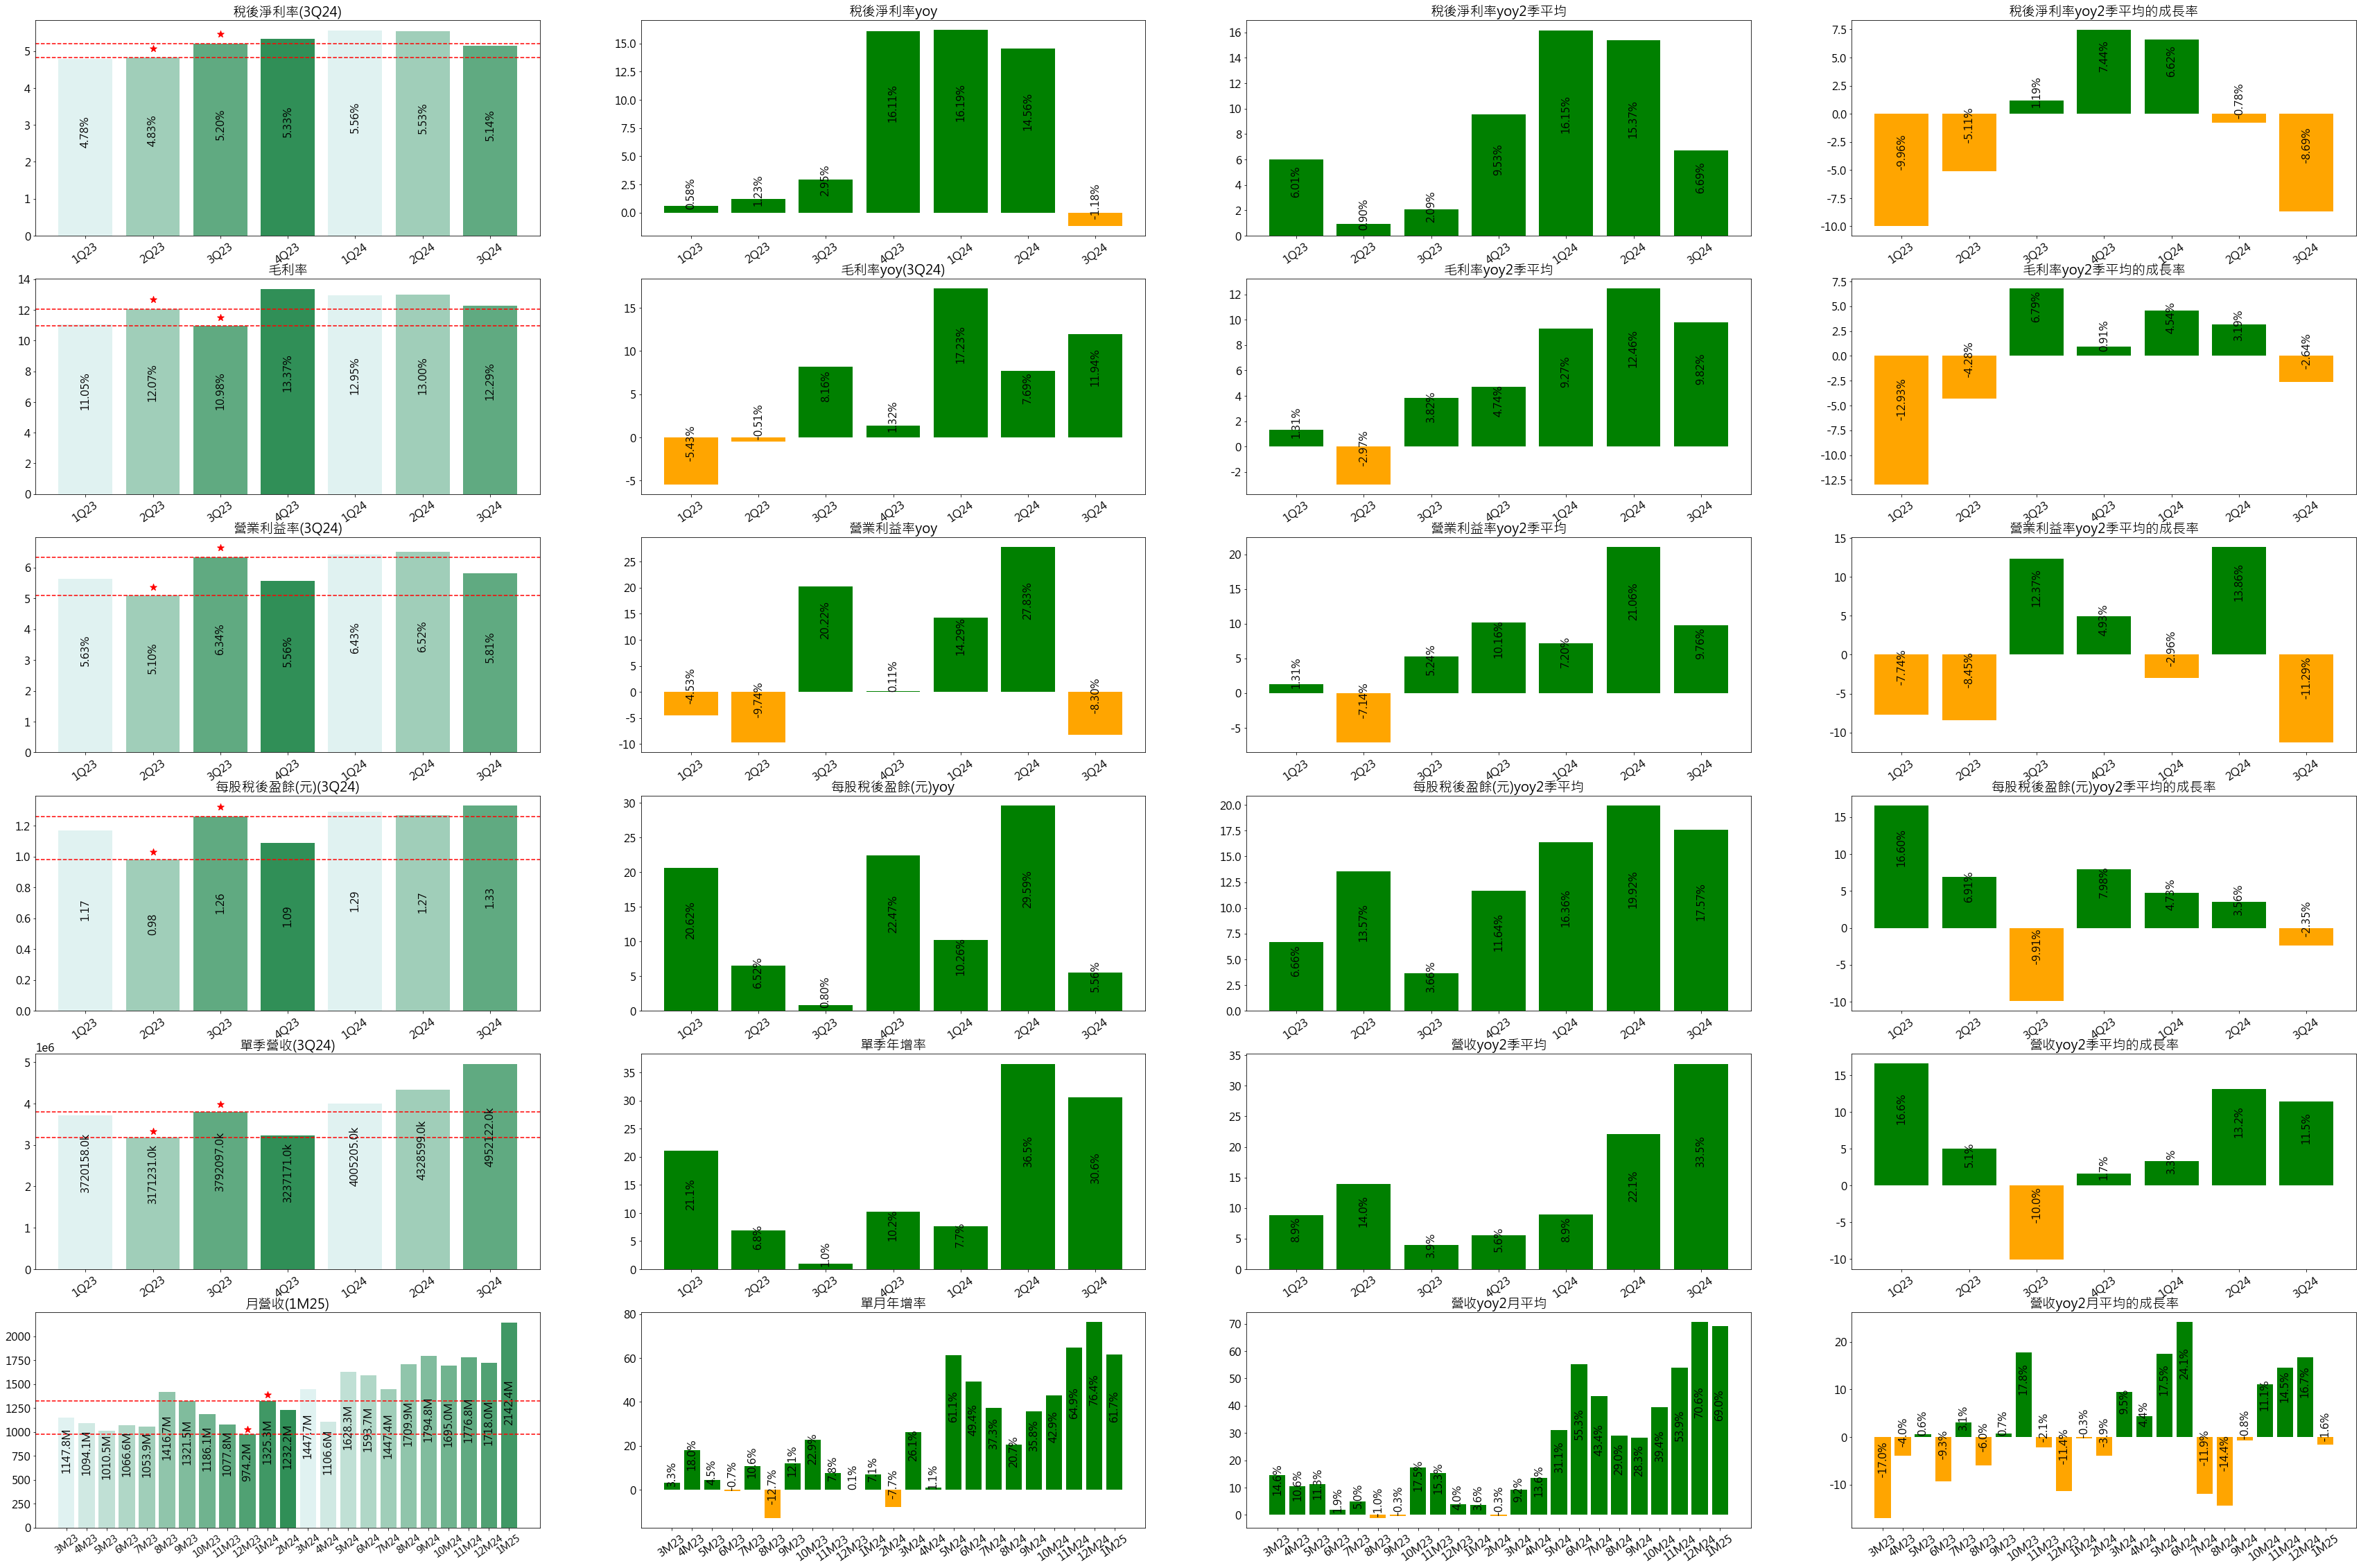

C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.financial_statement_df['update_date'] = pd.to_datetime(self.financial_statement_df['update_date'])
C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.monthly_revenue_df['update_date'] = pd.to_datetime(self.monthly_revenue_df['update_date'])


5203基本面分析
5203營收分數: 3
5203的分數(2024Q3 | 2025M1): 8/15


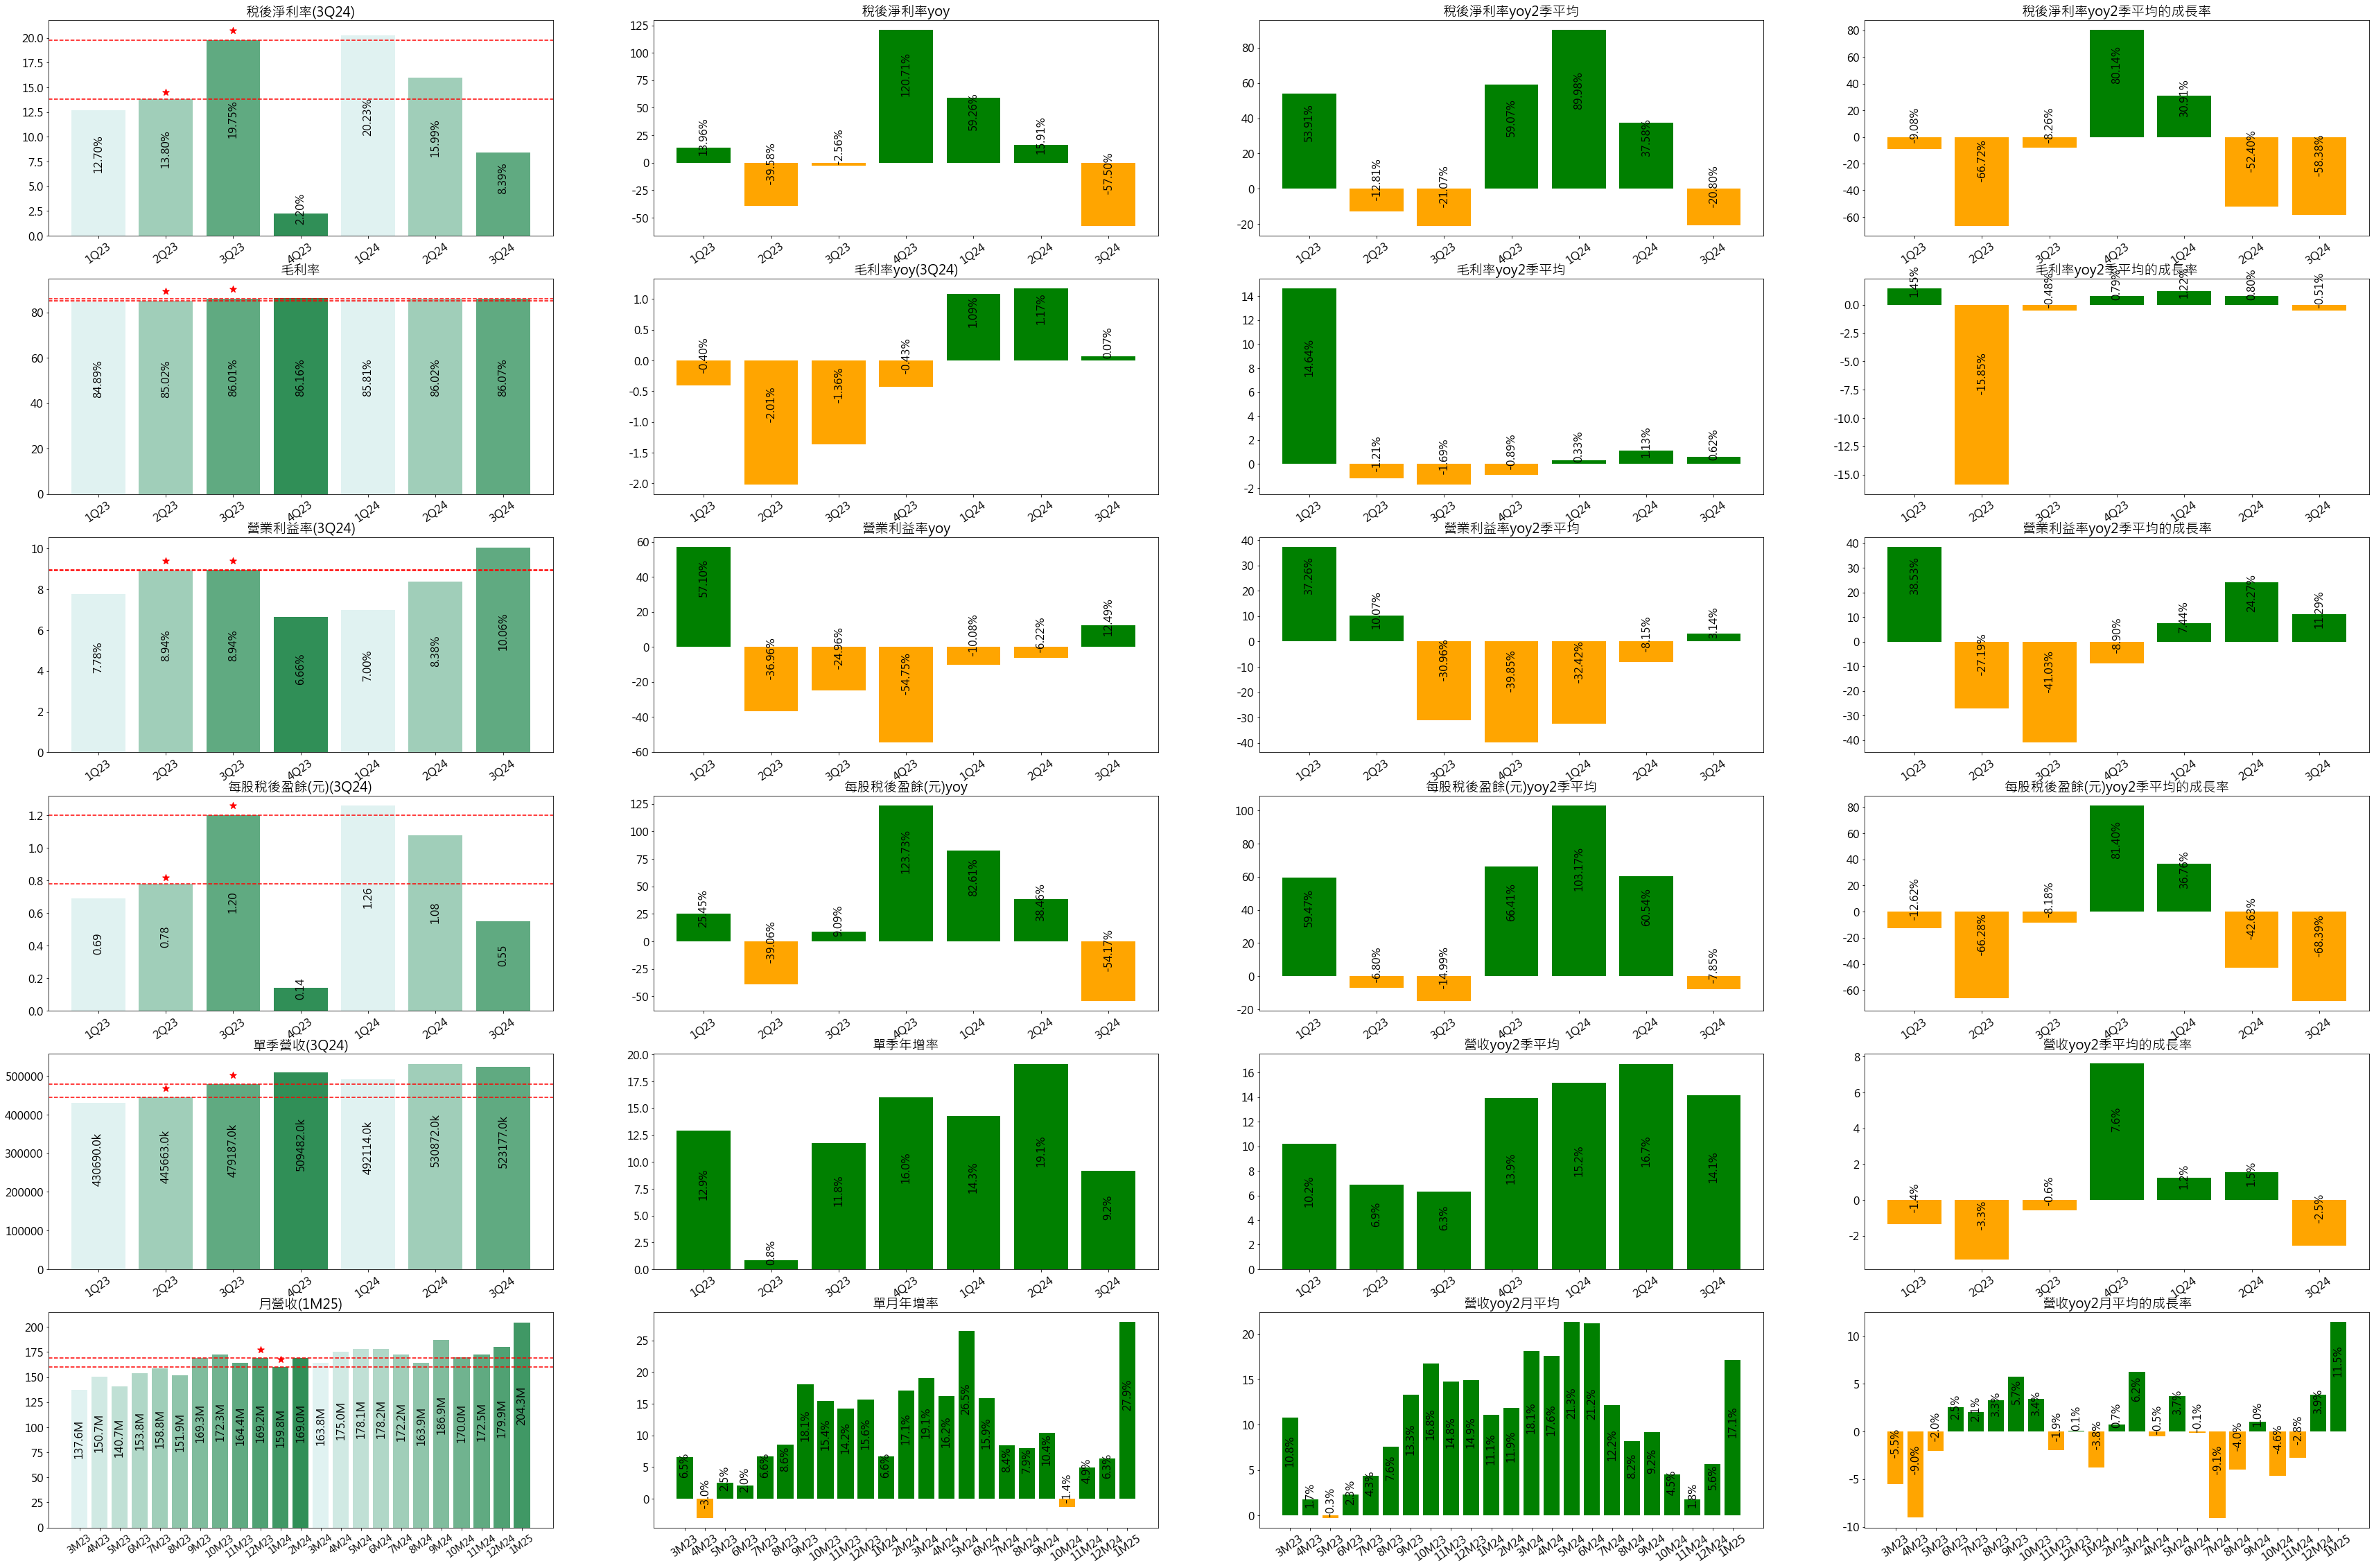

C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.financial_statement_df['update_date'] = pd.to_datetime(self.financial_statement_df['update_date'])
C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.monthly_revenue_df['update_date'] = pd.to_datetime(self.monthly_revenue_df['update_date'])


2395基本面分析
2395營收分數: 2
2395的分數(2024Q3 | 2025M1): 9/15


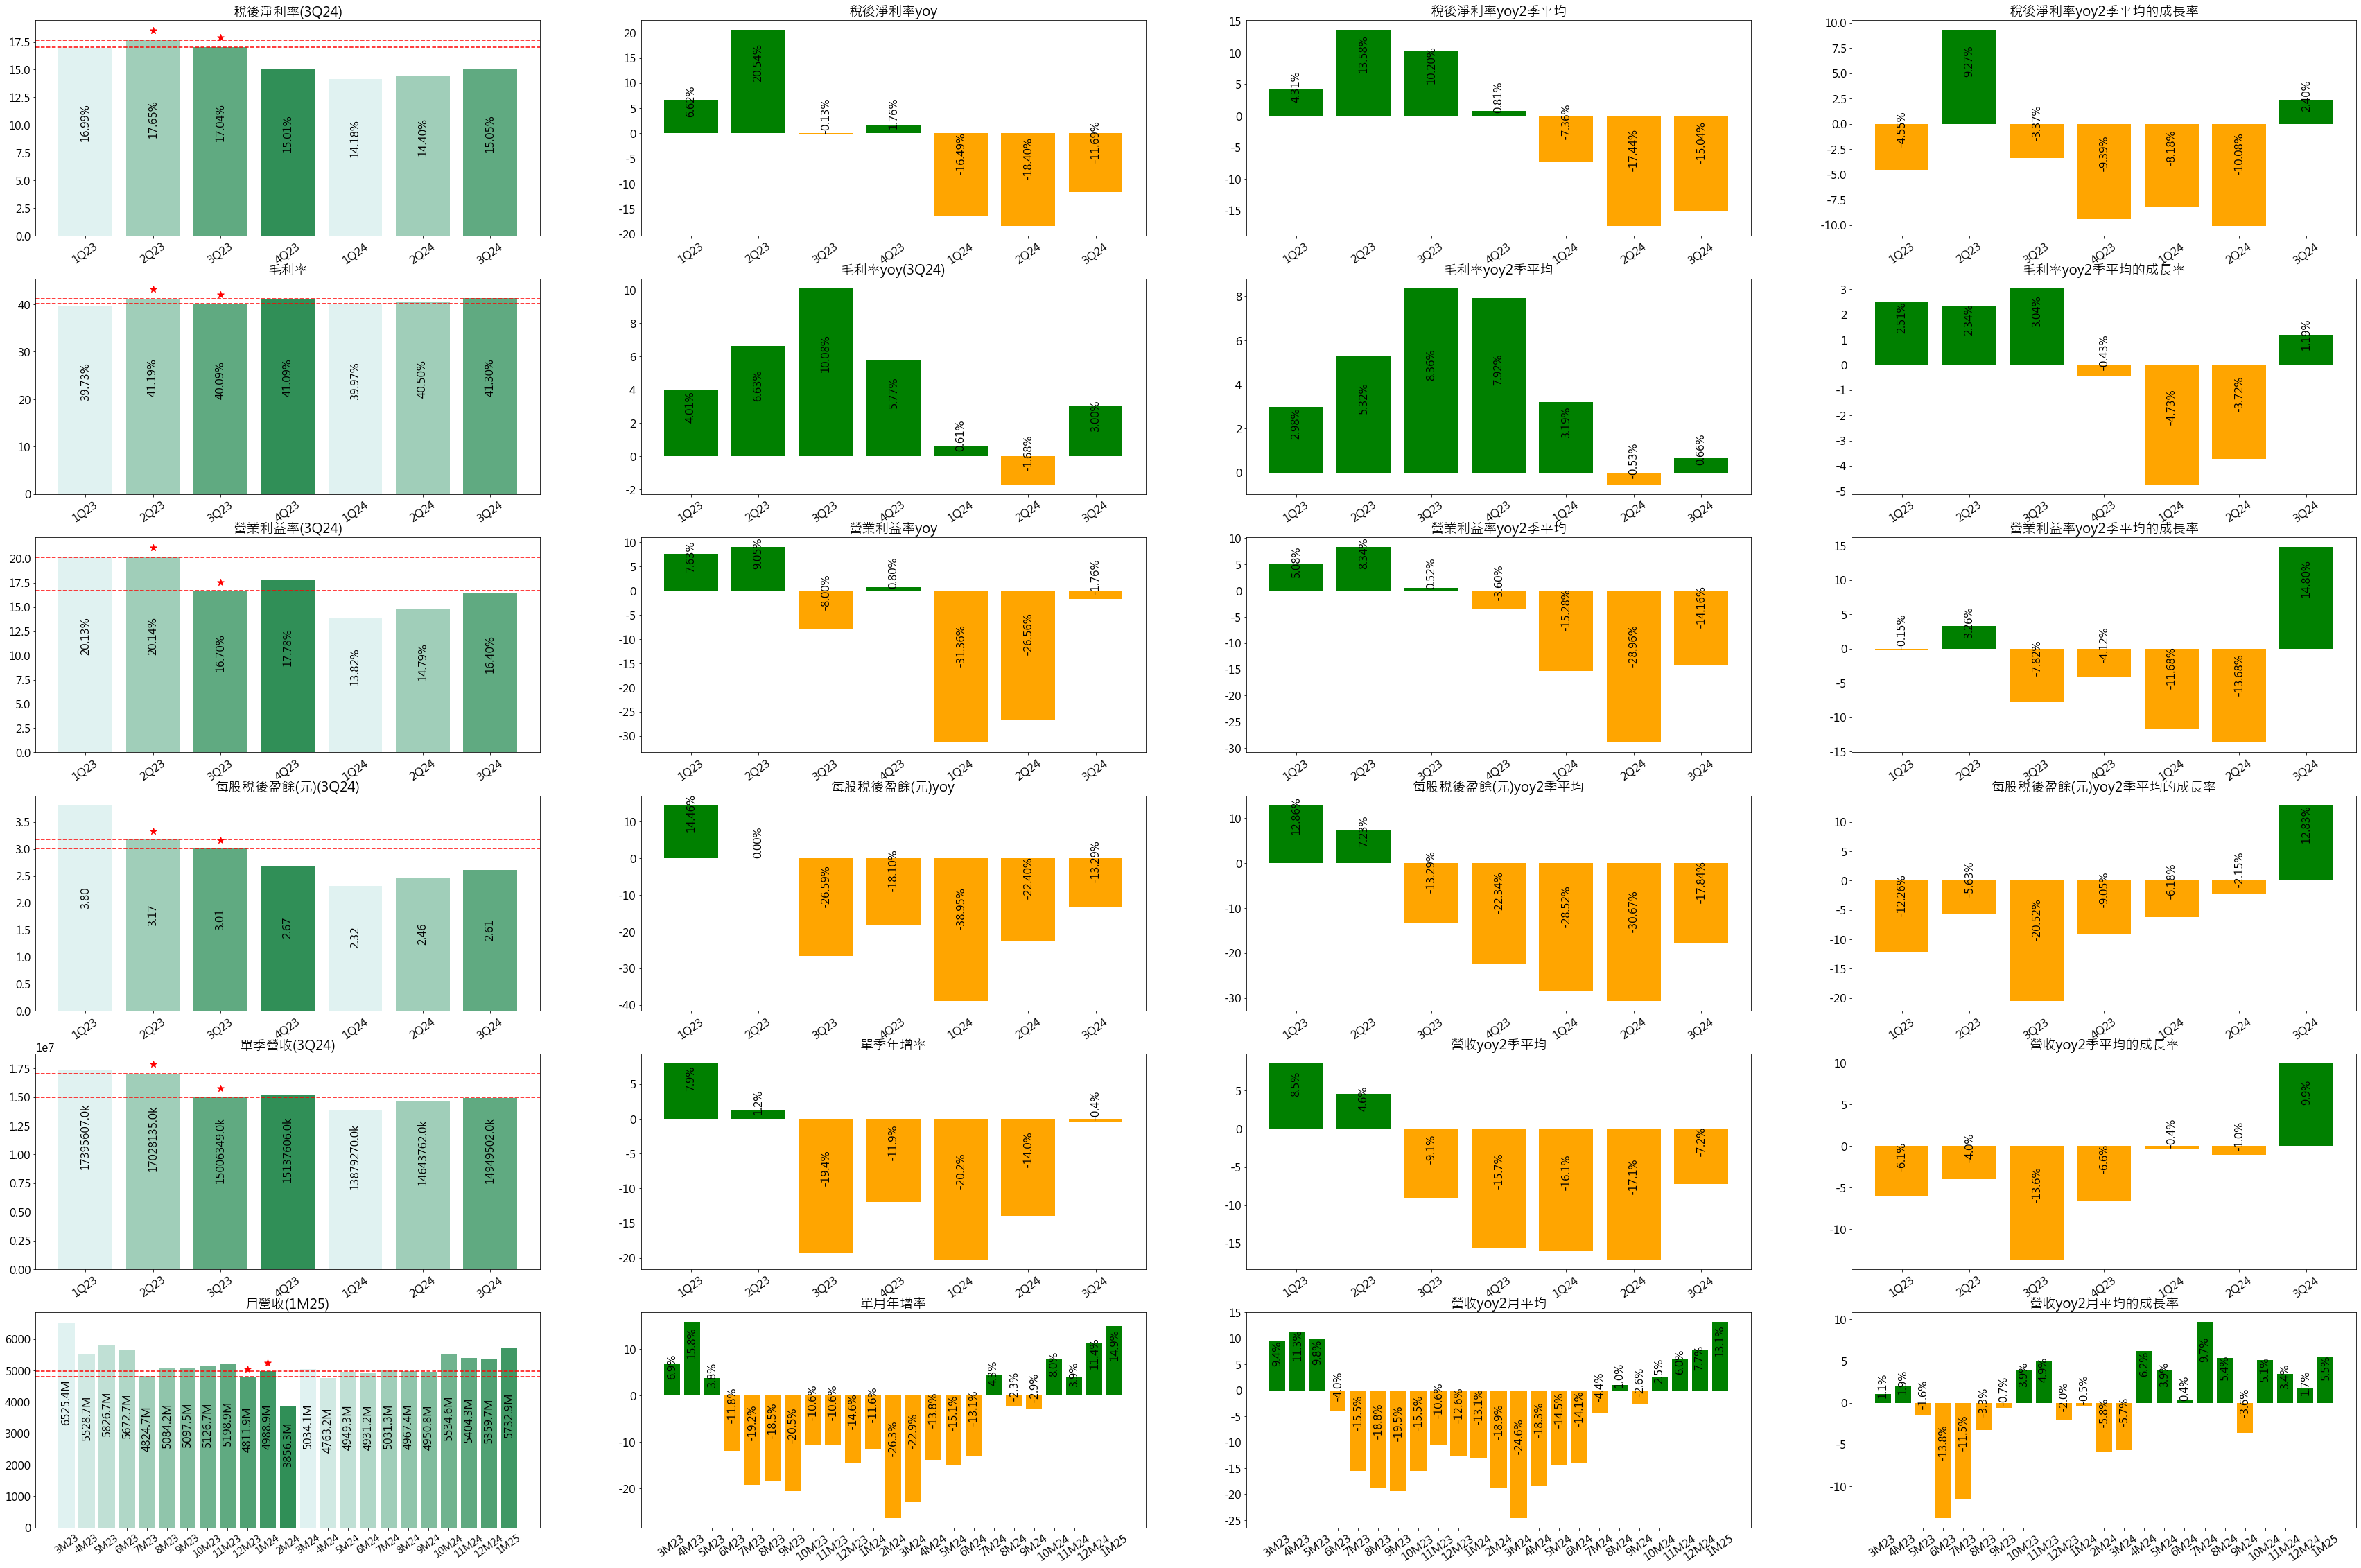

C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.financial_statement_df['update_date'] = pd.to_datetime(self.financial_statement_df['update_date'])
C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.monthly_revenue_df['update_date'] = pd.to_datetime(self.monthly_revenue_df['update_date'])


5269基本面分析
5269營收分數: 3
5269的分數(2024Q3 | 2025M1): 10/15


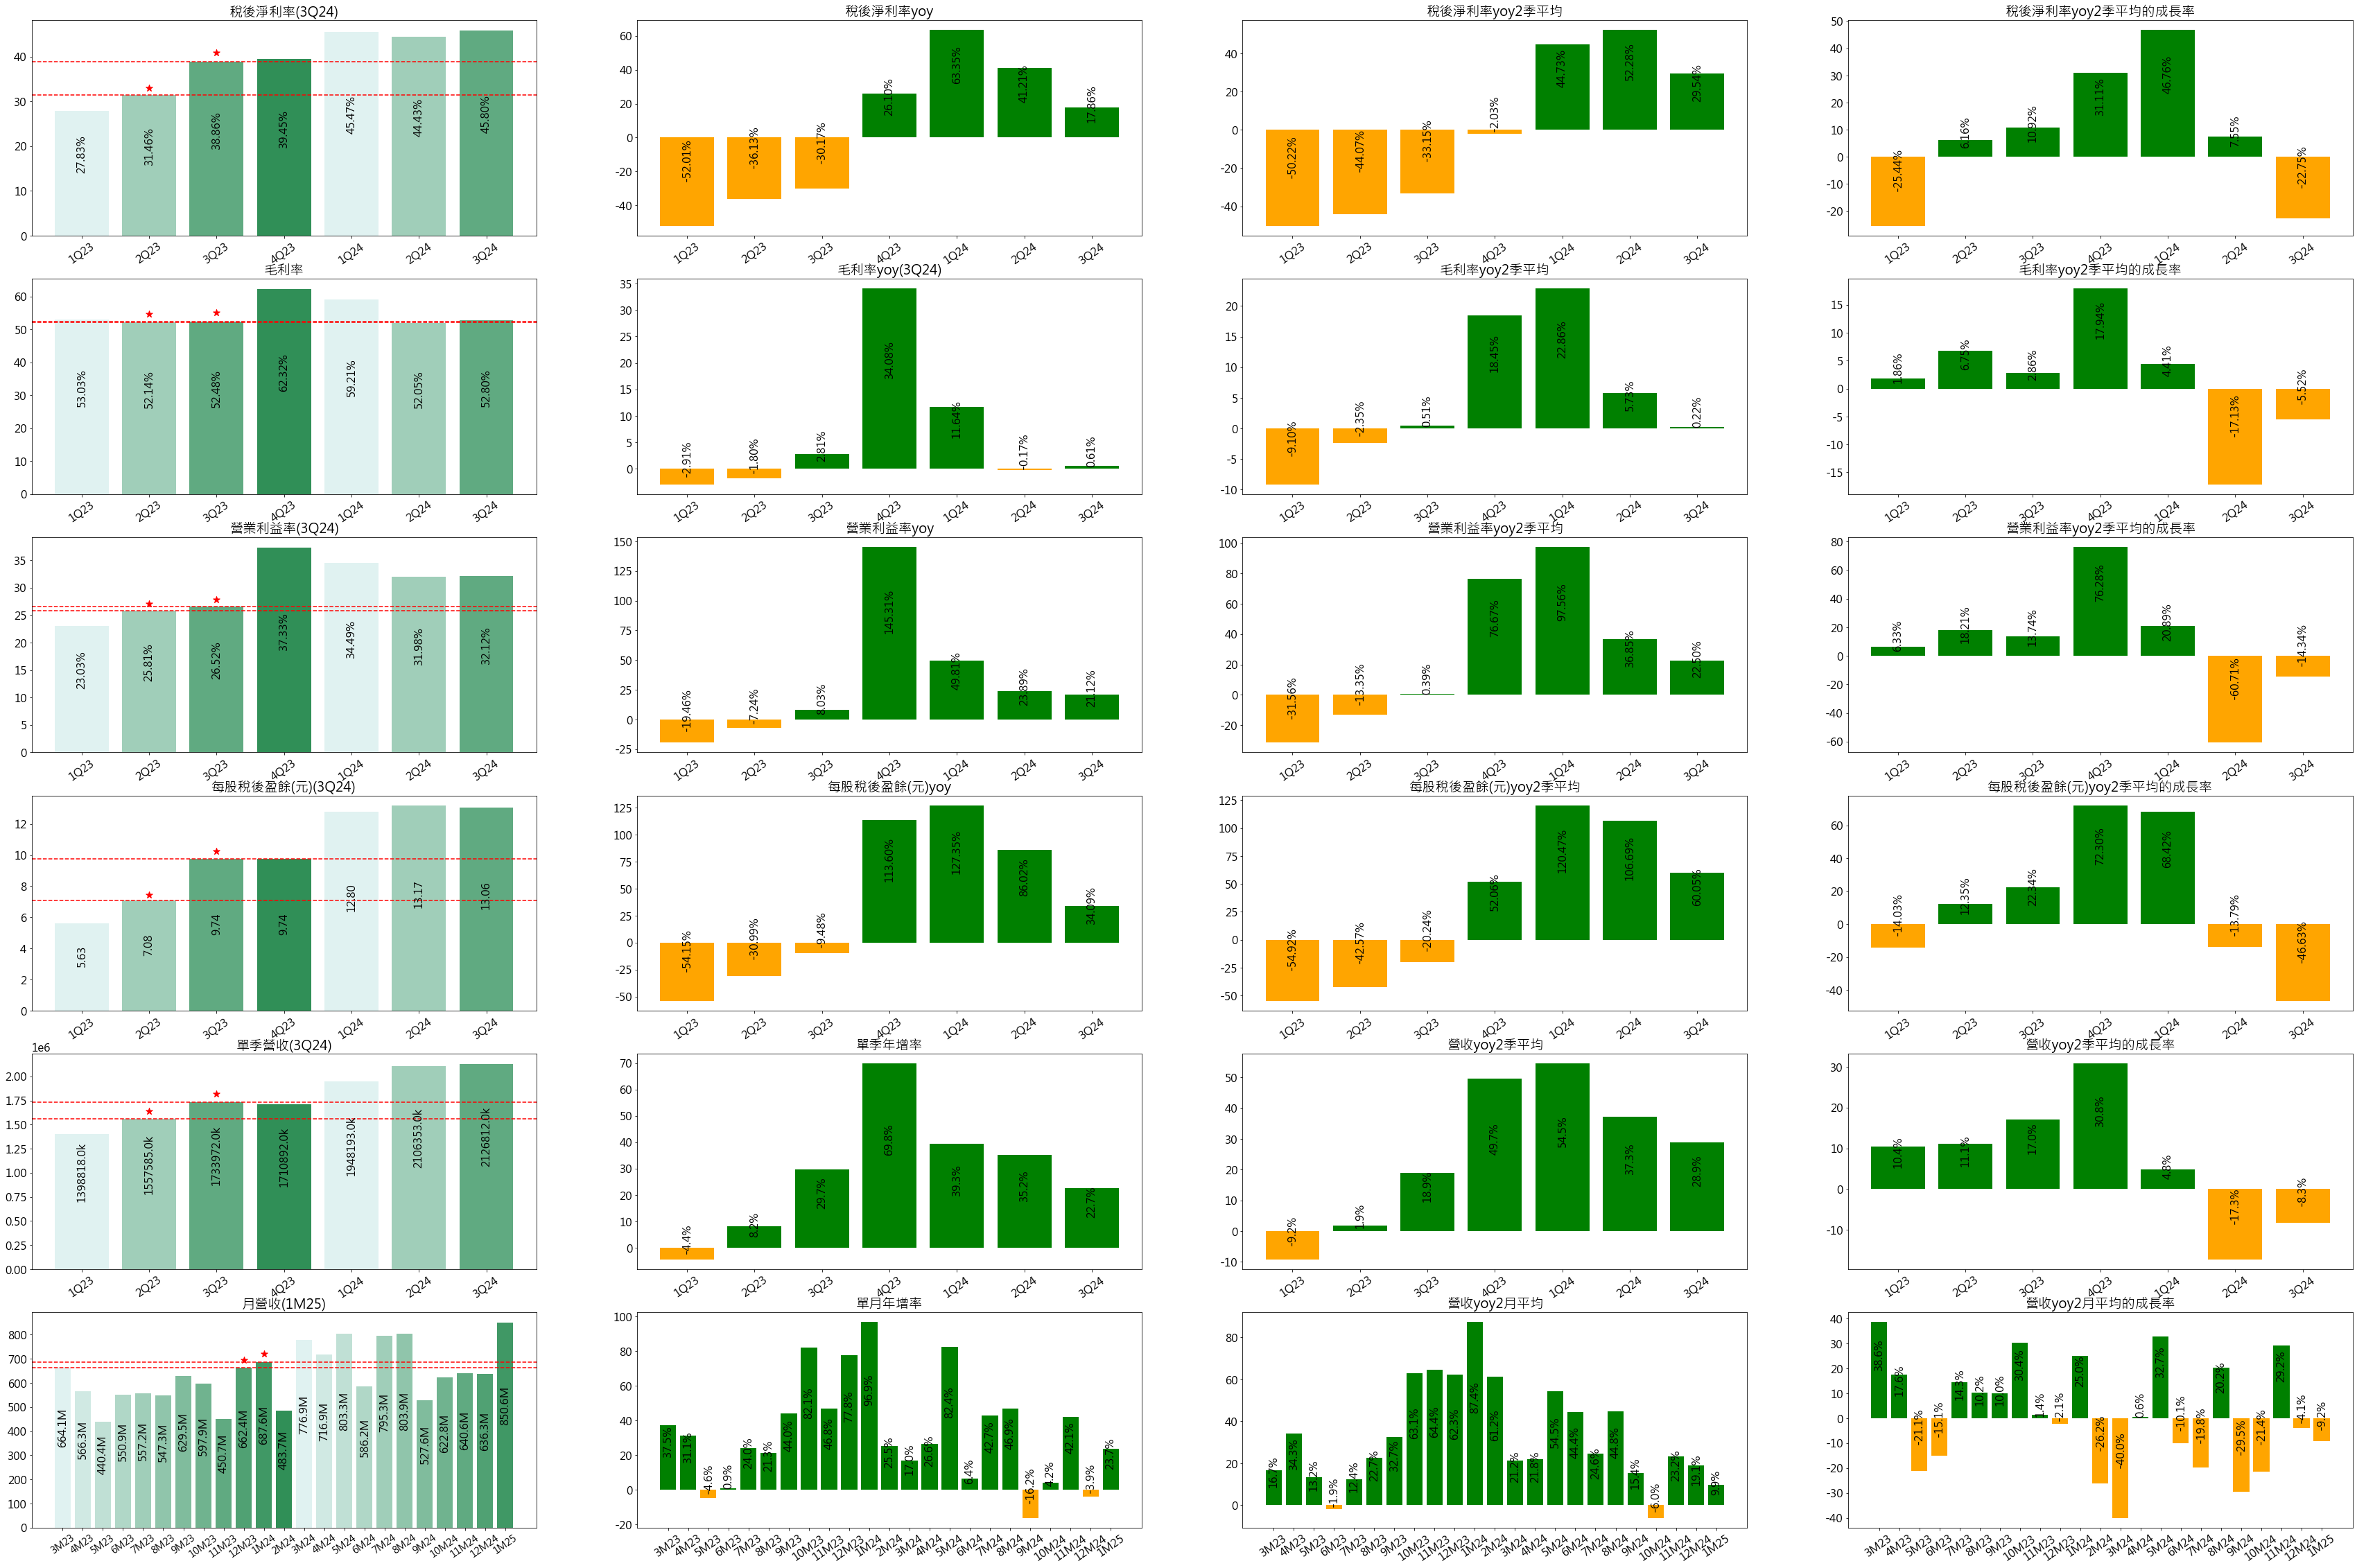

C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.financial_statement_df['update_date'] = pd.to_datetime(self.financial_statement_df['update_date'])
C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.monthly_revenue_df['update_date'] = pd.to_datetime(self.monthly_revenue_df['update_date'])


1815基本面分析
1815營收分數: 2
1815的分數(2024Q3 | 2025M1): 14/15


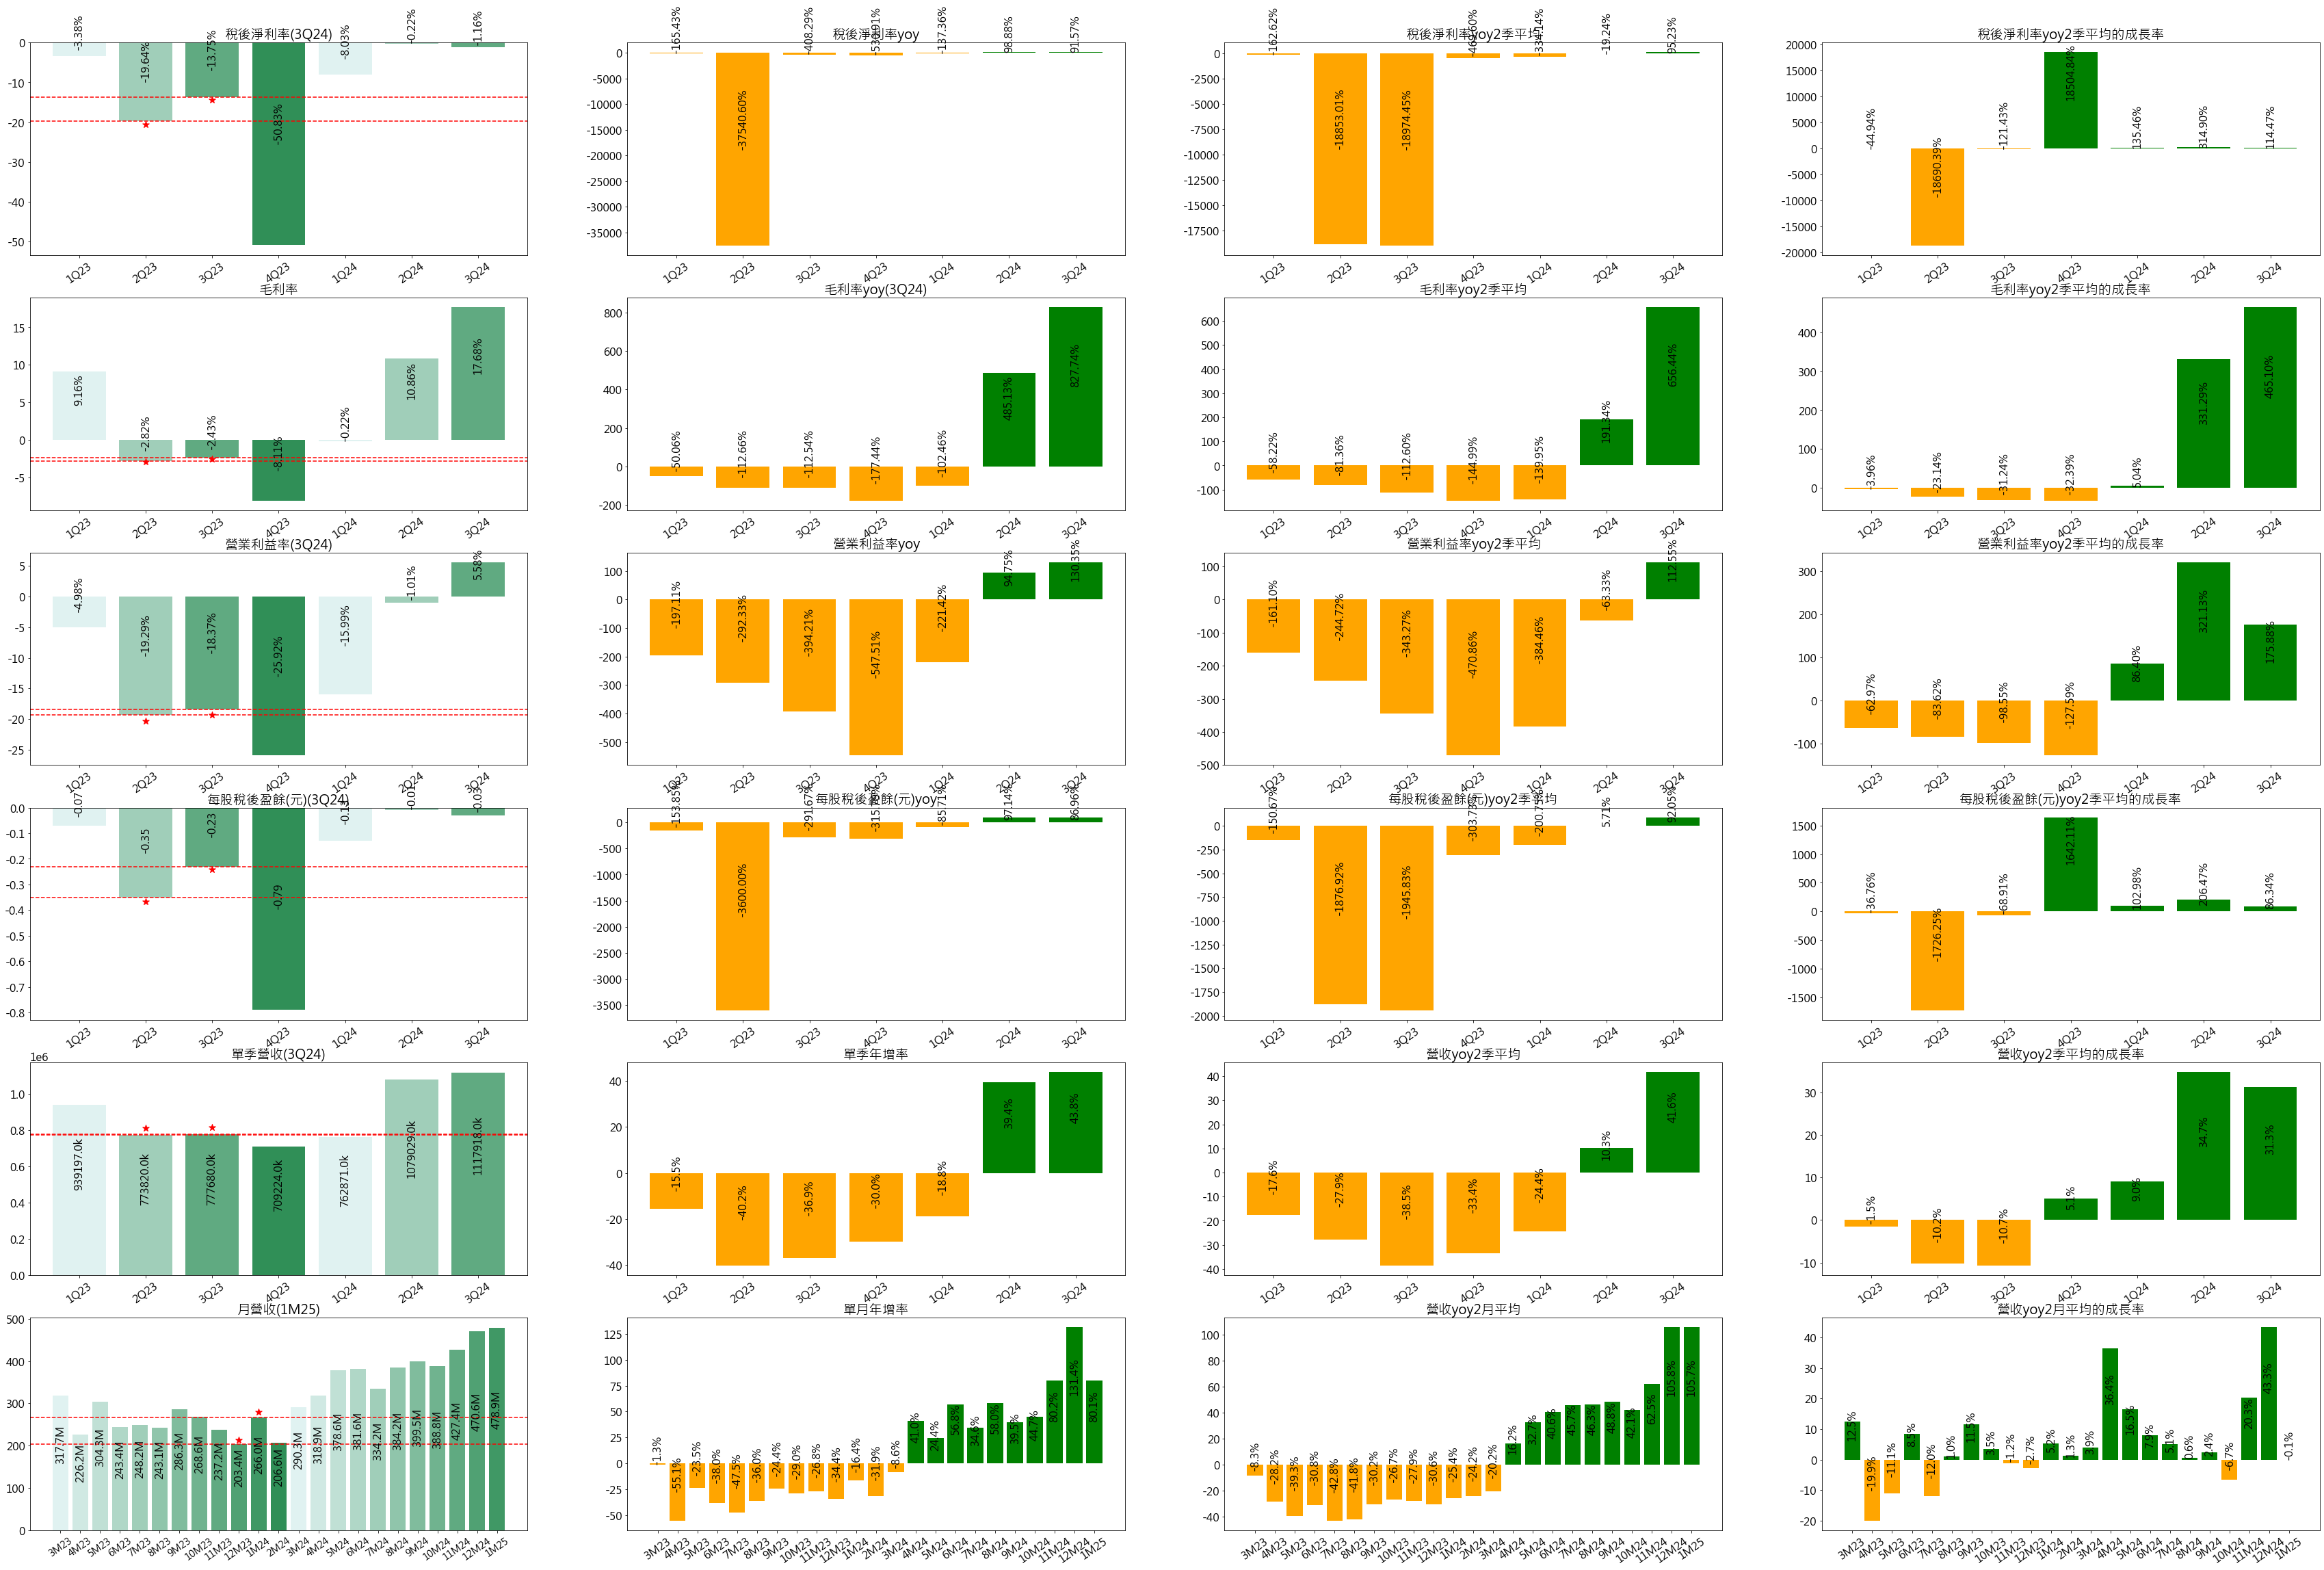

C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.financial_statement_df['update_date'] = pd.to_datetime(self.financial_statement_df['update_date'])
C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.monthly_revenue_df['update_date'] = pd.to_datetime(self.monthly_revenue_df['update_date'])


2027基本面分析
2027營收分數: 0
2027的分數(2024Q3 | 2025M1): 7/15


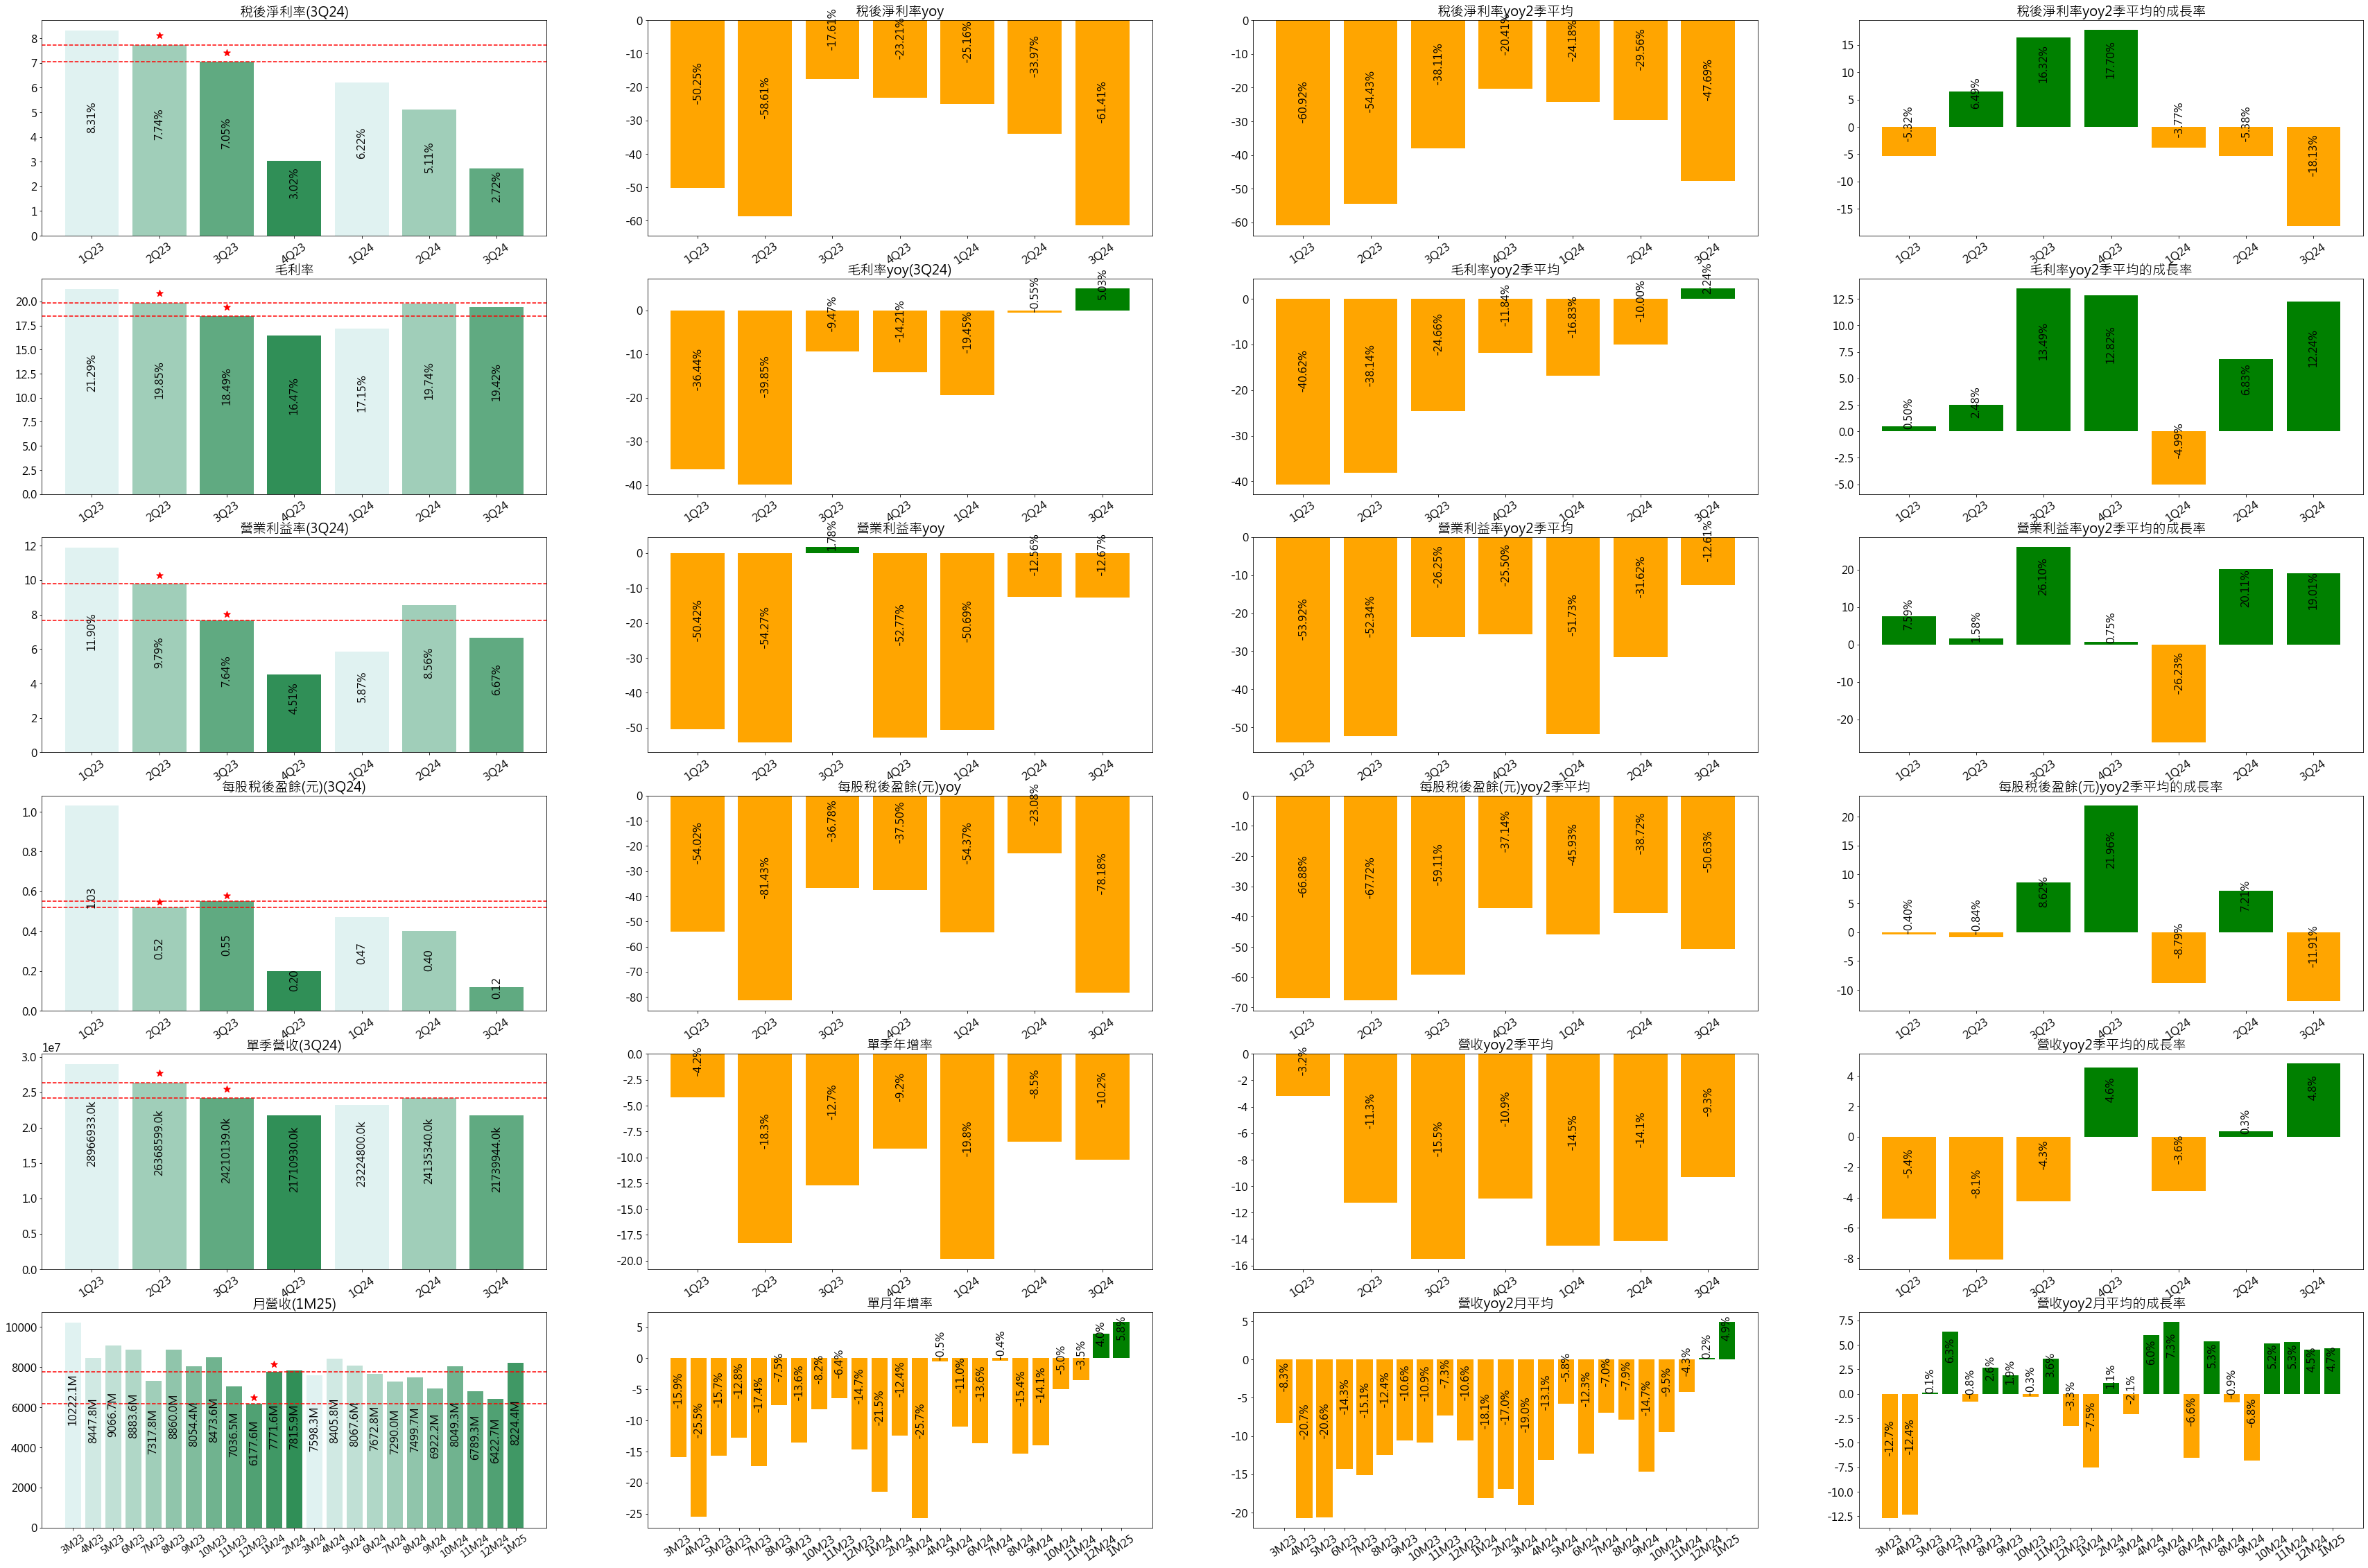

C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.financial_statement_df['update_date'] = pd.to_datetime(self.financial_statement_df['update_date'])
C:\Users\User\AppData\Local\Temp\ipykernel_5780\2904535554.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.monthly_revenue_df['update_date'] = pd.to_datetime(self.monthly_revenue_df['update_date'])


6585基本面分析
6585營收分數: 3
6585的分數(2024Q3 | 2025M1): 11/15


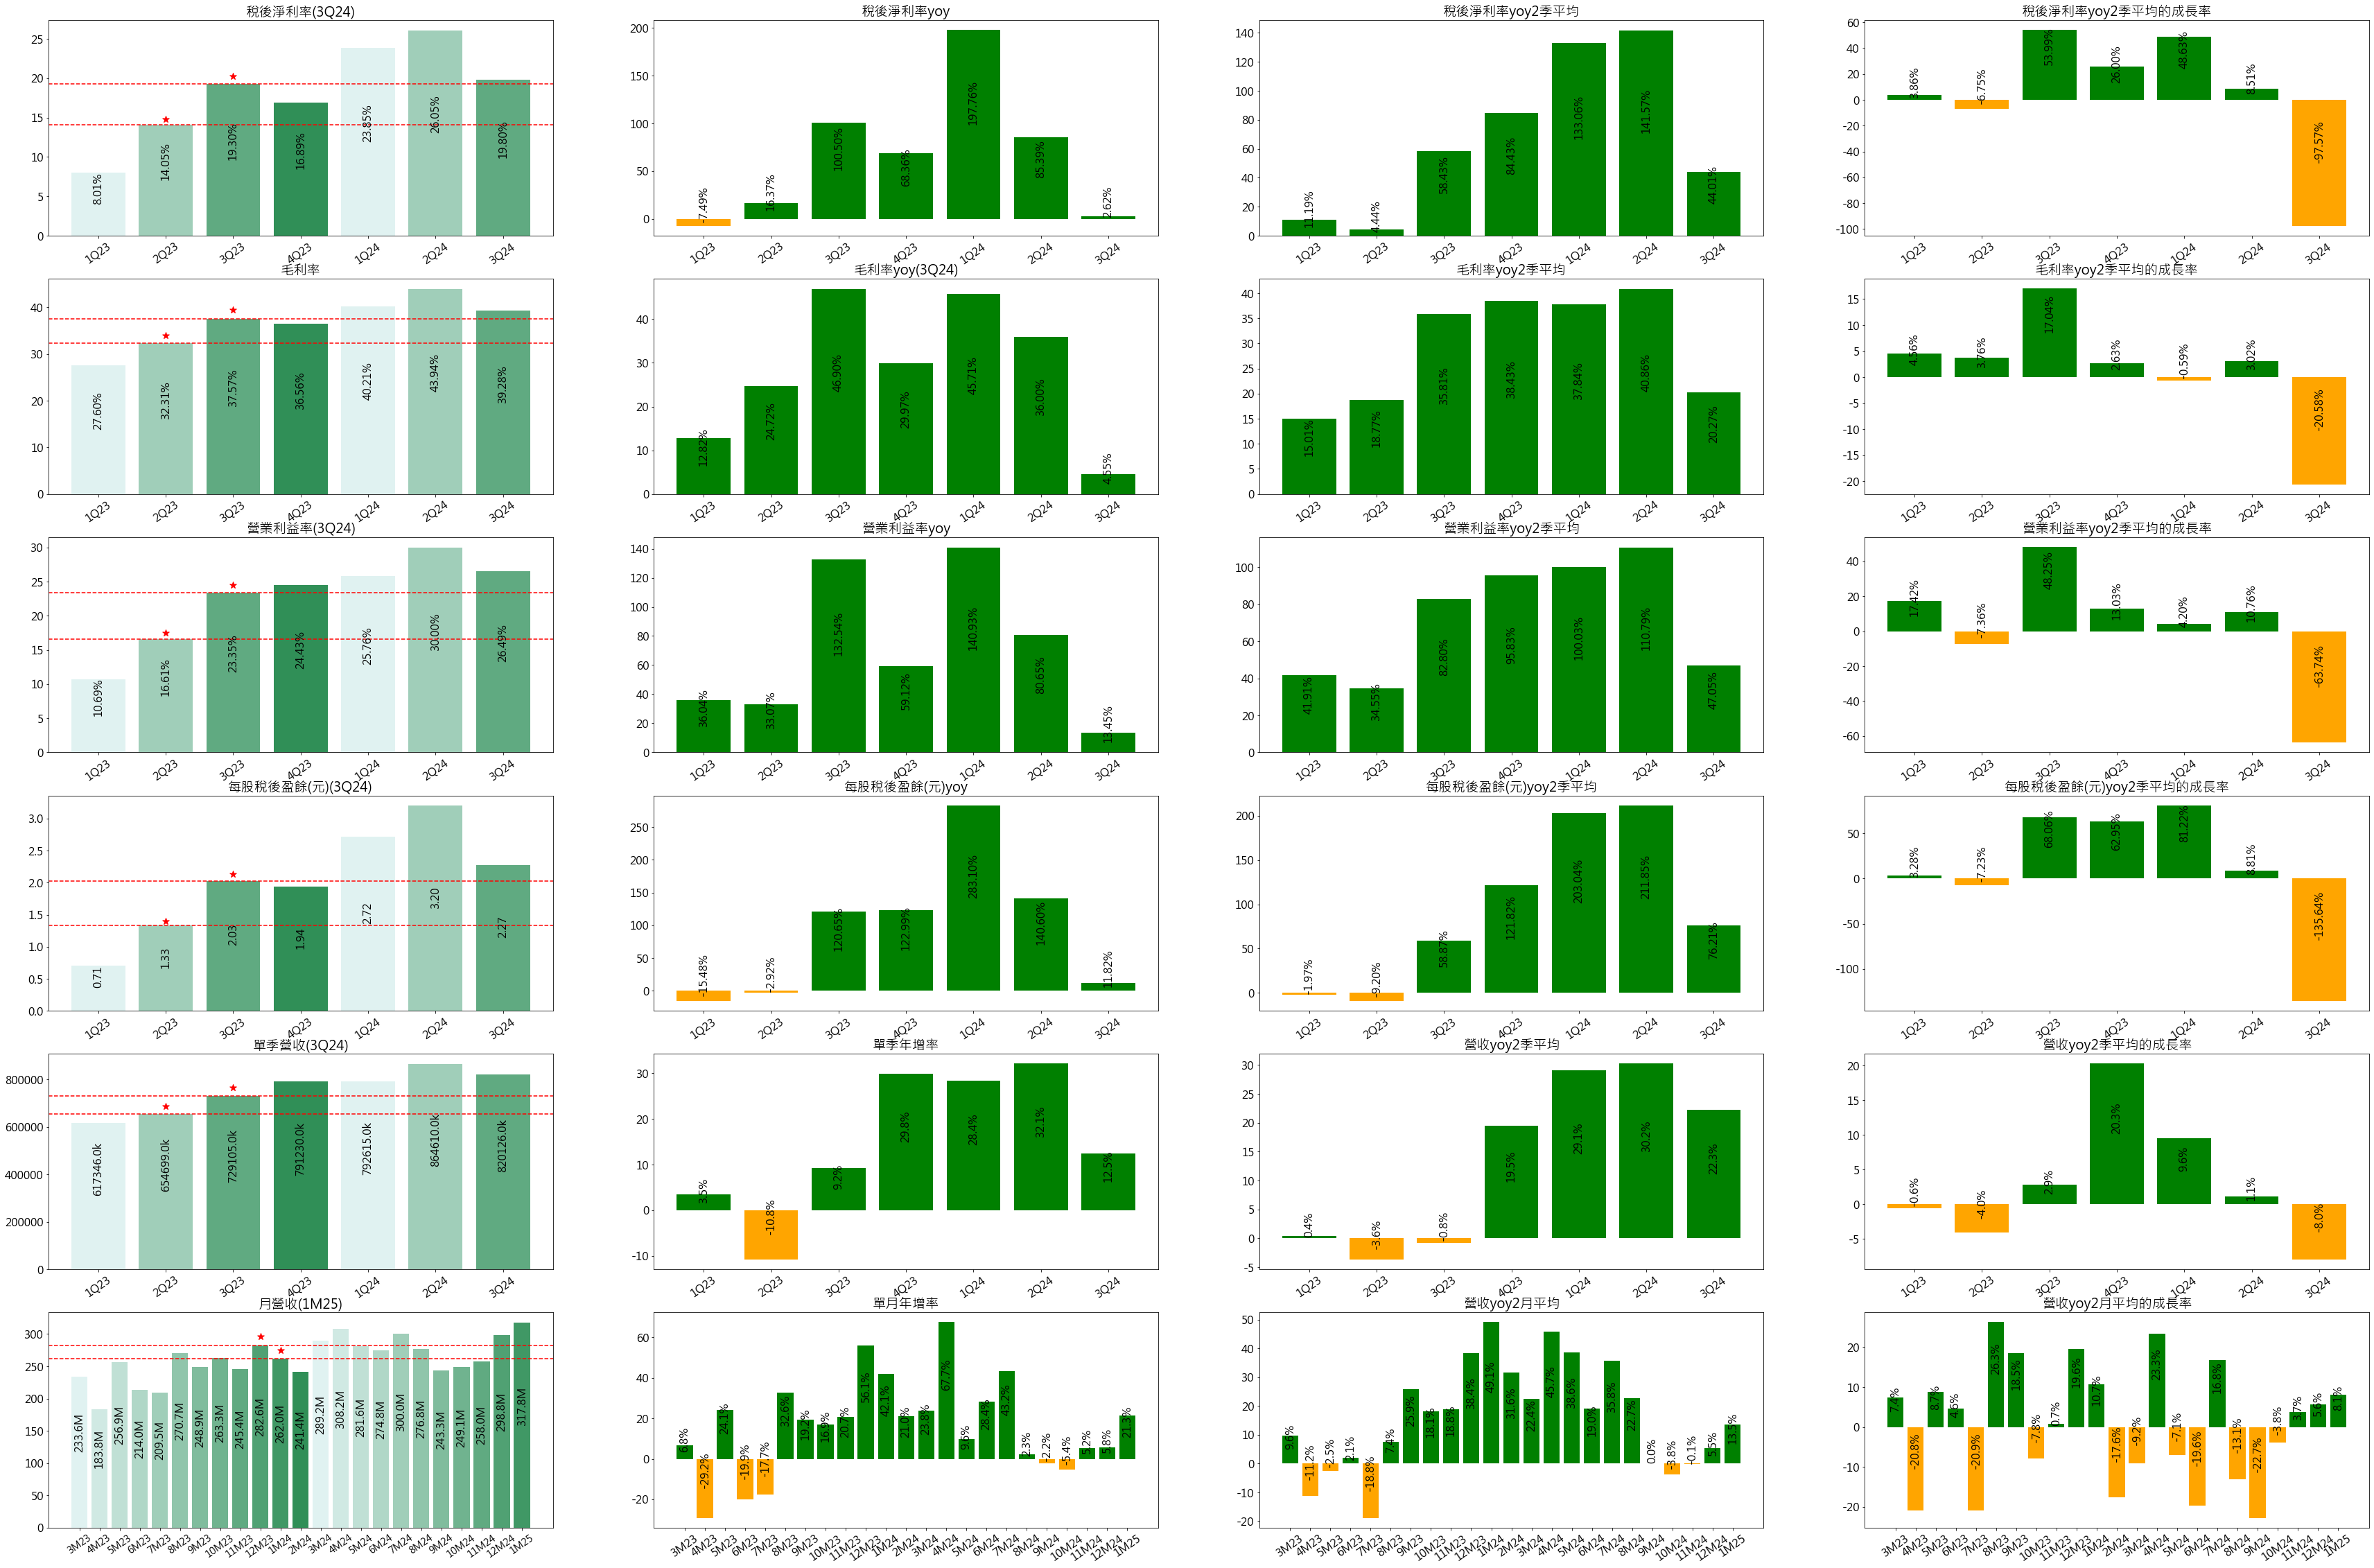

2049的分數(2024Q3 | 2025M1): 8/15 營收分數: 0
2374的分數(2024Q3 | 2025M1): 8/15 營收分數: 2
6215的分數(2024Q3 | 2025M1): 14/15 營收分數: 1
6789的分數(2024Q3 | 2025M1): 14/15 營收分數: 2
3029的分數(2024Q3 | 2025M1): 8/15 營收分數: 3
5203的分數(2024Q3 | 2025M1): 8/15 營收分數: 3
2395的分數(2024Q3 | 2025M1): 9/15 營收分數: 2
5269的分數(2024Q3 | 2025M1): 10/15 營收分數: 3
1815的分數(2024Q3 | 2025M1): 14/15 營收分數: 2
2027的分數(2024Q3 | 2025M1): 7/15 營收分數: 0
6585的分數(2024Q3 | 2025M1): 11/15 營收分數: 3


In [5]:
holds = '6669 2723 6683 2357 5536'.split(' ')
observes = '8234 5536 4991 4583 4561 4549 3711 3450 3147 2233 1597'.split(' ')
#板卡:2399 2425 2357
#網通:3025 6546
#散熱:3017 2486 3653 3324 3483
#特化: 1727 1721 1773 5434 5234 4755
#CPO:3234 6530 6426 3081 3363 4908 4979 4977 3450 6706 6830 4971
#工具機:1590 4563 6609 4583
#CoWoS:3583 6187
#FOPLP:6438
#探針卡:6510
#PC/NB:2324 4938

#台積電相關 :3374 8028 1560
#設備 :3413 6187 3131 3583 1560 3580 8064 6664 3455 6438 2467 6640 5443 8027 
#CPO :3081 4971 2455 4979 3234 3450 6442 3363 3163 6530 4908 6451 4977 3711 3265 3707 6426
#板卡: 6150 2377 2357 3515
#探針卡 :6223 6683 6515 6510
#手機 :2455 2454 4968 3105 8086 3406 3019 3008
#軍工 :6829 8222 6753
#MLCC :2327 2492 6449 6284 2472 3090 3357 6173 6175
#PCB :3037 2313 4958 2368 5469
#PC/NB :2382 3231 4938 2324 2353
#低軌衛星 :3062 3491 2312 2314 3138 2313 2383 2367 2419 6190 6412 3178 3305
choosen = '2049 2374 6215 6789 3029 5203 2395 5269 1815 2027 6585'.split(' ')
industry = '8234 6763 6446 6290 6139 6112 3558 3264 3234 3162 3088 3078 3019 2395 2049 1815 4164 3661'.split(' ')
individual = ['2618', '2723']
score_list = []
revenue_score_list = []
# plt.figure(figsize=(60, 40))
# stock2330 = StockFundamental(stockID='2330', financial_statement_df=financial_statement_df, monthly_revenue_df=monthly_revenue_df, initial_time = '2022-1-1', end_time = '2025-1-31')
# stock2330.plot_quarterly_Post_TaxPR()
# stock2330.plot_quarterly_GPR()
# stock2330.plot_quarterly_OPR()
# stock2330.plot_quarterly_EPS()
# stock2330.plot_quarterly_revenue()
# stock2330.month_revenue()
# stock2330.get_score()
# plt.show()
for ID in choosen:
    figure_num = 6
    try:
        SF = StockFundamental(stockID=ID, financial_statement_df=financial_statement_df, monthly_revenue_df=monthly_revenue_df, initial_time = '2023-03-31', end_time = '2025-02-28')
        plt.figure(figsize=(60, 40))
        print(f'{SF.stockID}基本面分析')
        revenue_score = SF.get_revenue_score()
        print(f'{SF.stockID}營收分數: {revenue_score}')
        SF.plot_quarterly_Post_TaxPR()
        SF.plot_quarterly_GPR()
        SF.plot_quarterly_OPR()
        SF.plot_quarterly_EPS()
        SF.plot_quarterly_revenue()
        SF.month_revenue()
        score_list.append(SF.get_score())
        revenue_score_list.append(revenue_score)
        plt.show()
    except:
        print(f'{bcolors.FAIL}Failed to get the data of {ID}{bcolors.RESET}')
        continue
for score, revenue_score in zip(score_list, revenue_score_list):
    print(score, f'營收分數: {revenue_score}')

### 類股分析比較

         EPS    GPR    OPR  Post_TaxPR   Revenue    name
2345    4.73  19.89  12.28        9.40  28192.74      智邦
2345_1  4.60  21.24  12.49       10.57  24412.39  智邦(-1)
2345_2  4.00  20.87  10.19       11.90  18847.71  智邦(-2)


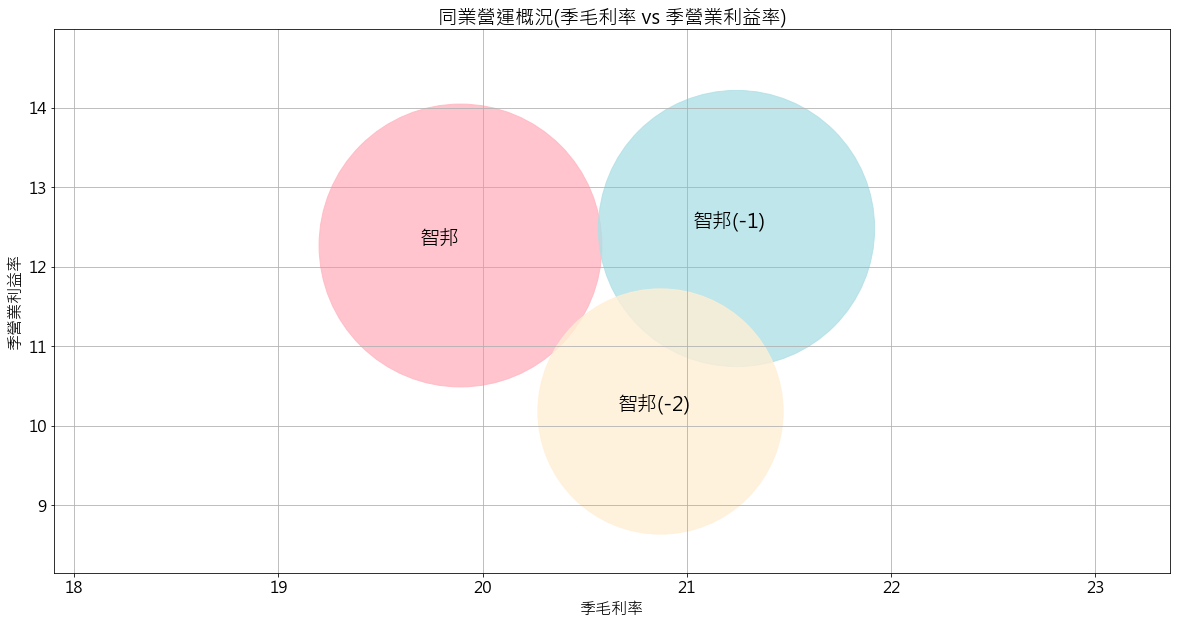

In [3]:
## 類股分析比較
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
replace_dict = {'EPS': '季每股稅後盈餘(元)', 'GPR': '季毛利率', 'OPR': '季營業利益率', 'Post_TaxPR': '季稅後淨利率', 'Revenue': '季營業收入淨額'}
transparency = 0.8
colors = [
    (255/255, 182/255, 193/255, transparency),  # Light Pink
    (176/255, 224/255, 230/255, transparency),  # Powder Blue
    (255/255, 239/255, 213/255, transparency),  # Papaya Whip
    (240/255, 230/255, 140/255, transparency),  # Khaki
    (221/255, 160/255, 221/255, transparency),  # Plum
    (152/255, 251/255, 152/255, transparency),  # Pale Green
    (255/255, 218/255, 185/255, transparency),  # Peach Puff
    (230/255, 230/255, 250/255, transparency),  # Lavender
    (255/255, 192/255, 203/255, transparency),  # Pink
    (176/255, 196/255, 222/255, transparency)   # Light Steel Blue
]
# 中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

observes = '2345 2345 2345'.split(' ')
plot_info = ['EPS', 'GPR', 'OPR']
fundamental_info = pd.DataFrame([], columns = ['EPS', 'GPR', 'OPR', 'Post_TaxPR', 'Revenue', 'name'])
for i, ID in enumerate(observes):
    figure_num = 6
    try:
        repeat_num = observes[:i].count(ID)
        SF = StockFundamental(ID, fig_num=4, fig_index=6, latest_quarter_num=-repeat_num-1)
        SF.get_fundamental_table()
        plt.figure(figsize=(50, figure_num*6))
        print(f'{SF.name}基本面分析')
        SF.plot_quarterly_Post_TaxPR()
        SF.plot_quarterly_GPR()
        SF.plot_quarterly_OPR()
        SF.plot_quarterly_EPS()
        SF.month_revenue()
        SF.plot_quarterly_revenue()
        
        print(repeat_num)
        if repeat_num == 0:
            fundamental_info.loc[f'{ID}'] = [SF.fundamental_info['EPS'], SF.fundamental_info['GPR'], SF.fundamental_info['OPR'], SF.fundamental_info['Post_TaxPR'], SF.fundamental_info['Revenue'], SF.name.split('(')[0]]
        else:
            fundamental_info.loc[f'{ID}_{repeat_num}'] = [SF.fundamental_info['EPS'], SF.fundamental_info['GPR'], SF.fundamental_info['OPR'], SF.fundamental_info['Post_TaxPR'], SF.fundamental_info['Revenue'], f"{SF.name.split('(')[0]}({-repeat_num})"]
        plt.show()
        ## clear_output()
        clear_output()
    
    except:
        print(f'{bcolors.FAIL}Failed to get the data of {ID}{bcolors.RESET}')
        continue
print(fundamental_info)
plt.figure(figsize=(20, 10))
scatter_size_times = 80000/(max(fundamental_info[plot_info[0]])**1.7)
for i, ID in enumerate(fundamental_info.index.values):
    scatter_size = fundamental_info.loc[ID, plot_info[0]]
    scatter_x = fundamental_info.loc[ID, plot_info[1]]
    scatter_y = fundamental_info.loc[ID, plot_info[2]]
    plt.scatter(scatter_x, scatter_y, s=(scatter_size**1.7)*scatter_size_times, color=colors[i], label=ID)

    # add text annotation
    plt.text(scatter_x*0.99, scatter_y, fundamental_info.loc[ID, 'name'], fontsize=20)
plt.xlabel(replace_dict[plot_info[1]])
plt.ylabel(replace_dict[plot_info[2]])
# plt.legend()
plt.xlim(min(fundamental_info[plot_info[1]])*0.9, max(fundamental_info[plot_info[1]])*1.1)
plt.ylim(min(fundamental_info[plot_info[2]])*0.8, max(fundamental_info[plot_info[2]])*1.2)
plt.title(f'同業營運概況({replace_dict[plot_info[1]]} vs {replace_dict[plot_info[2]]})')
plt.grid()
plt.show()


## 舊程式

In [ ]:
# 畫出要查詢股票的基本面
def plot_all(stockID, season = 8):
    green_colors = ['#90ee90', '#006400', '#FFA07A', '#CD5C5C']  # 顏色列表
    
    fsize = 20
    fsize2 = 14
    global driver
    plt.rcParams['axes.facecolor'] = '#F5F5F5'  # 将背景色设为浅灰色
    plt.rcParams['figure.facecolor'] = '#F5F5F5'  # 将图形的背景色设为浅灰色
    ##存貨
    url = f'https://histock.tw/stock/{stockID}/%E7%87%9F%E9%81%8B%E9%80%B1%E8%BD%89'
    print(f'股票代碼 : {stockID}')
    try:
        driver.get(url)
        title = driver.find_element(by = By.TAG_NAME, value = "tbody").text
    except Exception as e:
        print(f'{bcolors.WARNING}{e}{bcolors.RESET}')
        print(f'{bcolors.WARNING}Close Google Failed{bcolors.RESET}')
        try:
            driver.close()
            driver = webdriver.Chrome(service=service, chrome_options=chrome_options)
        except:
            pass
        return [0,0]
        # service = ChromeService(executable_path=ChromeDriverManager().install())
        # driver = webdriver.Chrome(service=service, chrome_options=chrome_options)
    text = title.split('\n')[1:-1]
    column = title.split('\n')[0].split(' ')[1:]
    text_list = []
    index = []
    for i,t in enumerate(text):
        text_list.append(t.split(' ')[1:])
        index.append(t.split(' ')[0])
    IT = pd.DataFrame(text_list, index=index, columns=column)
    date = IT.index.values[0]
    IT_list = IT['存貨週轉(次)'].values
    IT_list = IT_list[:season+8]
    IT_list = list(map(lambda x : x.replace(',',''),IT_list))
    IT_list = list(map(float, IT_list))
    ITyoy = []
    for i in range(season+4):
        if IT_list[i]>IT_list[i+4]:
            ITyoy.append(abs((IT_list[i]-IT_list[i+4])/IT_list[i+4])*100)
        else:
            ITyoy.append(-1*abs((IT_list[i]-IT_list[i+4])/IT_list[i+4])*100)
    avg_ITyoy = []
    avgITyoy_growth = []
    for i in range(season+3):
        # 兩季存貨成長率平均
        avg_ITyoy.append((ITyoy[i]+ITyoy[i+1])/2)
    for i in range(season+2):
        # 兩季存貨成長率平均相減
        if avg_ITyoy[i] > avg_ITyoy[i+1]: 
            avgITyoy_growth.append(((avg_ITyoy[i]-avg_ITyoy[i+1])))
        else:
            avgITyoy_growth.append(((avg_ITyoy[i]-avg_ITyoy[i+1])))
    IT_df = pd.DataFrame([IT_list[:season+4], ITyoy, avg_ITyoy, avgITyoy_growth],index=['IT', 'IT年增率', 'IT年增率2季平均', 'IT年增率2季平均成長率'], columns=range(1,season+5))
    Ix4,Iy4 = range(len(np.flip(IT_df.loc['IT'].values)[-season:])),np.flip(IT_df.loc['IT'].values)[-season:]
    colors = np.where(Iy4 >= 0, 'g', 'orange')
    color_sequence = [green_colors[i % 4] for i in range(len(Ix4))]
    plt.figure(figsize=(50,25))
    plt.subplot(4,4,1)
    for a,b in zip(Ix4,Iy4):
        plt.text(a, b+0.01, '%.2f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(Ix4,Iy4, color =color_sequence)
    plt.title(f'ID:{stockID}({date})      IT', fontsize=fsize, loc='left')
    Ix3,Iy3 = range(len(np.flip(IT_df.loc['IT年增率'].values)[-season:])),np.flip(IT_df.loc['IT年增率'].values)[-season:]
    colors = np.where(Iy3 >= 0, 'g', 'orange')
    plt.subplot(4,4,2)
    for a,b in zip(Ix3,Iy3):
        plt.text(a, b+0.05, '%.1f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(Ix3,Iy3, color = colors)
    plt.title('IT yoy', fontsize=fsize)
    plt.subplot(4,4,3)
    Ix2,Iy2 = range(len(np.flip(IT_df.loc['IT年增率2季平均'].values)[-season:])),np.flip(IT_df.loc['IT年增率2季平均'].values)[-season:]
    colors = np.where(Iy2 >= 0, 'g', 'orange')
    for a,b in zip(Ix2,Iy2):
        plt.text(a, b+0.05, '%.1f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(Ix2,Iy2, color = colors)
    plt.title('IT yoy 2Q AVG', fontsize=fsize)
    plt.subplot(4,4,4)
    Ix,Iy = range(len(np.flip(IT_df.loc['IT年增率2季平均成長率'].values)[-season:])),np.flip(IT_df.loc['IT年增率2季平均成長率'].values)[-season:]
    colors = np.where(Iy >= 0, 'g', 'orange')
    for a,b in zip(Ix,Iy):
        plt.text(a, b+0.05, '%.1f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(Ix,Iy, color = colors)
    plt.title('Growth of IT yoy 2Q AVG', fontsize=fsize)
    ##EPS
    url2 = f'https://histock.tw/stock/{stockID}/%E6%AF%8F%E8%82%A1%E7%9B%88%E9%A4%98'
    try:
        driver.get(url2)
        title = driver.find_element(by = By.TAG_NAME, value = "tbody").text
    except Exception as e:
        print(f'{bcolors.WARNING}{e}{bcolors.RESET}')
        print(f'{bcolors.WARNING}Close Google Failed{bcolors.RESET}')
        pass
        # service = ChromeService(executable_path=ChromeDriverManager().install())
        # driver = webdriver.Chrome(service=service, chrome_options=chrome_options)
    text = title.split('\n')[1:-1]
    column = title.split('\n')[0].split(' ')[1:]
    text_list = []
    index = []
    for i,t in enumerate(text):
        text_list.append(t.split(' ')[1:])
        index.append(t.split(' ')[0])
    EPS = pd.DataFrame(text_list, index=index, columns=column.extend([' ',' ',' ',' ',' ',' ',' ',' ',' '])).replace('-','n')
    EPS_list = []
    for i in EPS.transpose().values:
        EPS_list.extend(i[i!='n'])
    EPS_list = EPS_list[-season-8:][::-1]
    EPS_list = list(map(float, EPS_list))
    EPSyoy = []
    for i in range(season+4):
        if EPS_list[i]>EPS_list[i+4]:
            try:
                EPSyoy.append(abs((EPS_list[i]-EPS_list[i+4])/EPS_list[i+4])*100)
            except:
                EPSyoy.append(0)
        else:
            try:
                EPSyoy.append(-1*abs((EPS_list[i]-EPS_list[i+4])/EPS_list[i+4])*100)
            except:
                EPSyoy.append(0)
    avg_EPSyoy = []
    avgEPSyoy_growth = []
    for i in range(season+3):
        # 兩季EPS成長率平均
        avg_EPSyoy.append((EPSyoy[i]+EPSyoy[i+1])/2)
    for i in range(season+2):
        # 兩季EPS成長率平均相減
        if avg_EPSyoy[i] > avg_EPSyoy[i+1]: 
            avgEPSyoy_growth.append(((avg_EPSyoy[i]-avg_EPSyoy[i+1])))
        else:
            avgEPSyoy_growth.append(((avg_EPSyoy[i]-avg_EPSyoy[i+1])))
    EPS_df = pd.DataFrame([EPS_list[:season+4], EPSyoy, avg_EPSyoy, avgEPSyoy_growth],index=['EPS', 'EPS年增率', 'EPS年增率2季平均', 'EPS年增率2季平均成長率'], columns=range(1,season+5))
    x4,y4 = range(len(np.flip(EPS_df.loc['EPS'].values)[-season:])),np.flip(EPS_df.loc['EPS'].values)[-season:]
    colors = np.where(y4 >= 0, 'g', 'orange')
    color_sequence = [green_colors[i % 4] for i in range(len(x4))]
    plt.subplot(4,4,5)
    for a,b in zip(x4,y4):
        plt.text(a, b+0.01, '%.2f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(x4,y4, color =color_sequence)
    plt.title('EPS', fontsize=fsize)
    x3,y3 = range(len(np.flip(EPS_df.loc['EPS年增率'].values)[-season:])),np.flip(EPS_df.loc['EPS年增率'].values)[-season:]
    colors = np.where(y3 >= 0, 'g', 'orange')
    plt.subplot(4,4,6)
    for a,b in zip(x3,y3):
        plt.text(a, b+0.05, '%.1f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(x3,y3, color = colors)
    plt.title('EPS yoy', fontsize=fsize)
    plt.subplot(4,4,7)
    x2,y2 = range(len(np.flip(EPS_df.loc['EPS年增率2季平均'].values)[-season:])),np.flip(EPS_df.loc['EPS年增率2季平均'].values)[-season:]
    colors = np.where(y2 >= 0, 'g', 'orange')
    for a,b in zip(x2,y2):
        plt.text(a, b+0.05, '%.1f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(x2,y2, color = colors)
    plt.title('EPS yoy 2Q AVG', fontsize=fsize)
    plt.subplot(4,4,8)
    x,y = range(len(np.flip(EPS_df.loc['EPS年增率2季平均成長率'].values)[-season:])),np.flip(EPS_df.loc['EPS年增率2季平均成長率'].values)[-season:]
    colors = np.where(y >= 0, 'g', 'orange')
    for a,b in zip(x,y):
        plt.text(a, b+0.05, '%.1f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(x,y, color = colors)
    plt.title('Growth of EPS yoy 2Q AVG', fontsize=fsize)
    ## 營收
    month_revenue_url = f'https://histock.tw/stock/{stockID}/%E6%AF%8F%E6%9C%88%E7%87%9F%E6%94%B6'
    
    url3 = f'https://histock.tw/stock/financial.aspx?no={stockID}&t=5&st=4&q=2'
    try:
        driver.get(month_revenue_url)
        title = driver.find_element(by = By.TAG_NAME, value = "tbody").text
    except Exception as e:
        print(f'{bcolors.WARNING}{e}{bcolors.RESET}')
        print(f'{bcolors.WARNING}Close Google Failed{bcolors.RESET}')
        pass
    month_revenue_list = title.split('\n')[1:]
    month_revunue_columns = ['月份']
    month_revunue_columns.extend(month_revenue_list[0].split(' '))
    text_list = []
    for i,t in enumerate(month_revenue_list[1:]):
        text_list.append(t.split(' '))
    month_revenue_df = pd.DataFrame(text_list, columns=month_revunue_columns)
    Rx4,Ry4 = range(len(np.flip(month_revenue_df.iloc[:(season+1)*3, 1].values[::-1]))),np.array(list(map(lambda x:x.replace(',',''), month_revenue_df.iloc[:(season+1)*3, 1])))[::-1].astype(float)/1000
    Rx4_text = month_revenue_df.iloc[:(season+1)*3, 0].values[::-1]
    green_gradient = ['#e0f2f1', '#d0e9e3', '#c0e0d5', '#b0d7c7', '#a0ceb9', '#90c5ab',  
    '#80bc9d', '#70b38f', '#60aa81', '#50a173', '#409865', '#308f57']
    color_sequence = [green_gradient[i % 12] for i in range(len(Rx4))]
    plt.subplot(4,4,9)
    for a,b in zip(Rx4,Ry4):
        plt.text(a, b/2, '%.0f' % b, ha='center', va= 'bottom',fontsize=fsize2, rotation=90)
    plt.bar(Rx4,Ry4, color = color_sequence)
    plt.xticks(Rx4, Rx4_text, rotation = 30, fontsize=10)
    plt.title('Revenue(k NTD)', fontsize=fsize)
    try:
        driver.get(url3)
        title = driver.find_element(by = By.TAG_NAME, value = "tbody").text
    except Exception as e:
        print(f'{bcolors.WARNING}{e}{bcolors.RESET}')
        print(f'{bcolors.WARNING}Close Google Failed{bcolors.RESET}')
        pass
        # service = ChromeService(executable_path=ChromeDriverManager().install())
        # driver = webdriver.Chrome(service=service, chrome_options=chrome_options))
    text = title.replace('%','').split('\n')
    column = title.split('\n')[0].split(' ')
    text_list = []
    index = []
    for i,t in enumerate(text):
        text_list.append(t.split(' '))
    revenue = pd.DataFrame(text_list)
    revenue1 = revenue.loc[1:,:2]
    revenue2 = revenue.loc[1:,3:]
    revenue2.columns = [0,1,2]
    revenue = pd.concat([revenue1, revenue2], axis=0, ignore_index=True)
    
    # revenue.columns = column[0:3]
    avg_revenueyoy = []
    revenueyoy = revenue.iloc[:season, 1].astype(float)
    for i in range(season+1):
        avg_revenueyoy.append(np.mean(revenue.iloc[[i,i+1],1].astype(float)))
    avgrevenueyoy_growth = []
    for i in range(season):
        avgrevenueyoy_growth.append(avg_revenueyoy[i]-avg_revenueyoy[i+1])
    revenue_df = pd.DataFrame([np.zeros(season), revenueyoy, avg_revenueyoy, avgrevenueyoy_growth],index=['營收', '營收年增率', '營收年增率2季平均', '營收年增率2季平均成長率'])
    
    Rx3,Ry3 = range(len((revenue_df.loc['營收年增率',:season-1].values[::-1]))),(revenue_df.loc['營收年增率', :season-1].values[::-1])
    colors = np.where(Ry3 >= 0, 'g', 'orange')
    plt.subplot(4,4,10)
    for a,b in zip(Rx3,Ry3):
        plt.text(a, b+0.05, '%.1f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(Rx3,Ry3, color = colors)
    plt.title('Revenue yoy', fontsize=fsize)
    plt.subplot(4,4,11)
    Rx2,Ry2 = range(len((revenue_df.loc['營收年增率2季平均', :season-1].values[::-1]))),(revenue_df.loc['營收年增率2季平均', :season-1].values[::-1])
    colors = np.where(Ry2 >= 0, 'g', 'orange')
    for a,b in zip(Rx2,Ry2):
        plt.text(a, b+0.05, '%.1f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(Rx2,Ry2, color = colors)
    plt.title('Revenue yoy 2Q AVG', fontsize=fsize)
    plt.subplot(4,4,12)
    Rx,Ry = range(len((revenue_df.loc['營收年增率2季平均成長率',:season-1].values[::-1]))),(revenue_df.loc['營收年增率2季平均成長率',:season-1].values[::-1])
    colors = np.where(Ry >= 0, 'g', 'orange')
    for a,b in zip(Rx,Ry):
        plt.text(a, b+0.05, '%.1f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(Rx,Ry, color = colors)
    plt.title('Growth of Revenue yoy 2Q AVG', fontsize=fsize)
    ##現金流
    url4 = f'https://histock.tw/stock/{stockID}/%E7%8F%BE%E9%87%91%E6%B5%81%E9%87%8F%E8%A1%A8'
    try:
        driver.get(url4)
        title = driver.find_element(by = By.TAG_NAME, value = "tbody").text
    except Exception as e:
        print(f'{bcolors.WARNING}{e}{bcolors.RESET}')
        print(f'{bcolors.WARNING}Close Google Failed{bcolors.RESET}')
        try:
            driver.close()
            driver = webdriver.Chrome(service=service, chrome_options=chrome_options)
        except:
            pass
        # service = ChromeService(executable_path=ChromeDriverManager().install())
        # driver = webdriver.Chrome(service=service, chrome_options=chrome_options)
    text = title.replace(',', '').split('\n')
    column = title.split('\n')[0].split(' ')[1:]
    CF_df = pd.DataFrame(list(map(lambda x:x.split(' '), text[1:])), columns=text[0].split(' '))
    CF_index = CF_df['年度/季別'].values
    CF_df.drop('年度/季別', axis=1, inplace=True)
    CF_df.index = CF_index
    CF_df = CF_df.astype(float)/1000
    years = int(season/4)
    CF_sum_year = []
    for year in range(years):
        CF_sum_year.append(sum(CF_df.iloc[(year)*4:(year+1)*4]['自由現金流'].values))
    plt.subplot(4,4,13)
    plt.title(f'ID:{stockID}({CF_df.index.values[0]})    CF', fontsize=fsize, loc='left')
    CFx,CFy = range(len(np.flip(CF_df.iloc[:season]['自由現金流'].values))),np.flip(CF_df.iloc[:season]['自由現金流'].values)
    colors = np.where(CFy >= 0, 'g', 'orange')
    color_sequence = [green_colors[i % 4] for i in range(len(CFx))]
    for a,b in zip(CFx,CFy):
        plt.text(a, b+0.05, '%.1f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(CFx,CFy, color =color_sequence)
    plt.subplot(4,4,14)
    plt.title('CF Sum of Year', fontsize=fsize)
    CFx2,CFy2 = range(len(np.flip(CF_sum_year))),np.flip(CF_sum_year)
    colors = np.where(CFy2 >= 0, 'g', 'orange')
    for a,b in zip(CFx2,CFy2):
        plt.text(a, b+0.05, '%.1f' % b, ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(CFx2,CFy2, color = colors)
    plt.xticks([0,1,2],[0,1,2])
    plt.subplot(4,4,15)
    plt.title('--', fontsize=fsize)
    plt.subplot(4,4,16)
    plt.title('--', fontsize=fsize)
    # plt.show()
    return [y3, y2]
# 用基本面篩選股票
def choose_all(stockID, season = 8):
    fsize = 20
    fsize2 = 14
    global driver
    plt.rcParams['axes.facecolor'] = '#F5F5F5'  # 将背景色设为浅灰色
    plt.rcParams['figure.facecolor'] = '#F5F5F5'  # 将图形的背景色设为浅灰色
    ##存貨
    url = f'https://histock.tw/stock/{stockID}/%E7%87%9F%E9%81%8B%E9%80%B1%E8%BD%89'
    print(f'股票代碼 : {stockID}')
    try:
        driver.get(url)
        title = driver.find_element(by = By.TAG_NAME, value = "tbody").text
    except Exception as e:
        print(f'{bcolors.WARNING}{e}{bcolors.RESET}')
        print(f'{bcolors.WARNING}Close Google Failed{bcolors.RESET}')
        try:
            driver.close()
            driver = webdriver.Chrome(service=service, chrome_options=chrome_options)
        except:
            pass
        return [0,0]
        # service = ChromeService(executable_path=ChromeDriverManager().install())
        # driver = webdriver.Chrome(service=service, chrome_options=chrome_options)
    text = title.split('\n')[1:-1]
    column = title.split('\n')[0].split(' ')[1:]
    text_list = []
    index = []
    for i,t in enumerate(text):
        text_list.append(t.split(' ')[1:])
        index.append(t.split(' ')[0])
    IT = pd.DataFrame(text_list, index=index, columns=column)
    date = IT.index.values[0]
    IT_list = IT['存貨週轉(次)'].values
    IT_list = IT_list[:season+8]
    IT_list = list(map(lambda x : x.replace(',',''),IT_list))
    IT_list = list(map(float, IT_list))
    ITyoy = []
    for i in range(season+4):
        if IT_list[i]>IT_list[i+4]:
            ITyoy.append(abs((IT_list[i]-IT_list[i+4])/IT_list[i+4])*100)
        else:
            ITyoy.append(-1*abs((IT_list[i]-IT_list[i+4])/IT_list[i+4])*100)
    avg_ITyoy = []
    avgITyoy_growth = []
    for i in range(season+3):
        # 兩季存貨成長率平均
        avg_ITyoy.append((ITyoy[i]+ITyoy[i+1])/2)
    for i in range(season+2):
        # 兩季存貨成長率平均相減
        if avg_ITyoy[i] > avg_ITyoy[i+1]: 
            avgITyoy_growth.append(((avg_ITyoy[i]-avg_ITyoy[i+1])))
        else:
            avgITyoy_growth.append(((avg_ITyoy[i]-avg_ITyoy[i+1])))
    IT_df = pd.DataFrame([IT_list[:season+4], ITyoy, avg_ITyoy, avgITyoy_growth],index=['IT', 'IT年增率', 'IT年增率2季平均', 'IT年增率2季平均成長率'], columns=range(1,season+5))
    Ix4,Iy4 = range(len(np.flip(IT_df.loc['IT'].values)[-season:])),np.flip(IT_df.loc['IT'].values)[-season:]
    Ix3,Iy3 = range(len(np.flip(IT_df.loc['IT年增率'].values)[-season:])),np.flip(IT_df.loc['IT年增率'].values)[-season:]
    Ix2,Iy2 = range(len(np.flip(IT_df.loc['IT年增率2季平均'].values)[-season:])),np.flip(IT_df.loc['IT年增率2季平均'].values)[-season:]
    Ix,Iy = range(len(np.flip(IT_df.loc['IT年增率2季平均成長率'].values)[-season:])),np.flip(IT_df.loc['IT年增率2季平均成長率'].values)[-season:]
    ##EPS
    url2 = f'https://histock.tw/stock/{stockID}/%E6%AF%8F%E8%82%A1%E7%9B%88%E9%A4%98'
    try:
        driver.get(url2)
        title = driver.find_element(by = By.TAG_NAME, value = "tbody").text
    except Exception as e:
        print(f'{bcolors.WARNING}{e}{bcolors.RESET}')
        print(f'{bcolors.WARNING}Close Google Failed{bcolors.RESET}')
        pass
        # service = ChromeService(executable_path=ChromeDriverManager().install())
        # driver = webdriver.Chrome(service=service, chrome_options=chrome_options)
    text = title.split('\n')[1:-1]
    column = title.split('\n')[0].split(' ')[1:]
    text_list = []
    index = []
    for i,t in enumerate(text):
        text_list.append(t.split(' ')[1:])
        index.append(t.split(' ')[0])
    EPS = pd.DataFrame(text_list, index=index, columns=column.extend([' ',' ',' ',' ',' ',' ',' ',' ',' '])).replace('-','n')
    EPS_list = []
    for i in EPS.transpose().values:
        EPS_list.extend(i[i!='n'])
    EPS_list = EPS_list[-season-8:][::-1]
    EPS_list = list(map(float, EPS_list))
    EPSyoy = []
    for i in range(season+4):
        if EPS_list[i]>EPS_list[i+4]:
            try:
                EPSyoy.append(abs((EPS_list[i]-EPS_list[i+4])/EPS_list[i+4])*100)
            except:
                EPSyoy.append(0)
        else:
            try:
                EPSyoy.append(-1*abs((EPS_list[i]-EPS_list[i+4])/EPS_list[i+4])*100)
            except:
                EPSyoy.append(0)
    avg_EPSyoy = []
    avgEPSyoy_growth = []
    for i in range(season+3):
        # 兩季EPS成長率平均
        avg_EPSyoy.append((EPSyoy[i]+EPSyoy[i+1])/2)
    for i in range(season+2):
        # 兩季EPS成長率平均相減
        if avg_EPSyoy[i] > avg_EPSyoy[i+1]: 
            avgEPSyoy_growth.append(((avg_EPSyoy[i]-avg_EPSyoy[i+1])))
        else:
            avgEPSyoy_growth.append(((avg_EPSyoy[i]-avg_EPSyoy[i+1])))
    EPS_df = pd.DataFrame([EPS_list[:season+4], EPSyoy, avg_EPSyoy, avgEPSyoy_growth],index=['EPS', 'EPS年增率', 'EPS年增率2季平均', 'EPS年增率2季平均成長率'], columns=range(1,season+5))
    x4,y4 = range(len(np.flip(EPS_df.loc['EPS'].values)[-season:])),np.flip(EPS_df.loc['EPS'].values)[-season:]
    x3,y3 = range(len(np.flip(EPS_df.loc['EPS年增率'].values)[-season:])),np.flip(EPS_df.loc['EPS年增率'].values)[-season:]
    x2,y2 = range(len(np.flip(EPS_df.loc['EPS年增率2季平均'].values)[-season:])),np.flip(EPS_df.loc['EPS年增率2季平均'].values)[-season:]
    x,y = range(len(np.flip(EPS_df.loc['EPS年增率2季平均成長率'].values)[-season:])),np.flip(EPS_df.loc['EPS年增率2季平均成長率'].values)[-season:]
    
    return [y3, y2]
# 月營收
def month_revenue(stockID, n_months = 8):
    fsize = 20
    fsize2 = 14
    green_gradient = ['#e0f2f1', '#d0e9e3', '#c0e0d5', '#b0d7c7', '#a0ceb9', '#90c5ab',  
    '#80bc9d', '#70b38f', '#60aa81', '#50a173', '#409865', '#308f57']
    get_m_month = n_months + 12

    plt.figure(figsize=(50,8))
    month_revenue_url = f'https://histock.tw/stock/{stockID}/%E6%AF%8F%E6%9C%88%E7%87%9F%E6%94%B6'
    try:
        driver.get(month_revenue_url)
        title = driver.find_element(by = By.TAG_NAME, value = "tbody").text
        name = driver.find_element(by=By.XPATH, value='//*[@id="form1"]/div[4]/div[4]/div/div[1]/div[3]/div/div[5]/div/h3').text
        print(name)
    except Exception as e:
        print(f'{bcolors.WARNING}{e}{bcolors.RESET}')
        print(f'{bcolors.WARNING}Close Google Failed{bcolors.RESET}')
        pass
    ## build month revenue dataframe
    month_revenue_list = title.split('\n')[1:]
    month_revunue_columns = ['月份']
    month_revunue_columns.extend(month_revenue_list[0].split(' '))
    text_list = []
    for i,t in enumerate(month_revenue_list[1:]):
        text_list.append(t.split(' '))
    month_revenue_df = pd.DataFrame(text_list, columns=month_revunue_columns)
    month_revenue_df = month_revenue_df.iloc[:get_m_month]
    month_revenue_df['單月年增率'] = month_revenue_df['單月年增率'].replace('%','',regex=True)

    ## plot month revenue values
    month_revenue_values = np.array(list(map(lambda x:x.replace(',',''), month_revenue_df.iloc[:get_m_month, 1])))[::-1].astype(float)/1000
    month_revenue_x,month_revenue_y = range(len(month_revenue_values)),month_revenue_values

    month_revenue_x_text = month_revenue_df.iloc[:get_m_month, 0].values[::-1]

    color_sequence = [green_gradient[i % 12] for i in range(len(month_revenue_y))]
    plt.subplot(1,4,1)
    for a,b in zip(month_revenue_x,month_revenue_y):
        plt.text(a, b/2, f"{'%.1f' % b}k", ha='center', va= 'bottom',fontsize=fsize2, rotation=90)
    plt.bar(month_revenue_x,month_revenue_y, color = color_sequence)
    # plot a star on the last month
    plt.scatter(month_revenue_x[-13], month_revenue_y[-13]*1.05, color='red', s=100, marker='*')
    plt.scatter(month_revenue_x[-14], month_revenue_y[-14]*1.05, color='red', s=100, marker='*')
    # plot a horizontal line on the last month
    plt.axhline(y=month_revenue_y[-13], color='red', linestyle='--')
    plt.axhline(y=month_revenue_y[-14], color='red', linestyle='--')
    plt.xticks(month_revenue_x, month_revenue_x_text, rotation = 30, fontsize=10)
    plt.title(f'ID : {stockID}                    Revenue(NTD)', fontsize=fsize, loc='left')
    ## build month revenue yoy dataframe
    month_revenue_yoy = month_revenue_df.loc[:n_months-1, '單月年增率'].astype(float)[::-1]
    month_revenue_yoy_x,month_revenue_yoy_y = range(len(month_revenue_yoy)),month_revenue_yoy
    colors = np.where(month_revenue_yoy_y >= 0, 'g', 'orange')
    plt.subplot(1,4,2)
    for a,b in zip(month_revenue_yoy_x,month_revenue_yoy_y):
        plt.text(a, b+0.05, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(month_revenue_yoy_x,month_revenue_yoy_y, color = colors)
    plt.xticks(month_revenue_yoy_x, month_revenue_x_text[-n_months:], rotation = 30, fontsize=10)
    plt.title('Revenue yoy', fontsize=fsize)

    ## build month revenue yoy 2M AVG dataframe
    month_revenue_yoy_2m_avg = []
    for i in range(n_months+1):
        month_revenue_yoy_2m_avg.append(np.mean(month_revenue_df.loc[[i,i+1],'單月年增率'].astype(float)))
    month_revenue_yoy_2m_avg_x,month_revenue_yoy_2m_avg_y = range(len(month_revenue_yoy_2m_avg[:n_months])),month_revenue_yoy_2m_avg[:n_months][::-1]
    
    colors = np.where(np.array(month_revenue_yoy_2m_avg_y) >= 0, 'g', 'orange')
    plt.subplot(1,4,3)
    for a,b in zip(month_revenue_yoy_2m_avg_x,month_revenue_yoy_2m_avg_y):
        plt.text(a, b+0.05, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(month_revenue_yoy_2m_avg_x,month_revenue_yoy_2m_avg_y, color = colors)
    plt.xticks(month_revenue_yoy_2m_avg_x, month_revenue_x_text[-n_months:], rotation = 30, fontsize=10)
    plt.title('Revenue yoy 2M AVG', fontsize=fsize)

    ## build month revenue yoy 2M AVG growth dataframe
    month_revenue_yoy_2m_avg_growth = []
    for i in range(n_months):
        month_revenue_yoy_2m_avg_growth.append(month_revenue_yoy_2m_avg[i]-month_revenue_yoy_2m_avg[i+1])
    month_revenue_yoy_2m_avg_growth_x,month_revenue_yoy_2m_avg_growth_y = range(len(month_revenue_yoy_2m_avg_growth)),month_revenue_yoy_2m_avg_growth[::-1]
    colors = np.where(np.array(month_revenue_yoy_2m_avg_growth_y) >= 0, 'g', 'orange')
    plt.subplot(1,4,4)
    for a,b in zip(month_revenue_yoy_2m_avg_growth_x,month_revenue_yoy_2m_avg_growth_y):
        plt.text(a, b+0.05, f"{'%.1f' % b}%", ha='center', va= 'bottom',fontsize=fsize2)
    plt.bar(month_revenue_yoy_2m_avg_growth_x,month_revenue_yoy_2m_avg_growth_y, color = colors)
    plt.title('Growth of Revenue yoy 2M AVG', fontsize=fsize)
    plt.show()

In [ ]:
stockID = '8112'
month_revenue(stockID, n_months=8)

In [ ]:
t = """年度/月份 營業收入（單位：千元） 累計營業收入（單位：千元）
單月營收 去年同月營收 單月月增率 單月年增率 累計營收 去年累計營收 累積年增率
2024/02 181,648,304 163,174,096 -15.8% 11.3% 397,433,408 363,224,608 9.4%
2024/01 215,785,104 200,050,496 22.4% 7.9% 215,785,104 200,050,496 7.9%
2023/12 176,299,904 192,560,192 -14.4% -8.4% 2,161,735,936 2,263,890,944 -4.5%
2023/11 206,026,208 222,706,000 -15.3% -7.5% 1,985,436,032 2,071,330,944 -4.1%
2023/10 243,202,800 210,265,600 34.8% 15.7% 1,779,410,048 1,848,625,024 -3.7%
2023/09 180,430,304 208,247,696 -4.4% -13.4% 1,536,206,976 1,638,359,040 -6.2%
2023/08 188,686,304 218,132,400 6.2% -13.5% 1,355,777,024 1,430,112,000 -5.2%
2023/07 177,616,192 186,762,704 13.6% -4.9% 1,167,090,048 1,211,979,008 -3.7%
2023/06 156,404,192 175,874,000 -11.4% -11.1% 989,474,176 1,025,217,024 -3.5%
2023/05 176,537,296 185,705,408 19.4% -4.9% 833,070,080 849,342,720 -1.9%
2023/04 147,899,696 172,561,408 1.7% -14.3% 656,532,672 663,637,184 -1.1%
2023/03 145,408,304 171,966,496 -10.9% -15.4% 508,632,992 491,075,904 3.6%
2023/02 163,174,096 146,933,200 -18.4% 11.1% 363,224,608 319,109,312 13.8%
2023/01 200,050,496 172,176,096 3.9% 16.2% 200,050,496 172,176,096 16.2%
2022/12 192,560,192 155,382,208 -13.5% 23.9% 2,263,890,944 1,587,415,040 42.6%
2022/11 222,706,000 148,267,600 5.9% 50.2% 2,071,330,944 1,432,033,024 44.6%
2022/10 210,265,600 134,539,504 1% 56.3% 1,848,625,024 1,283,764,992 44%
2022/09 208,247,696 152,685,408 -4.5% 36.4% 1,638,359,040 1,149,225,984 42.6%
2022/08 218,132,400 137,427,200 16.8% 58.7% 1,430,112,000 996,540,288 43.5%
2022/07 186,762,704 124,557,800 6.2% 49.9% 1,211,979,008 859,113,216 41.1%
2022/06 175,874,000 148,470,704 -5.3% 18.5% 1,025,217,024 734,555,328 39.6%
2022/05 185,705,408 112,359,696 7.6% 65.3% 849,342,720 586,084,672 44.9%
2022/04 172,561,408 111,314,800 0.3% 55% 663,637,184 473,724,992 40.1%
2022/03 171,966,496 129,127,400 17% 33.2% 491,075,904 362,410,208 35.5%
2022/02 146,933,200 106,533,696 -14.7% 37.9% 319,109,312 233,282,800 36.8%
2022/01 172,176,096 126,749,200 10.8% 35.8% 172,176,096 126,749,200 35.8%
2021/12 155,382,208 117,364,896 4.8% 32.4% 1,587,415,040 1,339,255,040 18.5%
2021/11 148,267,600 124,865,400 10.2% 18.7% 1,432,033,024 1,221,890,048 17.2%
2021/10 134,539,504 119,302,704 -11.9% 12.8% 1,283,764,992 1,097,025,024 17%
2021/09 152,685,408 127,584,496 11.1% 19.7% 1,149,225,984 977,721,728 17.5%
2021/08 137,427,200 122,878,200 10.3% 11.8% 996,540,288 850,137,280 17.2%
2021/07 124,557,800 105,963,504 -16.1% 17.5% 859,113,216 727,259,008 18.1%
2021/06 148,470,704 120,877,800 32.1% 22.8% 734,555,328 621,295,616 18.2%
2021/05 112,359,696 93,819,008 0.9% 19.8% 586,084,672 500,417,792 17.1%
2021/04 111,314,800 96,001,568 -13.8% 15.9% 473,724,992 406,598,784 16.5%
2021/03 129,127,400 113,519,600 21.2% 13.7% 362,410,208 310,597,184 16.7%"""
season = 3
month_revenue_list = t.split('\n')[1:]
month_revunue_columns = ['月份']
month_revunue_columns.extend(month_revenue_list[0].split(' '))
text_list = []
for i,t in enumerate(month_revenue_list[1:]):
    text_list.append(t.split(' '))
month_revenue_df = pd.DataFrame(text_list, columns=month_revunue_columns)
Rx4,Ry4 = range(len(np.flip(month_revenue_df.iloc[:(season+1)*3, 1].values[::-1]))),np.array(list(map(lambda x:x.replace(',',''), month_revenue_df.iloc[:(season+1)*3, 1]))).astype(float)/1000
Rx4_text = month_revenue_df.iloc[:(season+1)*3, 0].values[::-1]
colors = np.where(Ry4 >= 0, 'g', 'orange')
fsize = 20
fsize2 = 5
for a,b in zip(Rx4,Ry4):
    plt.text(a, b+0.01, '%.2f' % b, ha='center', va= 'bottom',fontsize=fsize2, rotation=0)
plt.bar(Rx4,Ry4, color = colors)
plt.xticks(Rx4, Rx4_text, rotation=0)
plt.title('Revenue(k NTD)', fontsize=fsize)

In [ ]:
# 查詢個股
plt.rcParams['axes.facecolor'] = '#F5F5F5'  # 将背景色设为浅灰色
plt.rcParams['figure.facecolor'] = '#F5F5F5'  # 将图形的背景色设为浅灰色
stockID = '6806'
a = plot_all(stockID, 8)
plt.show()
# if all(value > 50 for value in a):
#     plt.show()


In [ ]:
# 查詢
n_day_ago = -0
day = datetime.datetime.strptime(str(datetime.date.today() + datetime.timedelta(days=n_day_ago)) , '%Y-%m-%d' )
# stock = pd.read_excel('C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/250RS選股/' + str(day).split(' ')[0] + '250RS選股' + '.xlsx').sort_values(by='ID')
stock = pd.read_excel('C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/250RS選股/2022-04-29250RS選股' + '.xlsx').sort_values(by='ID')

stockID = stock['ID'].astype(int)
good_f = []
# 最近三季成長皆大於25%(成長股)
for i in stockID:
    try:
        b, a = choose_all(str(i), 12)
        a = a[-2:]
        b = b[-2:]
        if all(value > 25 for value in a) | all(value > 50 for value in b):
            plt.clf()
            if all(value > 25 for value in a) & all(value > 50 for value in b):
                print('A&B')
            elif all(value > 25 for value in a):
                print('A')
            elif all(value > 50 for value in b):
                print('B')
            else:
                print('None')
            good_f.append(i)
        else:
            print('BAD')
        plt.clf()
    except Exception as e:
        print(e)
        continue
# # 最近一季成長皆大於100%(轉機股)
# for i in stockID:
#     try:
#         a = plot_all(str(i), 12)[0]
#         print()
#         if all(value > 50 for value in a[-2:]):
#             plt.clf()
#             good_f1.append(i)
#         else:
#             print('BAD')
            
#     except Exception as e:
#         print(e)

In [ ]:
goodf = stock.set_index('ID')
goodf = goodf.loc[good_f]
# goodf.to_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/含基本面選股/' + str(day).split(' ')[0] + 'RS選股(含基本面).xlsx')
goodf.to_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/含基本面選股/2022-04-29RS選股(含基本面).xlsx')

# goodf1 = goodf.loc[good_f1]
# goodf1.to_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/2023-05-19選股(含基本面1).xlsx')

In [ ]:
good_f = pd.read_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/' + str(day).split(' ')[0] + 'RS選股(含基本面).xlsx')['ID']
for i in good_f:
    try:
        a = plot_all(str(i), 12)
        plt.show()
    except :
        try:
            a = plot_all(str(i), 8)
            plt.show()
        except :
            try:
                a = plot_all(str(i), 4)
                plt.show()
            except Exception as e:
               print(e)

In [ ]:
print(good_f)
stockID = np.array(stockID).reshape(1,351)
stockID = stockID[stockID not in np.array(good_f)]
print(stockID)
a = stock.loc[stockID[0,0].astype(str)]
print(a)
a.to_excel('C:/Users/User/Desktop/code/python/stockdata_VCP/VCP_predict_project/history_choosen/2023-05-19選股(基本面差).xlsx')